In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] ='20'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
import struct
import json
import sys
import seaborn as sns 
from scipy import signal, stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
import functools

In [2]:
import multiprocessing
multiprocessing.cpu_count()

88

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#!pip install ipynb --upgrade

Requirement already up-to-date: ipynb in /opt/conda/lib/python3.6/site-packages (0.5.1)


In [4]:
import ipynb.fs.defs.Spectral_clustering_pipeline
import ipynb.fs.defs.prediction_strength

In [5]:
data_dir = '../Data/'

## Data

In [6]:
data_burst_by_time = np.load(data_dir + 'data_burst_by_time.npy').T
data_burst_by_time_20_21 = np.load(data_dir + 'raw_Data/data_burst_by_time_20_21.npy').T
data_burst_by_time_shuffled = (np.random.permutation(data_burst_by_time))
print("Averaged over channels (Day 20): ", data_burst_by_time.shape)
print("Averaged over channels (Day 20+21): ", data_burst_by_time_20_21.shape)

Averaged over channels (Day 20):  (13092, 3410)
Averaged over channels (Day 20+21):  (24663, 3410)


In [7]:
dataset_cutted = data_burst_by_time[:,1000:2500] # 1. cut 1000 - 2500 2. cut 1200 - 2200
dataset_cutted2 = data_burst_by_time[:,1200:2200]
print("First Cut: ", dataset_cutted.shape)
print("Second Cut: ", dataset_cutted2.shape)

First Cut:  (13092, 1500)
Second Cut:  (13092, 1000)


In [8]:
data = data_burst_by_time_20_21 #data_burst_by_time_20_21 #data_burst_by_time

In [9]:
train_folds = np.load(data_dir + "day_20_21_split/train_folds_day_20.npy") #"day_20_21_split/train_folds_day_20.npy") #50_50_split/train_folds_50_50.npy "culture_balanced/culture_balanced_training_split.npy"
valid_folds = np.load(data_dir + "day_20_21_split/valid_folds_day_21.npy") #day_20_21_split/valid_folds_day_21.npy") #"culture_balanced/culture_balanced_validation_split.npy"

if len(train_folds.shape)>1:
    training_sets = []
    validation_sets = []
    for i, split in enumerate(train_folds):
        training_sets.append(data[split])
        validation_sets.append(data[valid_folds[i]])
else:
    train_folds = [train_folds]
    valid_folds = [valid_folds]
    training_sets = [data[train_folds]]  #data_burst_by_time[training_split] # extract training bursts from dataset with indices
    validation_sets = [data[valid_folds]]  #data_burst_by_time[test_split] # extract validation bursts from dataset with indices 

In [10]:
# for cross validation od 20 21 
train_folds.append(valid_folds[0])
valid_folds.append(train_folds[0])

In [11]:
for i, train_set in enumerate(training_sets):
    print("Split %d :" % (i+1))
    print("%d Bursts in Training Set equal to %.2f %% of the total data. " % (len(train_set), np.round((len(train_set)/len(data)), 4) * 100))
    print("%d Bursts in Validation Set equal to %.2f %% of the total data. " % (len(validation_sets[i]), np.round((len(validation_sets[i])/len(data)), 4) * 100))

Split 1 :
13092 Bursts in Training Set equal to 53.08 % of the total data. 
11571 Bursts in Validation Set equal to 46.92 % of the total data. 


## Spectral Clustering

In [12]:
train_fold_labels = np.load(data_dir + "day_20_21_split/training_sets_labels_day_20_euclidean_k=5_up_to_20_clusters.npy") #"day_20_21_split/training_sets_labels_day_20_euclidean_k=5_up_to_20_clusters.npy") #np.load(data_dir + "culture_balanced/training_set_labels_euclidean_k=5_up_to_20_clusters.npy") 50_50_split/training_sets_labels_50_50_euclidean_k=5_up_to_20_clusters.npy
valid_fold_labels = np.load(data_dir + "day_20_21_split/validation_sets_labels_day_21_euclidean_k=5_up_to_20_clusters.npy") #"day_20_21_split/validation_sets_labels_day_21_euclidean_k=5_up_to_20_clusters.npy") #np.load(data_dir + "culture_balanced/validation_set_labels_euclidean_k=5_up_to_20_clusters.npy") 50_50_split/validation_sets_labels_50_50_euclidean_k=5_up_to_20_clusters.npy

if len(train_fold_labels.shape) == 1:
    train_fold_labels = [train_fold_labels]
    valid_fold_labels = [valid_fold_labels]

In [13]:
# for cross validation day 20 21
train_fold_labels = [train_fold_labels[0]]
valid_fold_labels = [valid_fold_labels[0]]

train_fold_labels.append(valid_fold_labels[0])
valid_fold_labels.append(train_fold_labels[0])

In [14]:
predictions_strengths_cv_per_sample = list(np.load(data_dir + "day_20_21_split/prediction_strength_euclidean_k=5_per_sample.npy",allow_pickle=True))#'day_20_21_split/prediction_strength_euclidean_k=5_per_sample.npy',allow_pickle=True)) # 'culture_balanced/prediction_strength_euclidean_k=5.npy' 50_50_split/prediction_strength_euclidean_k=5_per_sample.npy
predictions_strengths_cv = list(np.load(data_dir + "day_20_21_split/prediction_strength_euclidean_k=5.npy", allow_pickle=True)) #'day_20_21_split/prediction_strength_euclidean_k=5.npy',allow_pickle=True)) # 'culture_balanced/prediction_strength_euclidean_k=5.npy' 50_50_split/prediction_strength_euclidean_k=5.npy
valid_fold_labels_predicted = list(np.load(data_dir + "day_20_21_split/valid_fold_labels_predicted_euclidean_k=5.npy", allow_pickle=True))#'day_20_21_split/valid_fold_labels_predicted_euclidean_k=5.npy',allow_pickle=True)) #'culture_balanced/valid_fold_labels_predicted_euclidean_k=5.npy' 50_50_split/valid_fold_labels_predicted_euclidean_k=5.npy

In [15]:
from ipynb.fs.defs.prediction_strength import calculate_prediction_strength_per_k
k_predictions_strength_cv, k_valid_fold_labels_predicted, k_valid_fold_labels, valid_cluster_size, valid_cluster_size_predicted = calculate_prediction_strength_per_k(predictions_strengths_cv,valid_fold_labels,valid_fold_labels_predicted, strength_sorted = True)

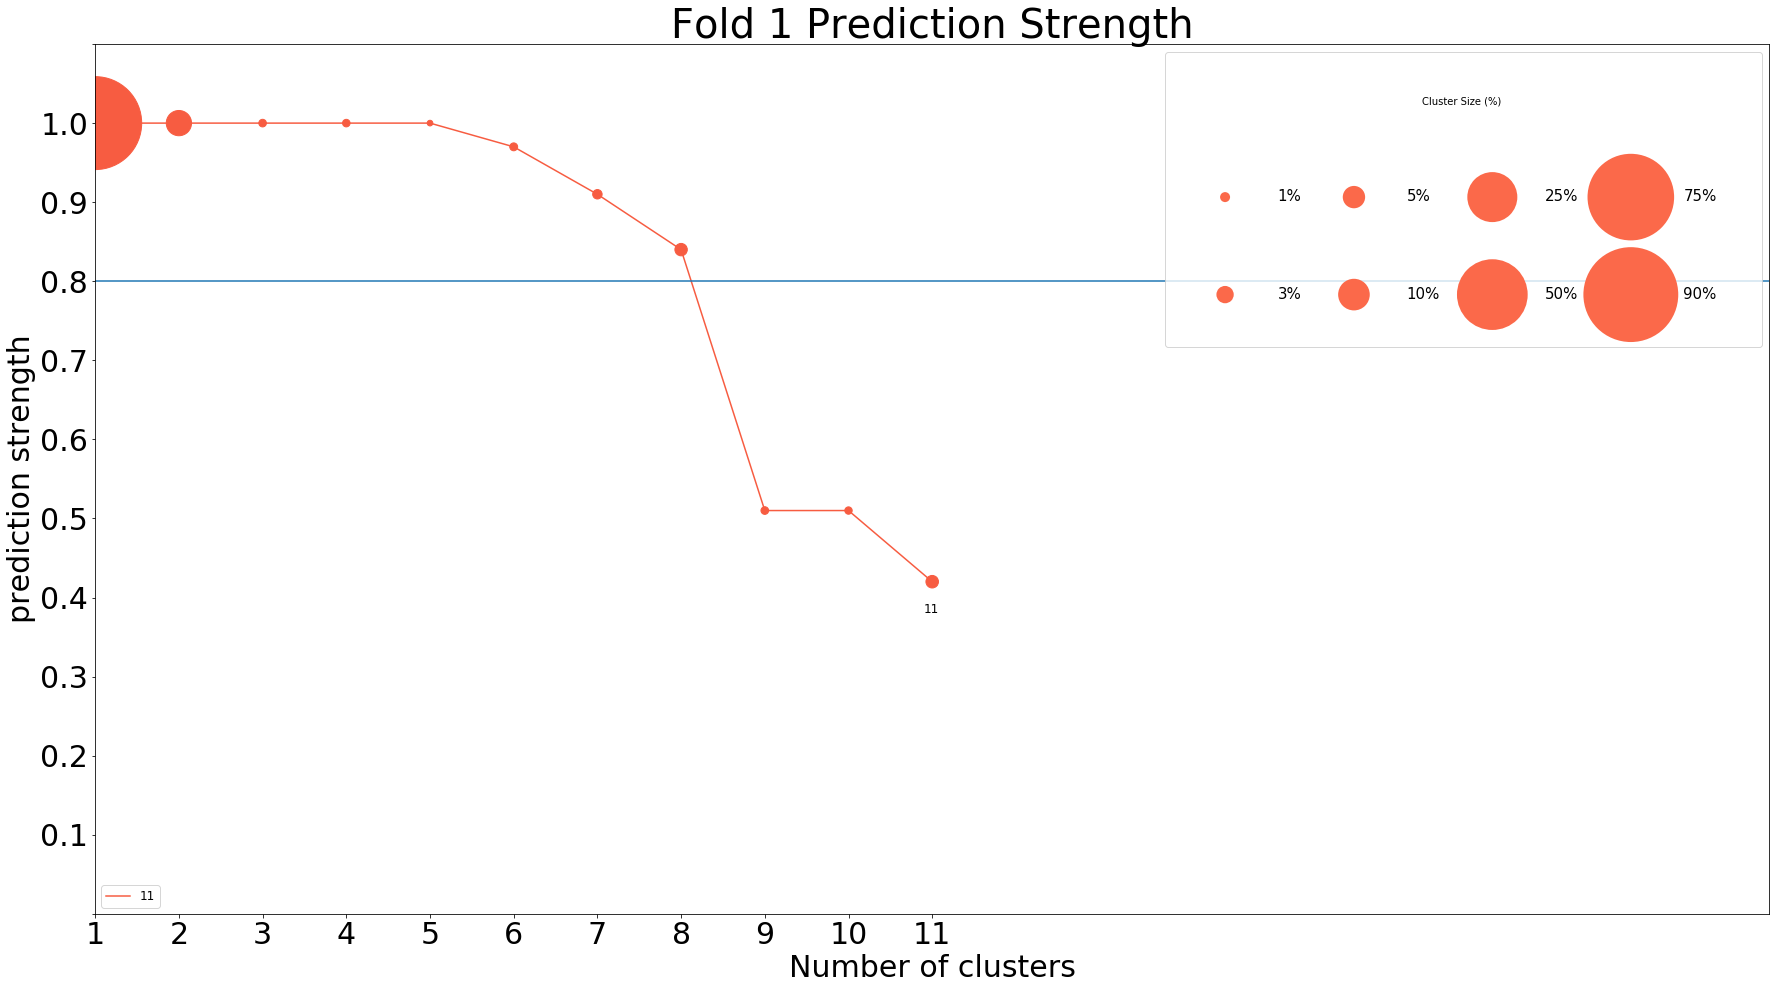

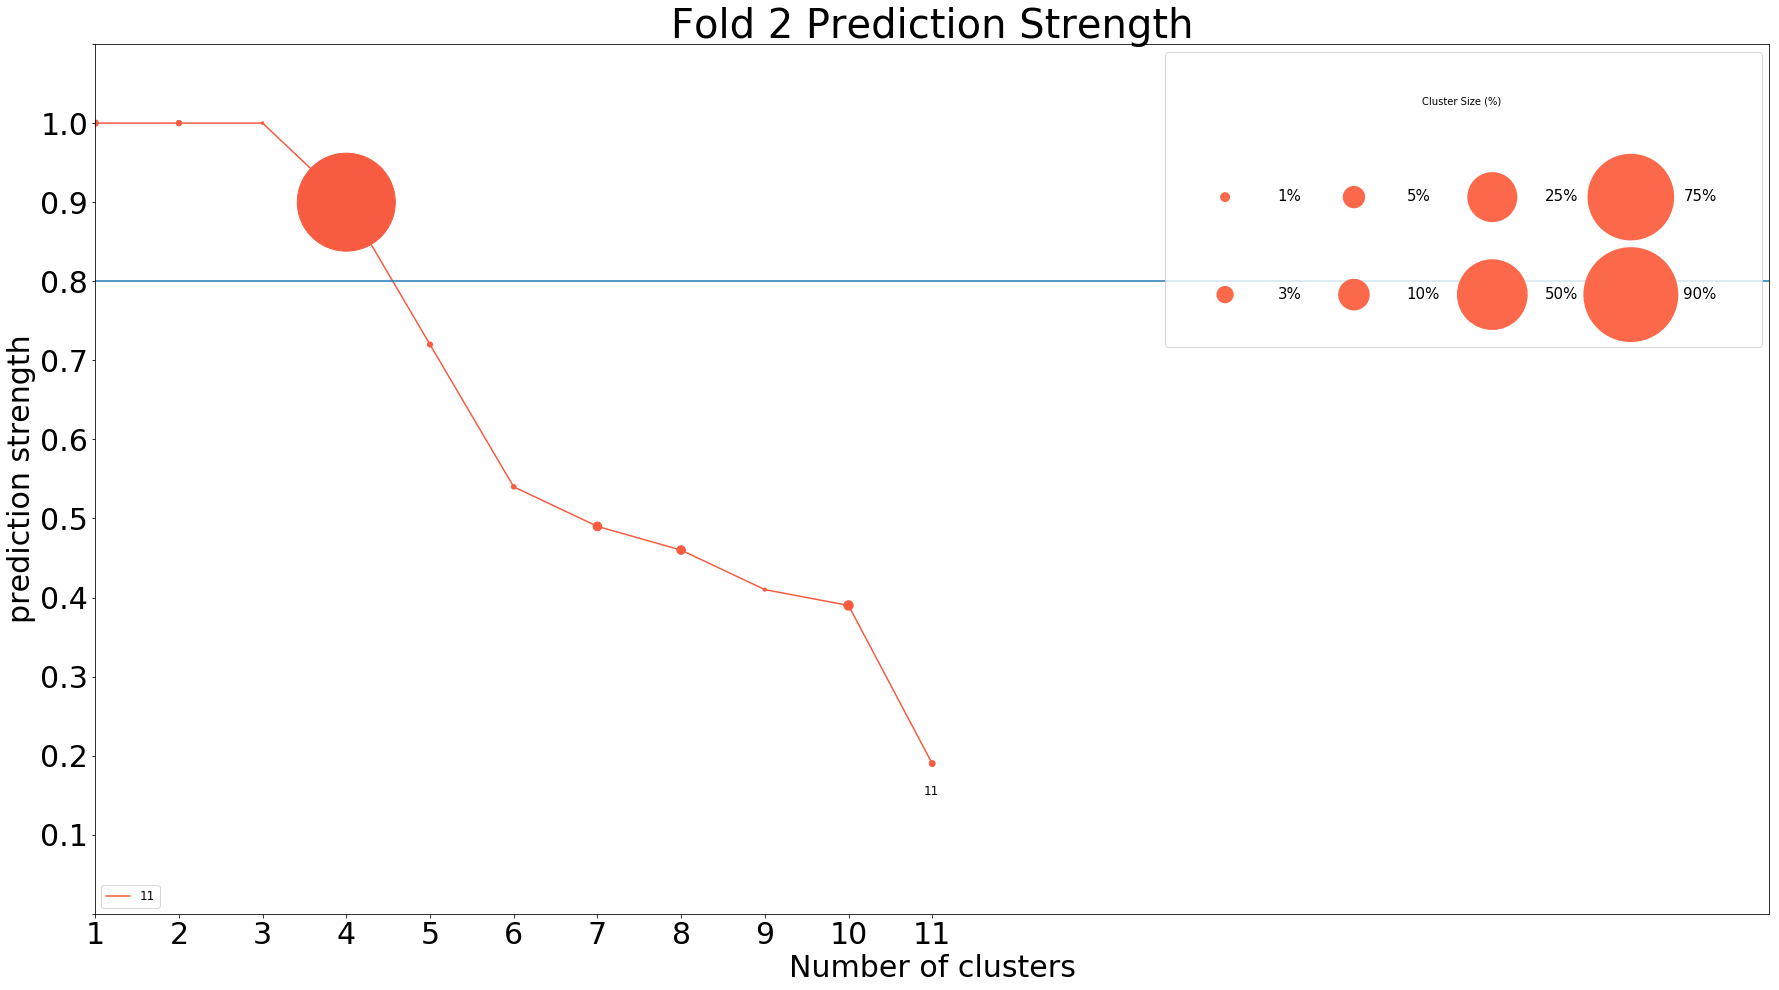

In [16]:
from ipynb.fs.defs.prediction_strength import plot_prediction_strength
plot_prediction_strength(k_predictions_strength_cv,valid_cluster_size,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 2,k_clusters=[11])

In [16]:
n_folds = 2
n_clusters = range(20)

min_ps = []
for k in n_clusters:
    min_ps.append([])

for i in range(n_folds):
    for k in n_clusters:
        ps_k_fold_i = np.amin(predictions_strengths_cv[i][k])
        min_ps[k].append(ps_k_fold_i)

In [14]:
# weighted by size of cluster 
min_ps = []
for k in n_clusters:
    i = k+1
    ps_k_fold = np.amin(k_predictions_strength_cv[i],axis = 1) * [x[np.argmin(k_predictions_strength_cv[i],axis = 1)[f]] for f,x in enumerate(np.asarray(valid_cluster_size[i]))]/np.sum(valid_cluster_size[i],axis = 1)
    min_ps.append(ps_k_fold)

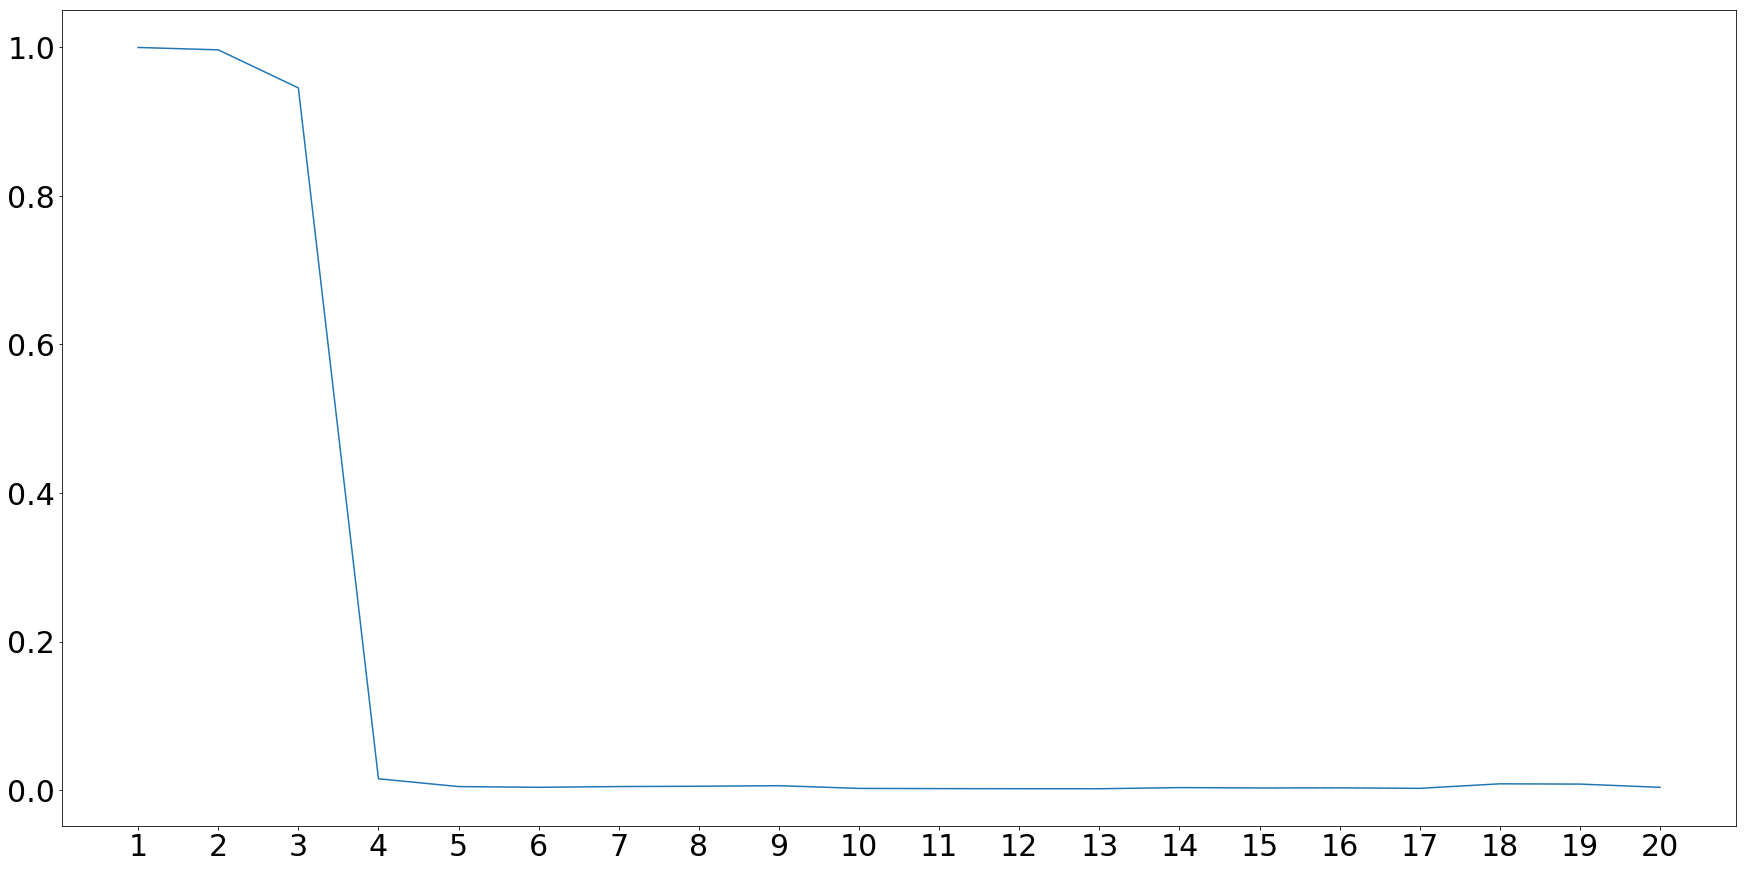

In [18]:
fig,ax = plt.subplots(figsize = (30,15))
ax.plot(np.asarray(n_clusters)+1,np.mean(min_ps,axis = 1) + np.std(min_ps,axis = 1))
ax.set_xticks(np.asarray(n_clusters)+1)

# Denoise Data based on prediction Strength and cluster
The proportion of bursts falling into cluster with low prediction strength suggest that we have some low predictive clusters with only few bursts, which might be an indicator for clustering "noise". Thats why we want to iteratively remove those bursts falling into low predictive clusters, recalculate the clustering and see wether we get an overall high prediction strength for fewer clusters.

In [17]:
def discard_bad_cluster_bursts(k_predictions_strength_cv,valid_folds, valid_fold_labels, train_fold_labels, cs, threshold = 0.8): 
    """ Remove bursts falling into clusters with low prediction strength in order to in some sense denoise the data

    Args:
        k_predictions_strength_cv (dict): Dictonary containig for each clustering with n_clusters the prediction strength for each cluster in each fold 
                                          keys = n_clusters  values = folds x n_clusters 
        valid_folds (list of nd.arrays): list of k validation set indices each with dimension n/k x m
        train_fold_labels (list of lists): list of lists containing the cluster labels for each point in training set
        valid_fold_labels (list of lists): list of lists containing the cluster labels for each point in validation set
        c (int): c (number clusters) used in clustering on which low prediction strength clusters caluclated
        threshold(int): threshold to dertermine bad clusters with low prediction strength
    Returns:
        
        valid_folds_without_bad_clusters (list of nd.arrays): list of k validation set indices after removing indices of bursts falling into clusters with low prediction strength 
        valid_fold_labels_without_bad_clusters (list of lists): list of lists containing the cluster labels for each point in validation set after removing indices of bursts falling into clusters with low prediction strength 
        train_fold_labels_without_bad_clusters (list of lists): list of lists containing the cluster labels for each point in training set after removing indices of bursts falling into clusters with low prediction strength 
        n_bad_clusters_per_fold (list): list of number of clusters below threshold per fold 
    """
    n_bad_clusters_per_fold = []
    valid_folds_without_bad_clusters = []
    valid_fold_labels_without_bad_clusters = []
    train_fold_labels_without_bad_clusters = []
    
 
    for f in range(len(valid_fold_labels)):
        c = cs[f] #clusters for each fold to calculate number of low prediction strength clusters 
        bad_clusters = np.where(k_predictions_strength_cv[c][f] < threshold)[0]
        n_bad_clusters_per_fold.append(len(bad_clusters))
        valid_fold_i = valid_folds[f]
        valid_labels_i = valid_fold_labels[f][c-1-len(bad_clusters)]
        train_labels_i = train_fold_labels[f][c-1-len(bad_clusters)]
        bad_cluster_indices = []
    
        for bad_cluster in bad_clusters:
            bad_cluster_indices += list(np.where(valid_fold_labels[f][c-1] == bad_cluster)[0])
    
        valid_fold_i = np.delete(valid_fold_i, bad_cluster_indices)
        valid_labels = np.delete(valid_labels_i, bad_cluster_indices)
        
        valid_folds_without_bad_clusters.append(valid_fold_i)
        valid_fold_labels_without_bad_clusters.append([valid_labels])
        train_fold_labels_without_bad_clusters.append([train_labels_i])
    
    return np.asarray(valid_folds_without_bad_clusters), np.asarray(valid_fold_labels_without_bad_clusters), np.asarray(train_fold_labels_without_bad_clusters), np.asarray(n_bad_clusters_per_fold)

In [17]:
init_k_clusters = 11
counter = 0
threshold = 0.8
n_bad_clusters_per_fold = [1]
n_folds = 2

sub_dir = '50_50_split/denoising/spectral_clustering/k_init=11_keep_k=11/'

In [14]:
from ipynb.fs.defs.Spectral_clustering_pipeline import spectral_clustering
from ipynb.fs.defs.prediction_strength import cross_valdation_prediction_strength

In [35]:
k_clusters = np.repeat(init_k_clusters,n_folds)
while np.sum(n_bad_clusters_per_fold) > 0 or counter == 0:
    if counter == 0:
        valid_folds_without_bad_clusters, valid_fold_labels_without_bad_clusters, train_fold_labels_without_bad_clusters, n_bad_clusters_per_fold = discard_bad_cluster_bursts(k_predictions_strength_cv, valid_folds, valid_fold_labels, train_fold_labels, k_clusters, threshold = threshold)
        prev_k_clusters = k_clusters
        k_clusters = prev_k_clusters - n_bad_clusters_per_fold

    else:
        valid_folds_without_bad_clusters, valid_fold_labels_without_bad_clusters, train_fold_labels_without_bad_clusters, n_bad_clusters_per_fold = discard_bad_cluster_bursts(k_predictions_strength_cv_without_bad_clusters, valid_folds_without_bad_clusters, valid_fold_labels_without_bad_clusters, train_fold_labels_without_bad_clusters,k_clusters, threshold = threshold)
        prev_k_clusters = k_clusters
        k_clusters = prev_k_clusters - n_bad_clusters_per_fold

    print("[%d %d] Clusters found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_bad_clusters_per_fold) + [threshold])))
    print("Look at [%d %d] Clusters in each fold!" % tuple(list(k_clusters)))

    print("Save denoised validation folds!")
    np.save(data_dir + sub_dir + 'valid_folds_denoised_%d' % counter, valid_folds_without_bad_clusters)
    np.save(data_dir + sub_dir + 'n_bad_clusters_per_fold_%d' % counter ,n_bad_clusters_per_fold)

    clusters = list(range(1,np.amax(k_clusters) + 1))
    
    train_fold_labels_without_bad_clusters = []
    valid_fold_labels_without_bad_clusters = []
    for i in range(n_folds):
        #train_labels_without_bad_clusters = spectral_clustering(data[train_fold[i]], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        valid_labels_without_bad_clusters = spectral_clustering(data[valid_folds_without_bad_clusters[i]], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        
        train_fold_labels_without_bad_clusters.append(train_fold_labels[i][:len(clusters)])
        valid_fold_labels_without_bad_clusters.append(valid_labels_without_bad_clusters)
    
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'train_fold_labels_denoised_%d' % counter,train_fold_labels_without_bad_clusters)
    np.save(data_dir + sub_dir + 'valid_fold_labels_denoised_%d' % counter ,valid_fold_labels_without_bad_clusters)

    print("Calculate Prediction Strength for each fold! ")
    predictions_strengths_without_bad_clusters, valid_fold_labels_without_bad_clusters_predicted = cross_valdation_prediction_strength(data, train_folds, valid_folds_without_bad_clusters, train_fold_labels_without_bad_clusters, valid_fold_labels_without_bad_clusters)
    print("Done!")

    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_without_bad_clusters_%d' % counter , predictions_strengths_without_bad_clusters)
    np.save(data_dir + sub_dir + 'valid_fold_labels_without_bad_clusters_%d_predicted' % counter, valid_fold_labels_without_bad_clusters_predicted)

    k_predictions_strength_cv_without_bad_clusters, k_valid_fold_labels_predicted_without_bad_clusters, k_valid_fold_labels_without_bad_clusters, valid_cluster_size_without_bad_clusters, valid_cluster_size_predicted_without_bad_clusters = calculate_prediction_strength_per_k(predictions_strengths_without_bad_clusters,valid_fold_labels_without_bad_clusters,valid_fold_labels_without_bad_clusters_predicted, strength_sorted = True)
    
    np.save(data_dir + sub_dir + 'k_clusters_%d' % counter, k_clusters)
    
    counter += 1

[4 3] Clusters found in each fold with Prediction Strength below threshold = 0.80!
Look at [11 11] Clusters in each fold!
Save denoised validation folds!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save labels!
Calculate Prediction Strength for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
[2 2] Clusters found in each fold with Prediction Strength below threshold = 0.80!
Look at [11 11] Clusters in each fold!
Save denoised validation folds!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save labels!
Calculate Prediction Strength for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
[1 2] Clusters found i

In [36]:
print(counter)

12


In [14]:
sub_dir = '/50_50_split/denoising/spectral_clustering/k_init=11_keep_k=11/'

In [16]:
counter = 12 #6 #3 #2   #12
threshold = 0.8

valid_folds_without_bad_clusters = list(np.load(data_dir + sub_dir + 'valid_folds_denoised_%d.npy' % (counter - 1),allow_pickle=True))
n_bad_clusters_per_fold = list(np.load(data_dir + sub_dir +'n_bad_clusters_per_fold_%d.npy' % (counter - 1),allow_pickle=True))
train_fold_labels_without_bad_clusters = list(np.load(data_dir + sub_dir +'train_fold_labels_denoised_%d.npy' % (counter - 2),allow_pickle=True))
valid_fold_labels_without_bad_clusters = list(np.load(data_dir + sub_dir +'valid_fold_labels_denoised_%d.npy' % (counter - 2),allow_pickle=True))
predictions_strengths_without_bad_clusters = list(np.load(data_dir + sub_dir + 'predictions_strengths_without_bad_clusters_%d.npy' % (counter - 1),allow_pickle=True))
valid_fold_labels_without_bad_clusters_predicted = list(np.load(data_dir + sub_dir +'valid_fold_labels_without_bad_clusters_%d_predicted.npy' % (counter - 1),allow_pickle=True))

k_predictions_strength_cv_without_bad_clusters, k_valid_fold_labels_predicted_without_bad_clusters, k_valid_fold_labels_without_bad_clusters, valid_cluster_size_without_bad_clusters, valid_cluster_size_predicted_without_bad_clusters = calculate_prediction_strength_per_k(predictions_strengths_without_bad_clusters,valid_fold_labels_without_bad_clusters,valid_fold_labels_without_bad_clusters_predicted, strength_sorted = True)
k_clusters = np.asarray(list(np.load(data_dir + sub_dir +'k_clusters_%d.npy' % (counter - 2),allow_pickle=True)))#np.asarray([5,10,11,10,12]) #np.repeat(init_k_clusters,5)
#prev_k_clusters = np.asarray(list(np.load(data_dir + sub_dir +'k_clusters_%d.npy' % (counter - 3),allow_pickle=True)))
prev_k_clusters = init_k_clusters
print("[%d %d] Clusters found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_bad_clusters_per_fold) + [threshold])))
print("Look at [%d %d] Clusters in each fold!" % tuple(list(k_clusters)))

[0 0] Clusters found in each fold with Prediction Strength below threshold = 0.80!
Look at [11 11] Clusters in each fold!


In [120]:
for i, fold in  enumerate(valid_folds_without_bad_clusters):
    print("Validation fold %d size reduced from %d bursts to %d bursts. Reduction of %.2f %%!" % (i+1, len(valid_folds[i]), len(fold), np.round((len(valid_folds[i]) - len(fold))/len(valid_folds[i]) ,4) * 100))

Validation fold 1 size reduced from 6546 bursts to 6389 bursts. Reduction of 2.40 %!
Validation fold 2 size reduced from 6546 bursts to 6050 bursts. Reduction of 7.58 %!


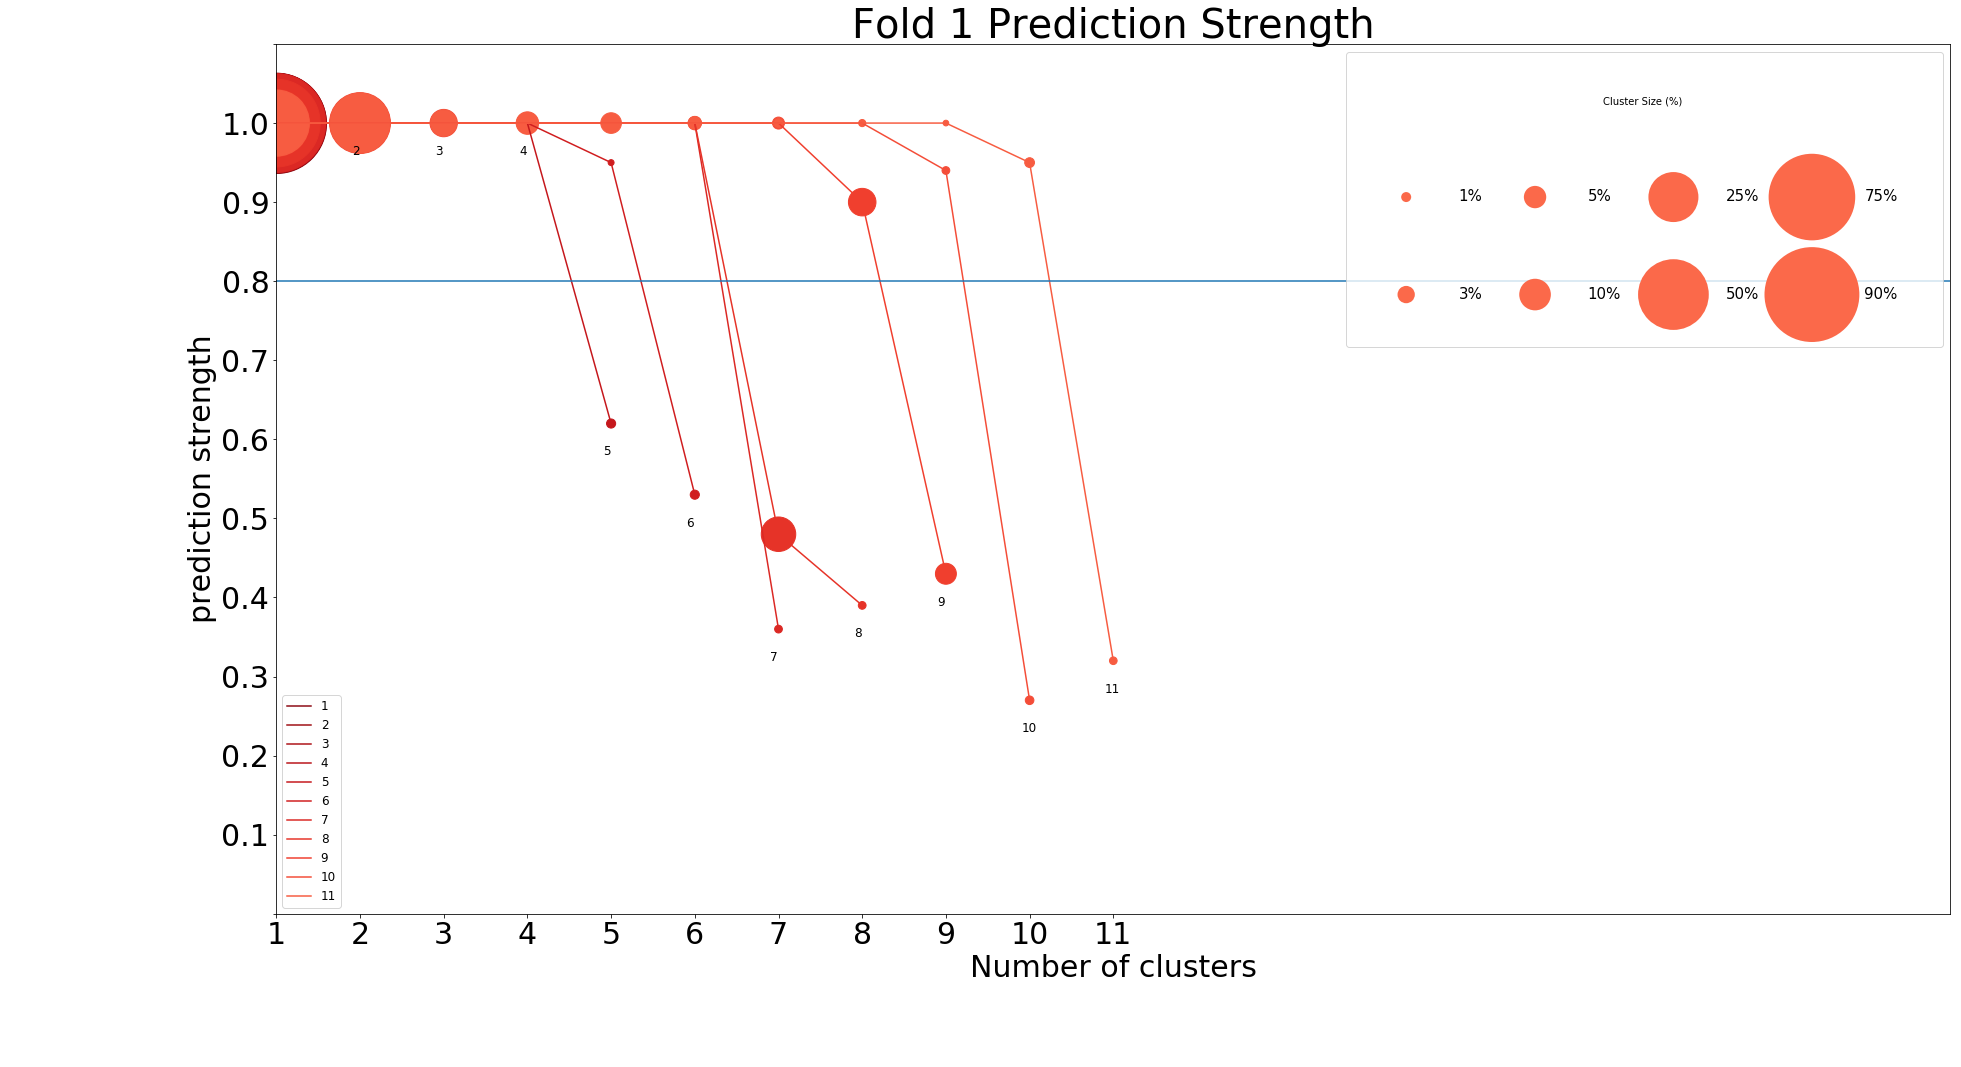

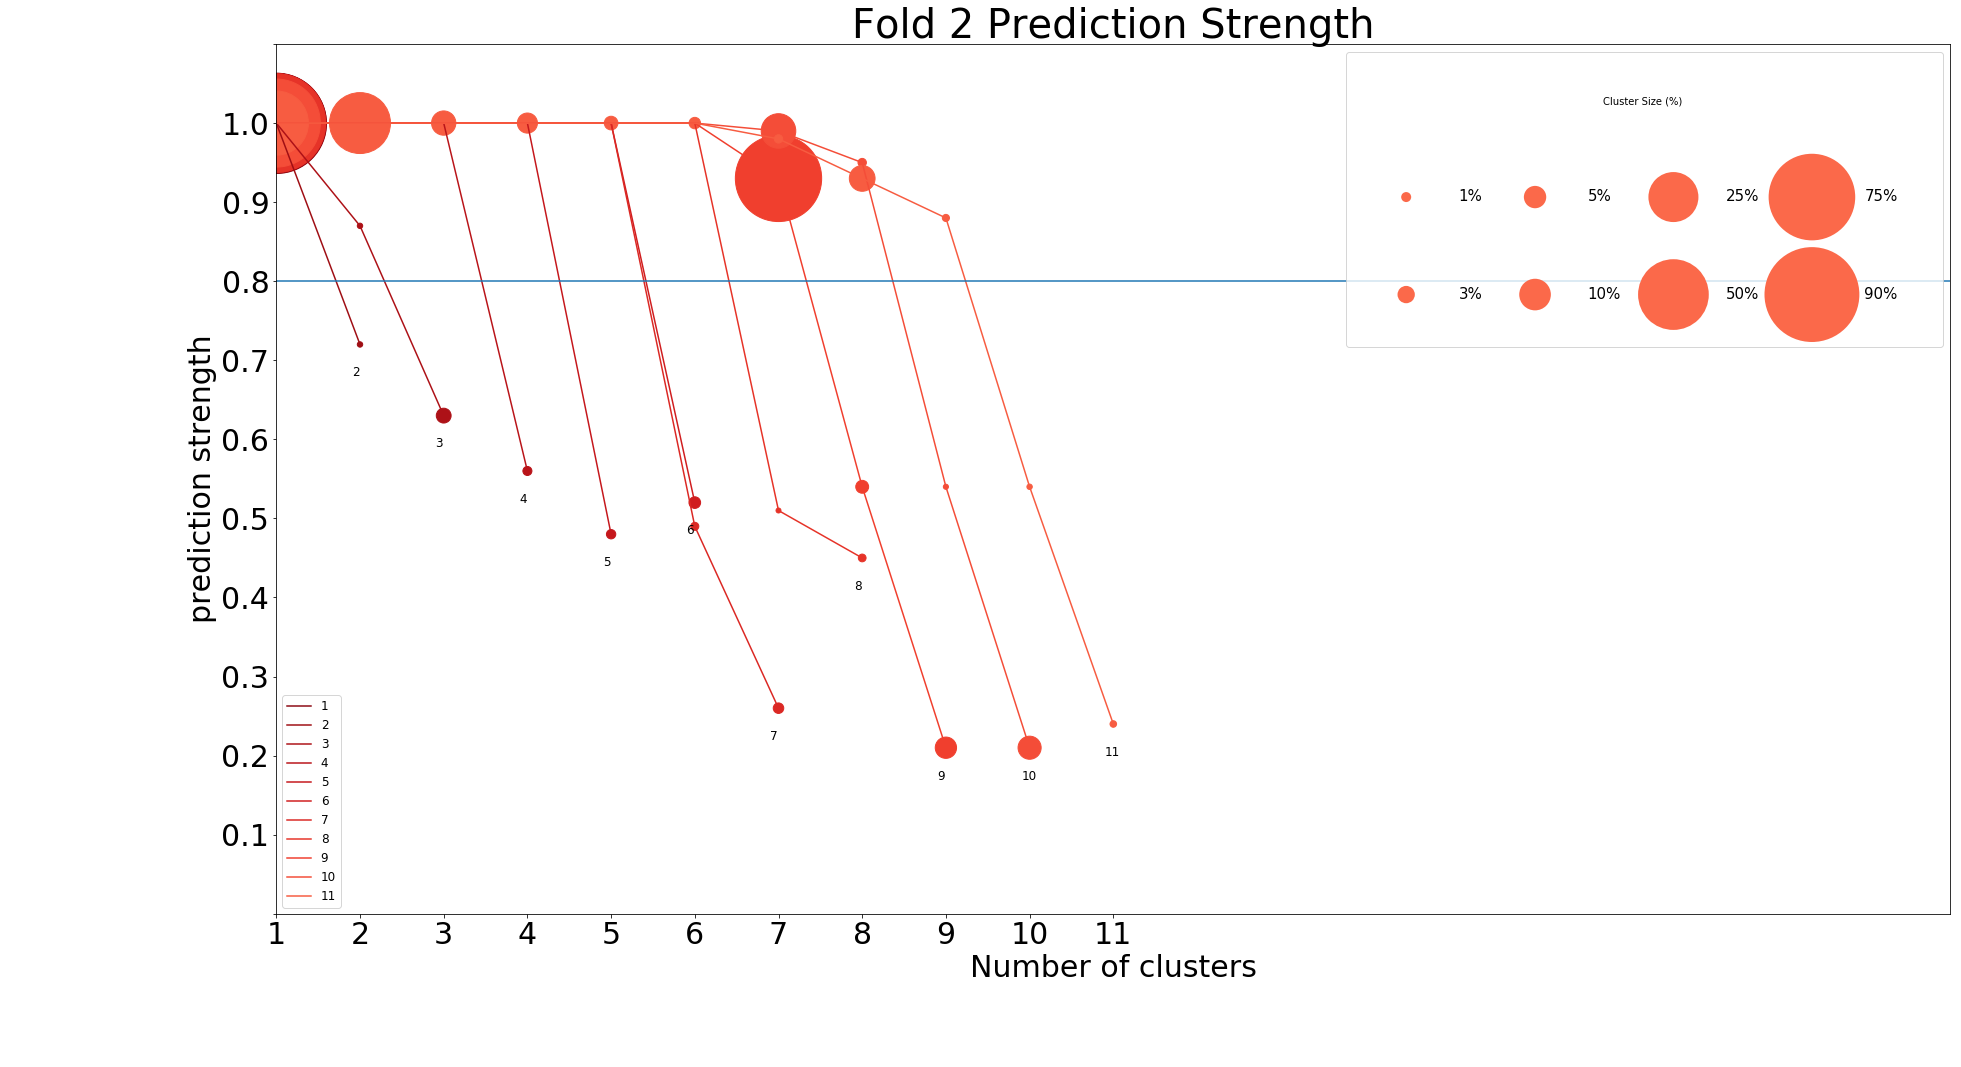

In [121]:
from ipynb.fs.defs.prediction_strength import plot_prediction_strength
plot_prediction_strength(k_predictions_strength_cv_without_bad_clusters,valid_cluster_size_without_bad_clusters,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 2)

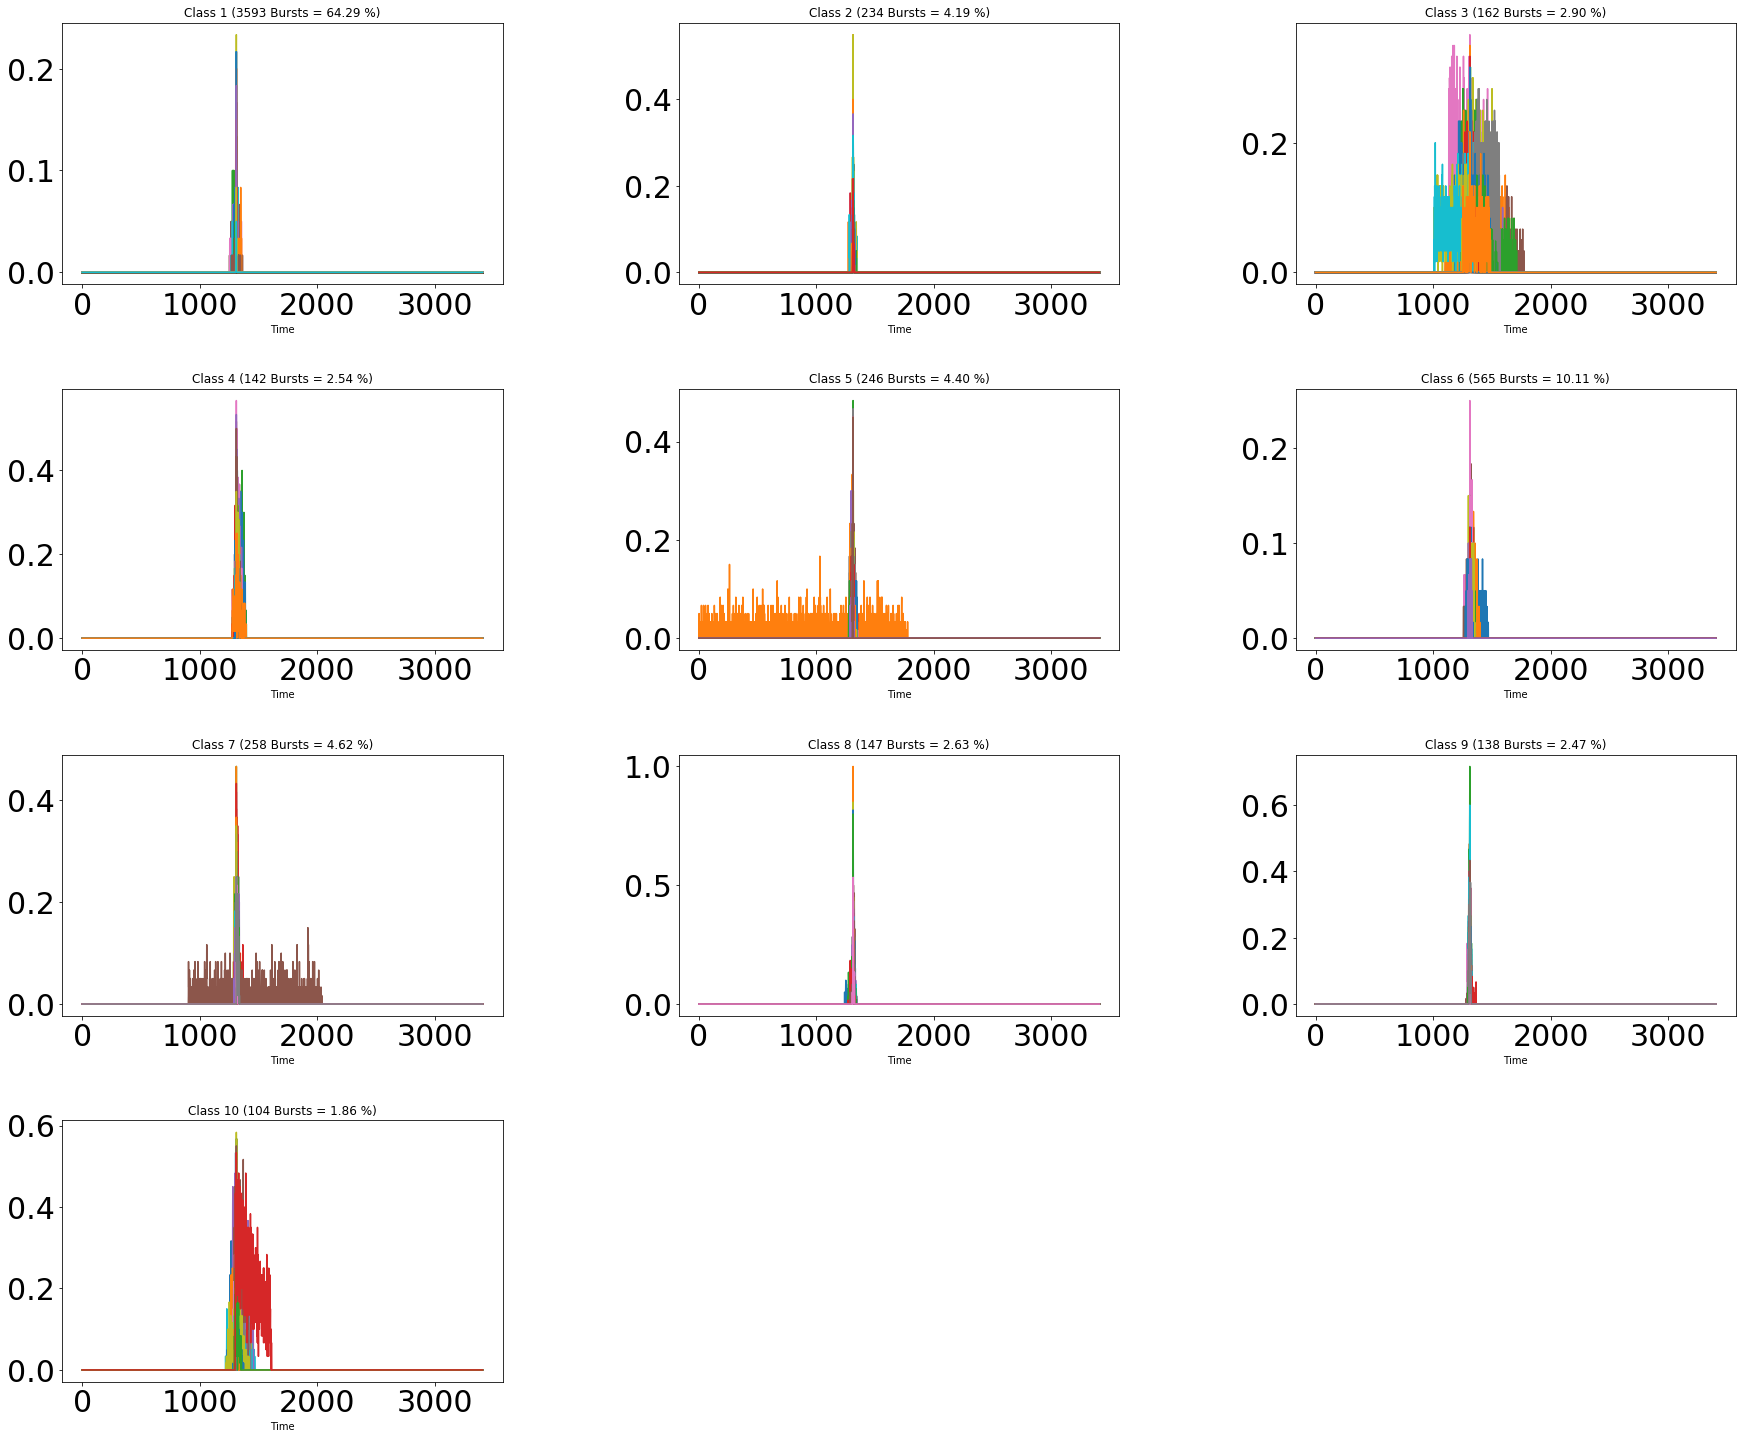

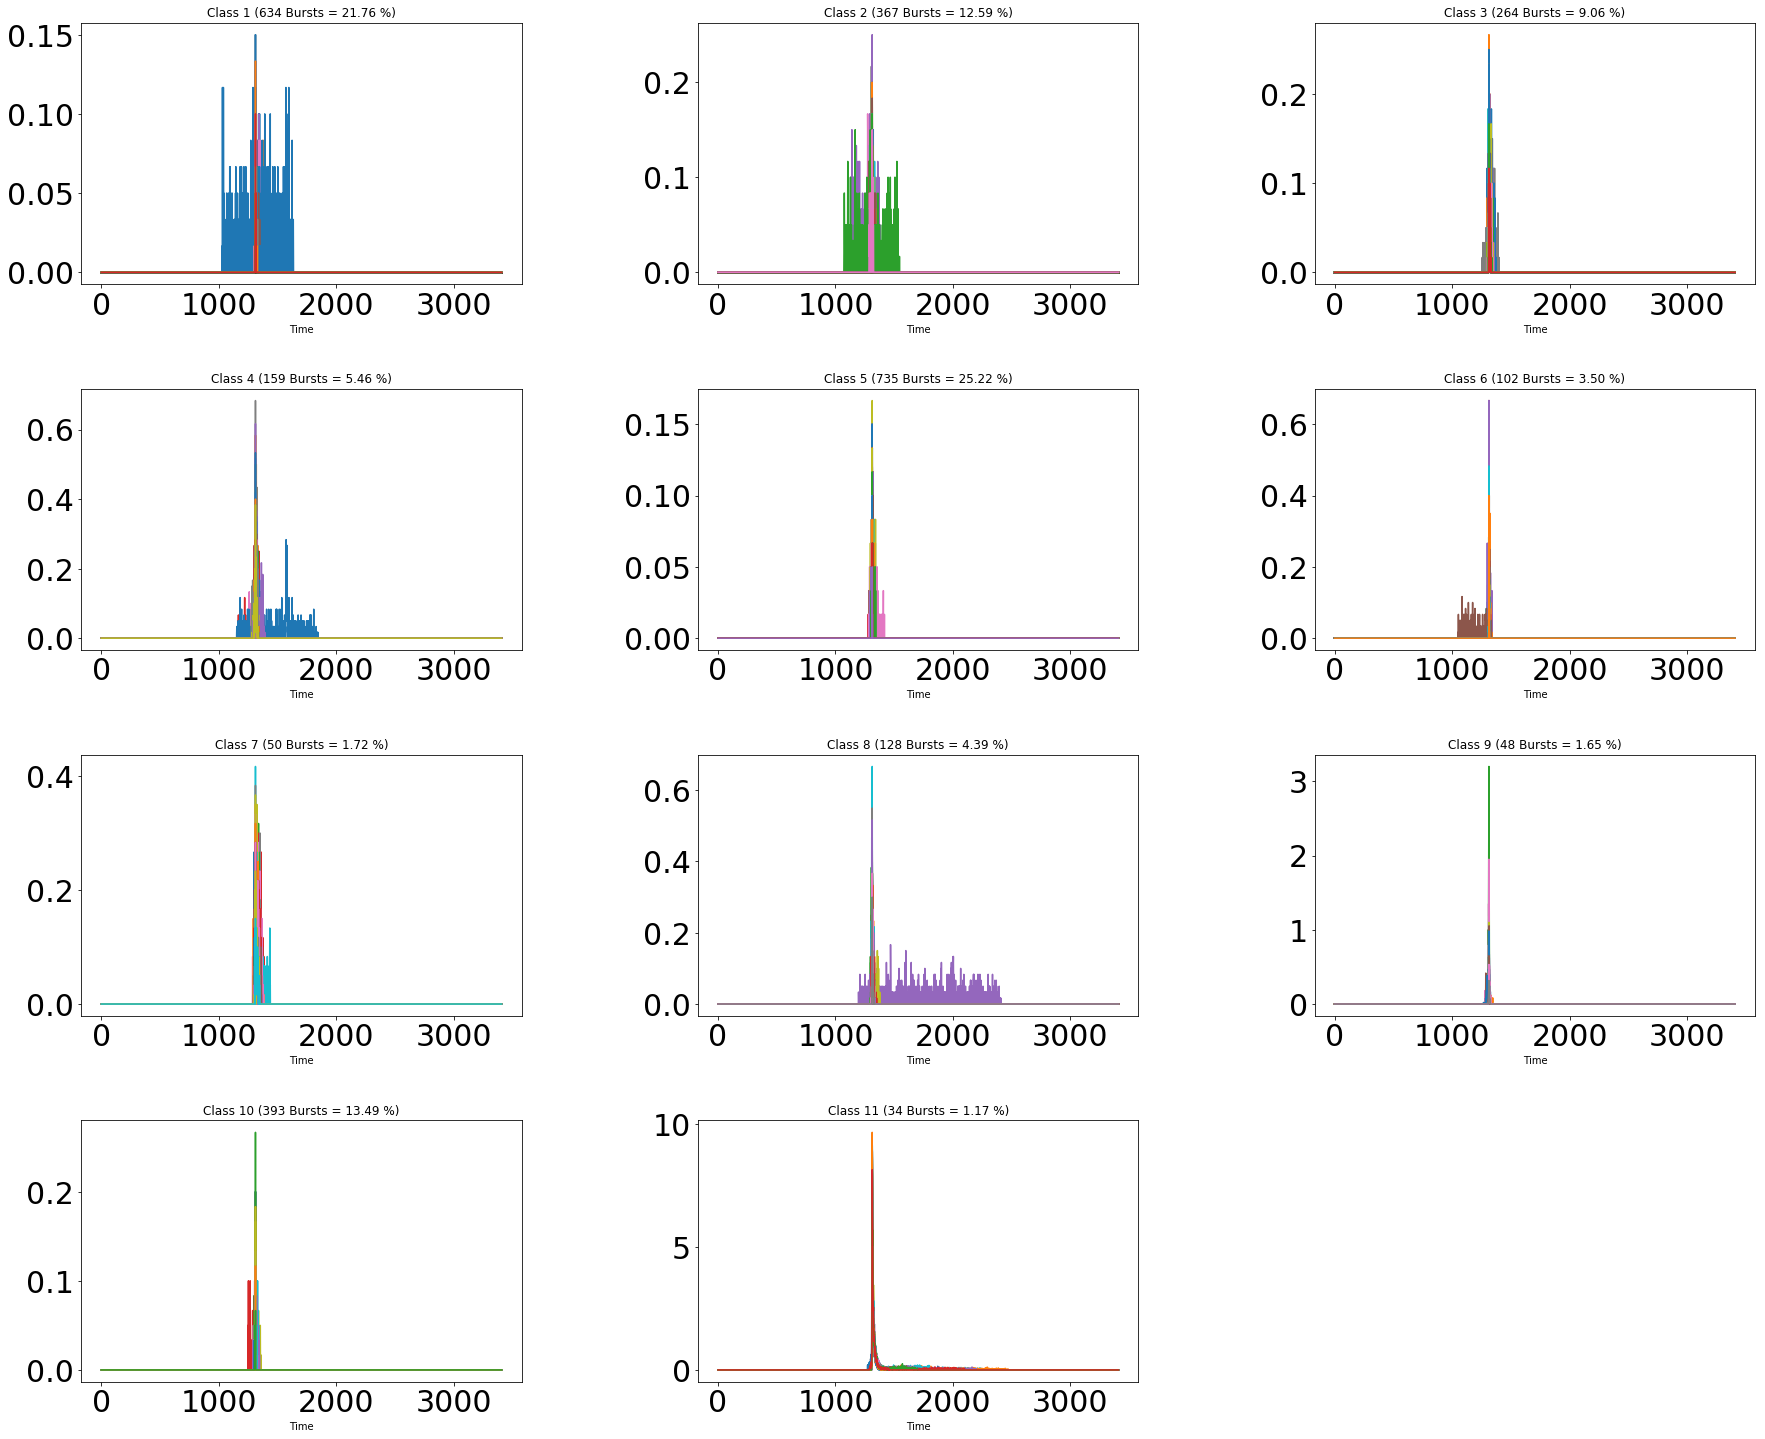

In [111]:
from ipynb.fs.defs.prediction_strength import plot_cluster_examples
k_clusters_fold = [10,11]
for i,valid_fold_without_bad_clusters in enumerate(valid_folds_without_bad_clusters):
    k_clusters = k_clusters_fold[i]
    plot_cluster_examples(data[valid_fold_without_bad_clusters], valid_fold_labels_without_bad_clusters[i][k_clusters-1], k_clusters)

In [23]:
n_bad_clusters_per_fold_and_iteration = []
valid_folds_denoised_per_iteration = []

for file in np.sort(os.listdir(data_dir + sub_dir)):
    if file.startswith("n_bad_clusters_per_fold_"):
        print(file)
        n_bad_clusters_per_fold_and_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))
    if file.startswith("valid_folds_denoised_"):
        print(file)
        valid_folds_denoised_per_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

n_bad_clusters_per_fold_and_iteration.append([0 for i in n_bad_clusters_per_fold_and_iteration[0]])

n_bad_clusters_per_fold_0.npy
n_bad_clusters_per_fold_1.npy
n_bad_clusters_per_fold_2.npy
n_bad_clusters_per_fold_3.npy
n_bad_clusters_per_fold_4.npy
n_bad_clusters_per_fold_5.npy
valid_folds_denoised_0.npy
valid_folds_denoised_1.npy
valid_folds_denoised_2.npy
valid_folds_denoised_3.npy
valid_folds_denoised_4.npy
valid_folds_denoised_5.npy


In [47]:
print(n_bad_clusters_per_fold_and_iteration)

[[4, 3], [2, 1], [1, 2], [1, 1], [0, 1], [0, 0], [0, 0]]


In [24]:
k_clusters = np.asarray([init_k_clusters, init_k_clusters])
k_clusters_per_iteration = [k_clusters]
reduction_in_percent_per_iteration = [np.repeat(0, len(k_clusters))]

for i, n_bad_clusters in enumerate(n_bad_clusters_per_fold_and_iteration[:-1]):
    print("Iteration %d " % (i+1))
    print("Removed [%d %d] Clusters per fold " % tuple(list(n_bad_clusters)))
    k_clusters = k_clusters - n_bad_clusters
    k_clusters_per_iteration += [k_clusters]
    print("Recalculated Spectral clustering with [%d %d]"  % tuple(list(k_clusters)))
    reduction_in_percent_i = []

    for j, fold in  enumerate(valid_folds_denoised_per_iteration[i]):
        reduction_percent = np.round((len(valid_folds[j]) - len(fold))/len(valid_folds[j]) ,4) * 100
        reduction_in_percent_i.append(reduction_percent)
        print("Validation fold %d size reduced from %d bursts to %d bursts. Reduction of %.2f %%!" % (j+1, len(valid_folds[j]), len(fold), reduction_percent))

    print([len(fold) for fold in valid_folds_denoised_per_iteration[i]])    
    reduction_in_percent_per_iteration.append(reduction_in_percent_i)

Iteration 1 
Removed [4 3] Clusters per fold 
Recalculated Spectral clustering with [7 8]
Validation fold 1 size reduced from 6546 bursts to 6484 bursts. Reduction of 0.95 %!
Validation fold 2 size reduced from 6546 bursts to 6509 bursts. Reduction of 0.57 %!
[6484, 6509]
Iteration 2 
Removed [2 1] Clusters per fold 
Recalculated Spectral clustering with [5 7]
Validation fold 1 size reduced from 6546 bursts to 6440 bursts. Reduction of 1.62 %!
Validation fold 2 size reduced from 6546 bursts to 6493 bursts. Reduction of 0.81 %!
[6440, 6493]
Iteration 3 
Removed [1 2] Clusters per fold 
Recalculated Spectral clustering with [4 5]
Validation fold 1 size reduced from 6546 bursts to 6392 bursts. Reduction of 2.35 %!
Validation fold 2 size reduced from 6546 bursts to 6442 bursts. Reduction of 1.59 %!
[6392, 6442]
Iteration 4 
Removed [1 1] Clusters per fold 
Recalculated Spectral clustering with [3 4]
Validation fold 1 size reduced from 6546 bursts to 6325 bursts. Reduction of 3.38 %!
Valida

Text(0.5,0,'Iteration')

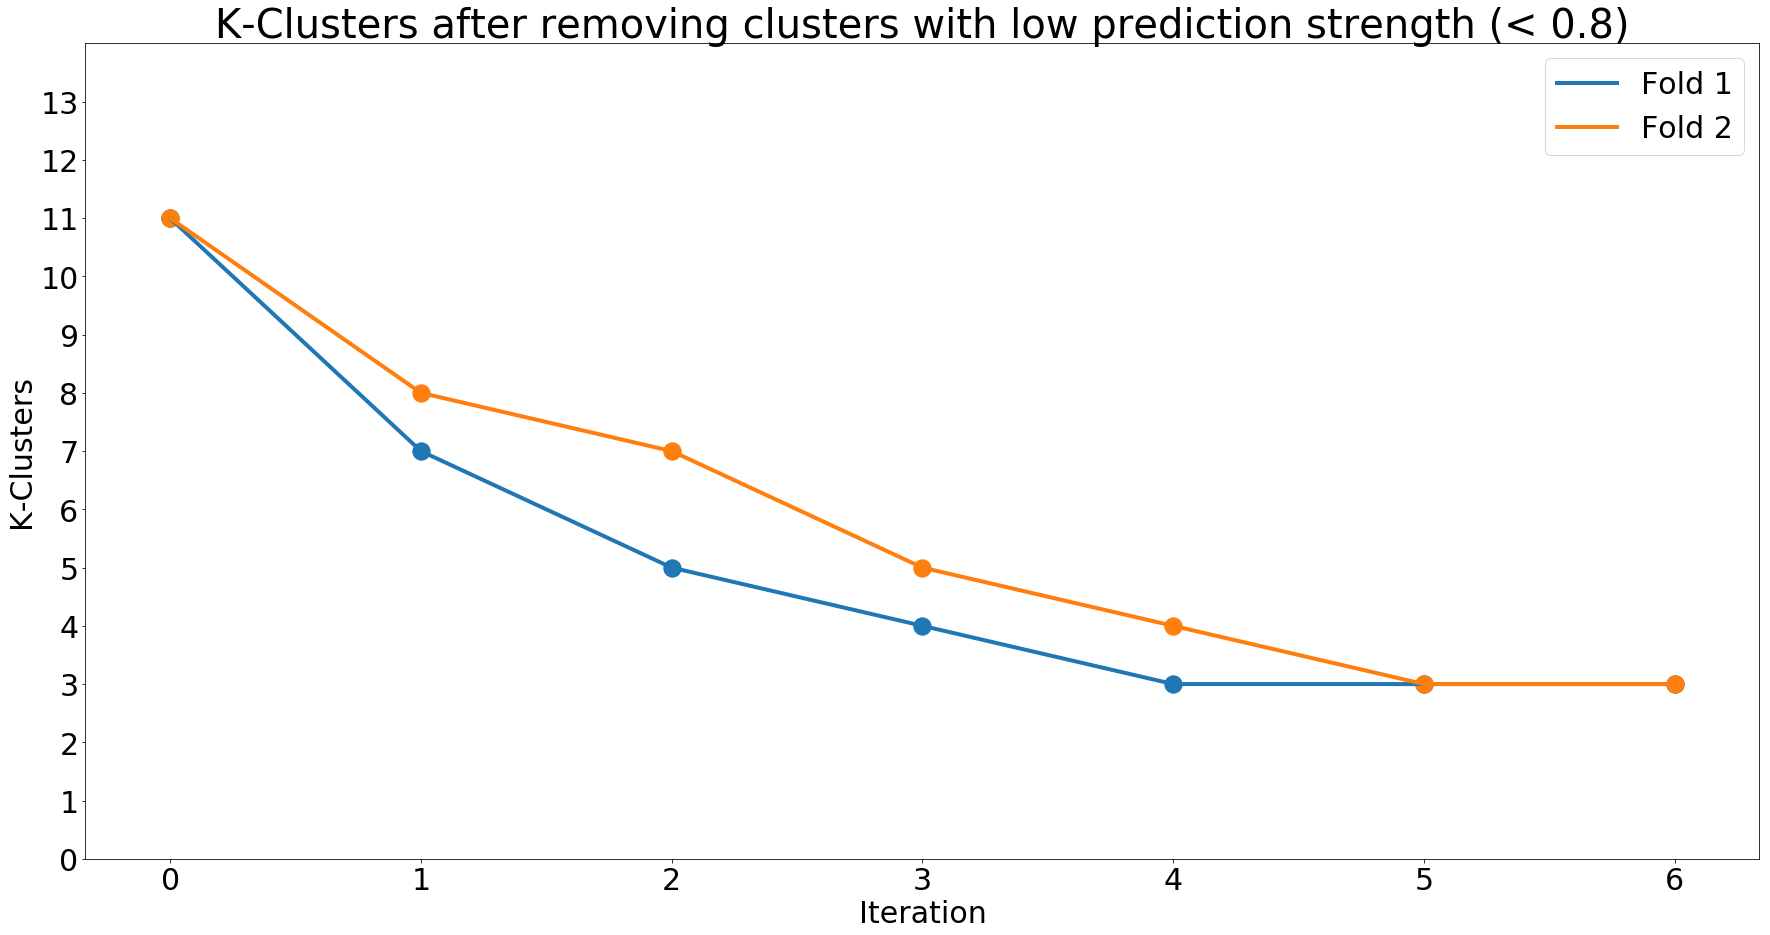

In [35]:
n_folds = 2
fig, ax = plt.subplots(figsize=(30,15))
color = ["C%d" %i for i in range(10)]
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(k_clusters_per_iteration))
for i in range(n_folds): # per fold 
    ax.scatter(iterations, np.asarray(k_clusters_per_iteration)[:,i], s = 300, color = color[i])
    ax.plot(iterations, np.asarray(k_clusters_per_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4,color = color[i])
ax.legend(fontsize = 30)
ax.set_title("K-Clusters after removing clusters with low prediction strength (< 0.8)", fontsize = 40)
ax.set_ylim((0,14))
ax.set_yticks(range(0,14))
ax.set_xticks(range(len(n_bad_clusters_per_fold_and_iteration)))
ax.set_ylabel("K-Clusters", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)

In [36]:
iterations = range(len(n_bad_clusters_per_fold_and_iteration) + 1)
print(n_bad_clusters_per_fold_and_iteration)
print(iterations)

[[4, 3], [2, 1], [1, 2], [1, 1], [0, 1], [0, 0], [0, 0]]
range(0, 8)


[[4, 3], [2, 1], [1, 2], [1, 1], [0, 1], [0, 0], [0, 0]]


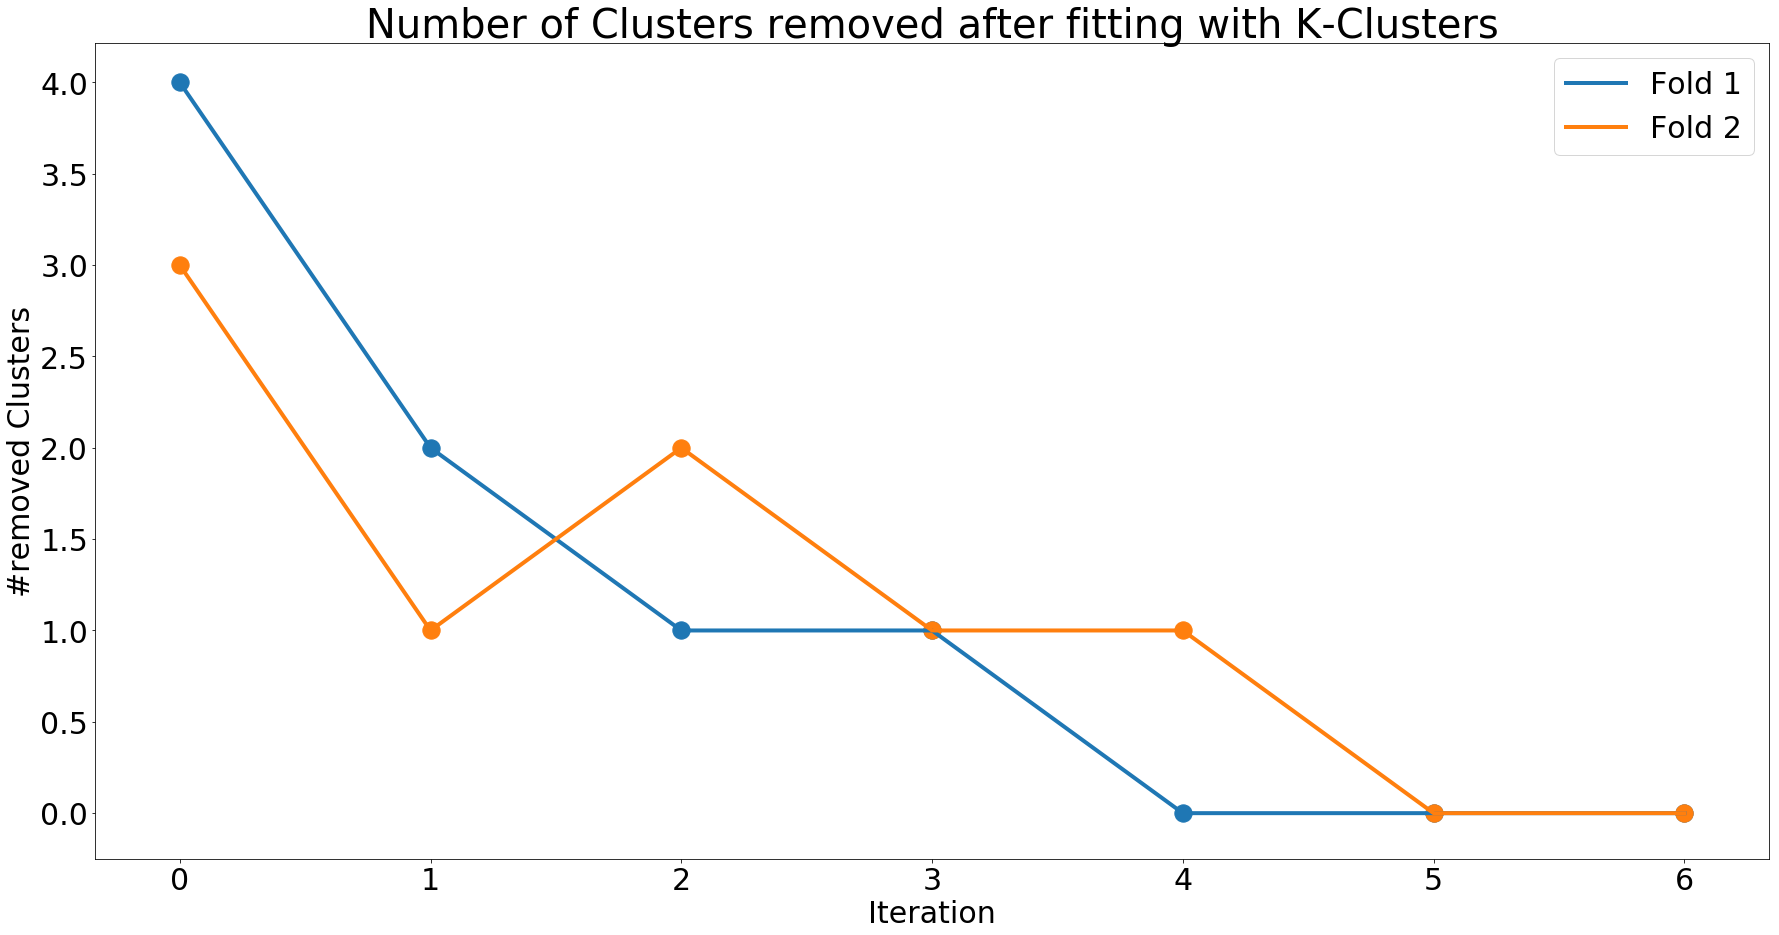

In [37]:
n_folds = 2
fig, ax = plt.subplots(figsize=(30,15))
color = ["C%d" %i for i in range(10)]
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 

iterations = range(len(n_bad_clusters_per_fold_and_iteration))
print(n_bad_clusters_per_fold_and_iteration)
for i in range(n_folds): # per fold 
    ax.scatter(iterations, np.asarray(n_bad_clusters_per_fold_and_iteration)[:,i], s = 300, color = color[i])
    ax.plot(iterations, np.asarray(n_bad_clusters_per_fold_and_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4,color = color[i])
ax.legend(fontsize = 30)
ax.set_title("Number of Clusters removed after fitting with K-Clusters", fontsize = 40)
#ax.set_ylim((0,14))
#ax.set_yticks(range(0,14))
ax.set_ylabel("#removed Clusters", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)
ax.set_xticks(range(len(n_bad_clusters_per_fold_and_iteration)))

[array([0, 0]), [0.94999999999999996, 0.57000000000000006], [1.6199999999999999, 0.80999999999999994], [2.3500000000000001, 1.5900000000000001], [3.3799999999999999, 1.8800000000000001], [3.3799999999999999, 2.4699999999999998], [3.3799999999999999, 2.4699999999999998]]


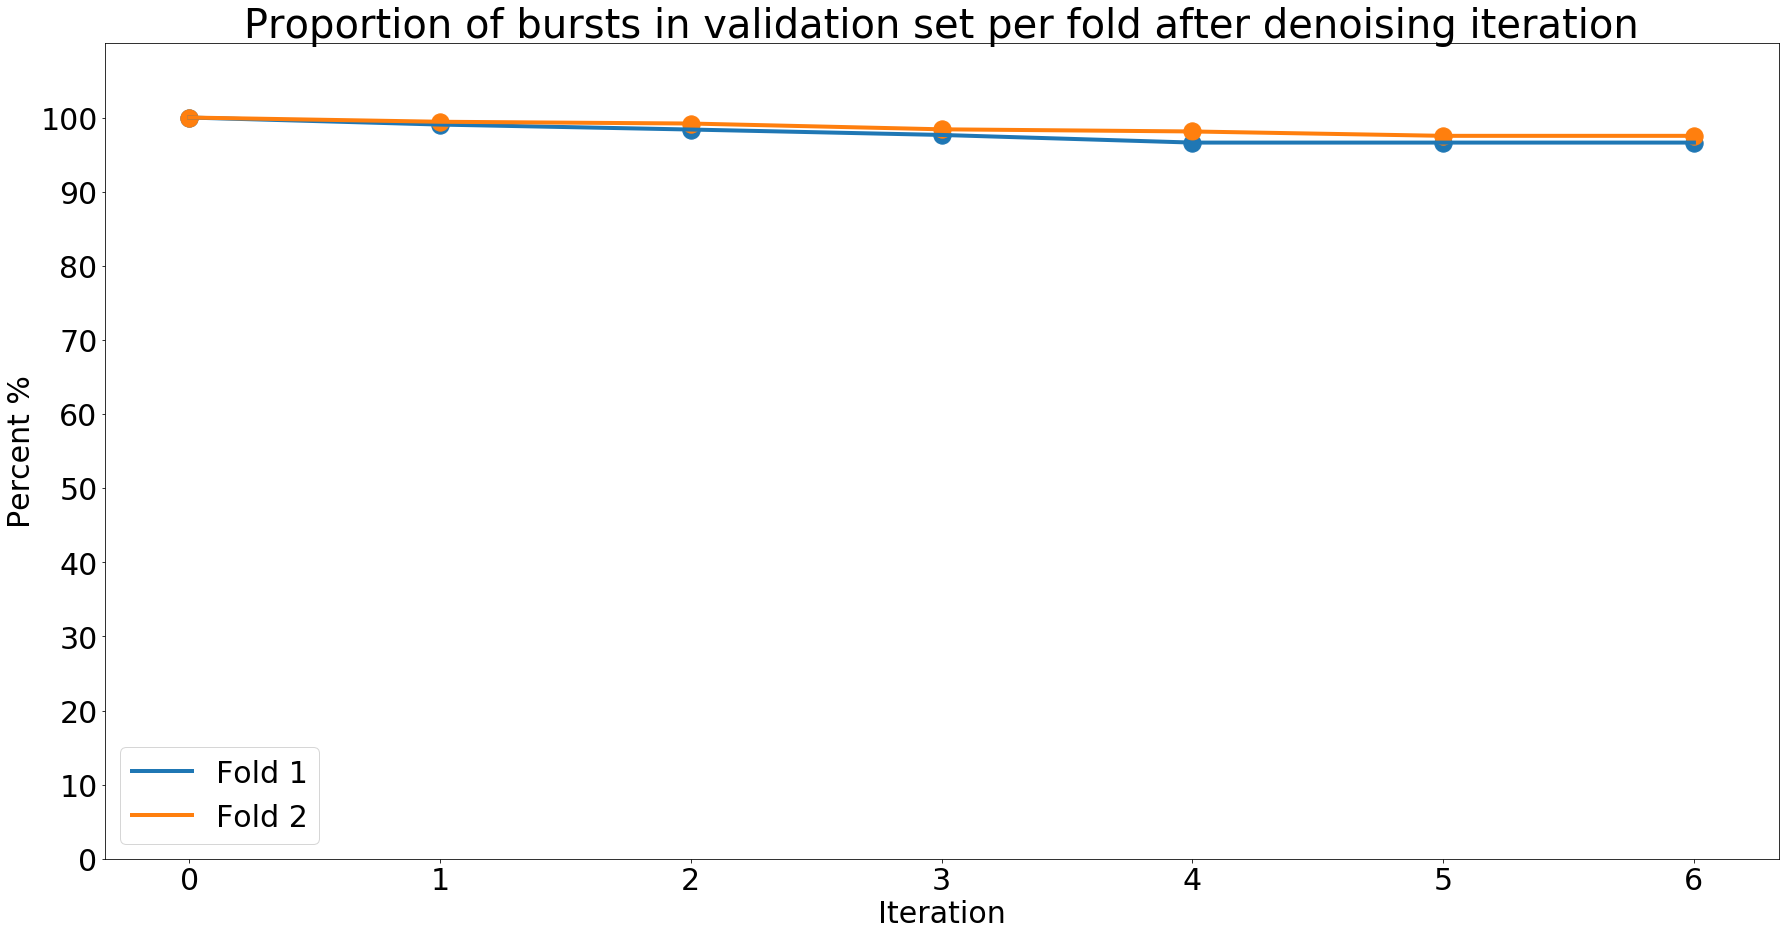

In [38]:
n_folds = 2
print(reduction_in_percent_per_iteration)
fig, ax = plt.subplots(figsize=(30,15))
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(reduction_in_percent_per_iteration))
for i in range(n_folds): # per fold 
    ax.scatter(iterations, 100 - np.asarray(reduction_in_percent_per_iteration)[:,i], s = 300,color = color[i])
    ax.plot(iterations, 100 - np.asarray(reduction_in_percent_per_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4, color = color[i])
ax.legend(fontsize = 30)
ax.set_title("Proportion of bursts in validation set per fold after denoising iteration", fontsize = 40)
ax.set_ylabel("Percent %", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)
ax.set_ylim((0,110))
ax.set_yticks(range(0,110,10))

## Disacarded Bursts based on low prediction strength clusters 

In [13]:
n_folds = len(valid_folds)
discarded_burst_indices = [list(valid_fold) for valid_fold in valid_folds]
for i in range(n_folds):
    for idx in valid_folds_without_bad_clusters[i]:
        discarded_burst_indices[i].remove(idx)

NameError: name 'valid_folds_without_bad_clusters' is not defined

In [26]:
n_folds = 2
k_clusters_fold = [11,11]
cluster_burst_dict_fold1 = {}
cluster_burst_dict_fold2 = {}

for f in range(n_folds):
    k_clusters = k_clusters_fold[f]
    for c in np.unique(train_fold_labels[f][k_clusters-1]):
        if f == 0:
            cluster_burst_dict_fold1[c] = train_folds[f][np.where(train_fold_labels[f][k_clusters-1] == c)]
        else: 
            cluster_burst_dict_fold2[c] = train_folds[f][np.where(train_fold_labels[f][k_clusters-1] == c)]

In [27]:
discarded_burst_train_labels_1 = []
discarded_burst_train_labels_2 = []
for f in range(n_folds):
    for discarded_burst_i in discarded_burst_indices[f]:
        for key in range(k_clusters_fold[f]):
            if f == 0:
                if discarded_burst_i in cluster_burst_dict_fold2[key]:
                    discarded_burst_train_labels_1.append(key)
            else:
                if discarded_burst_i in cluster_burst_dict_fold1[key]:
                    discarded_burst_train_labels_2.append(key)

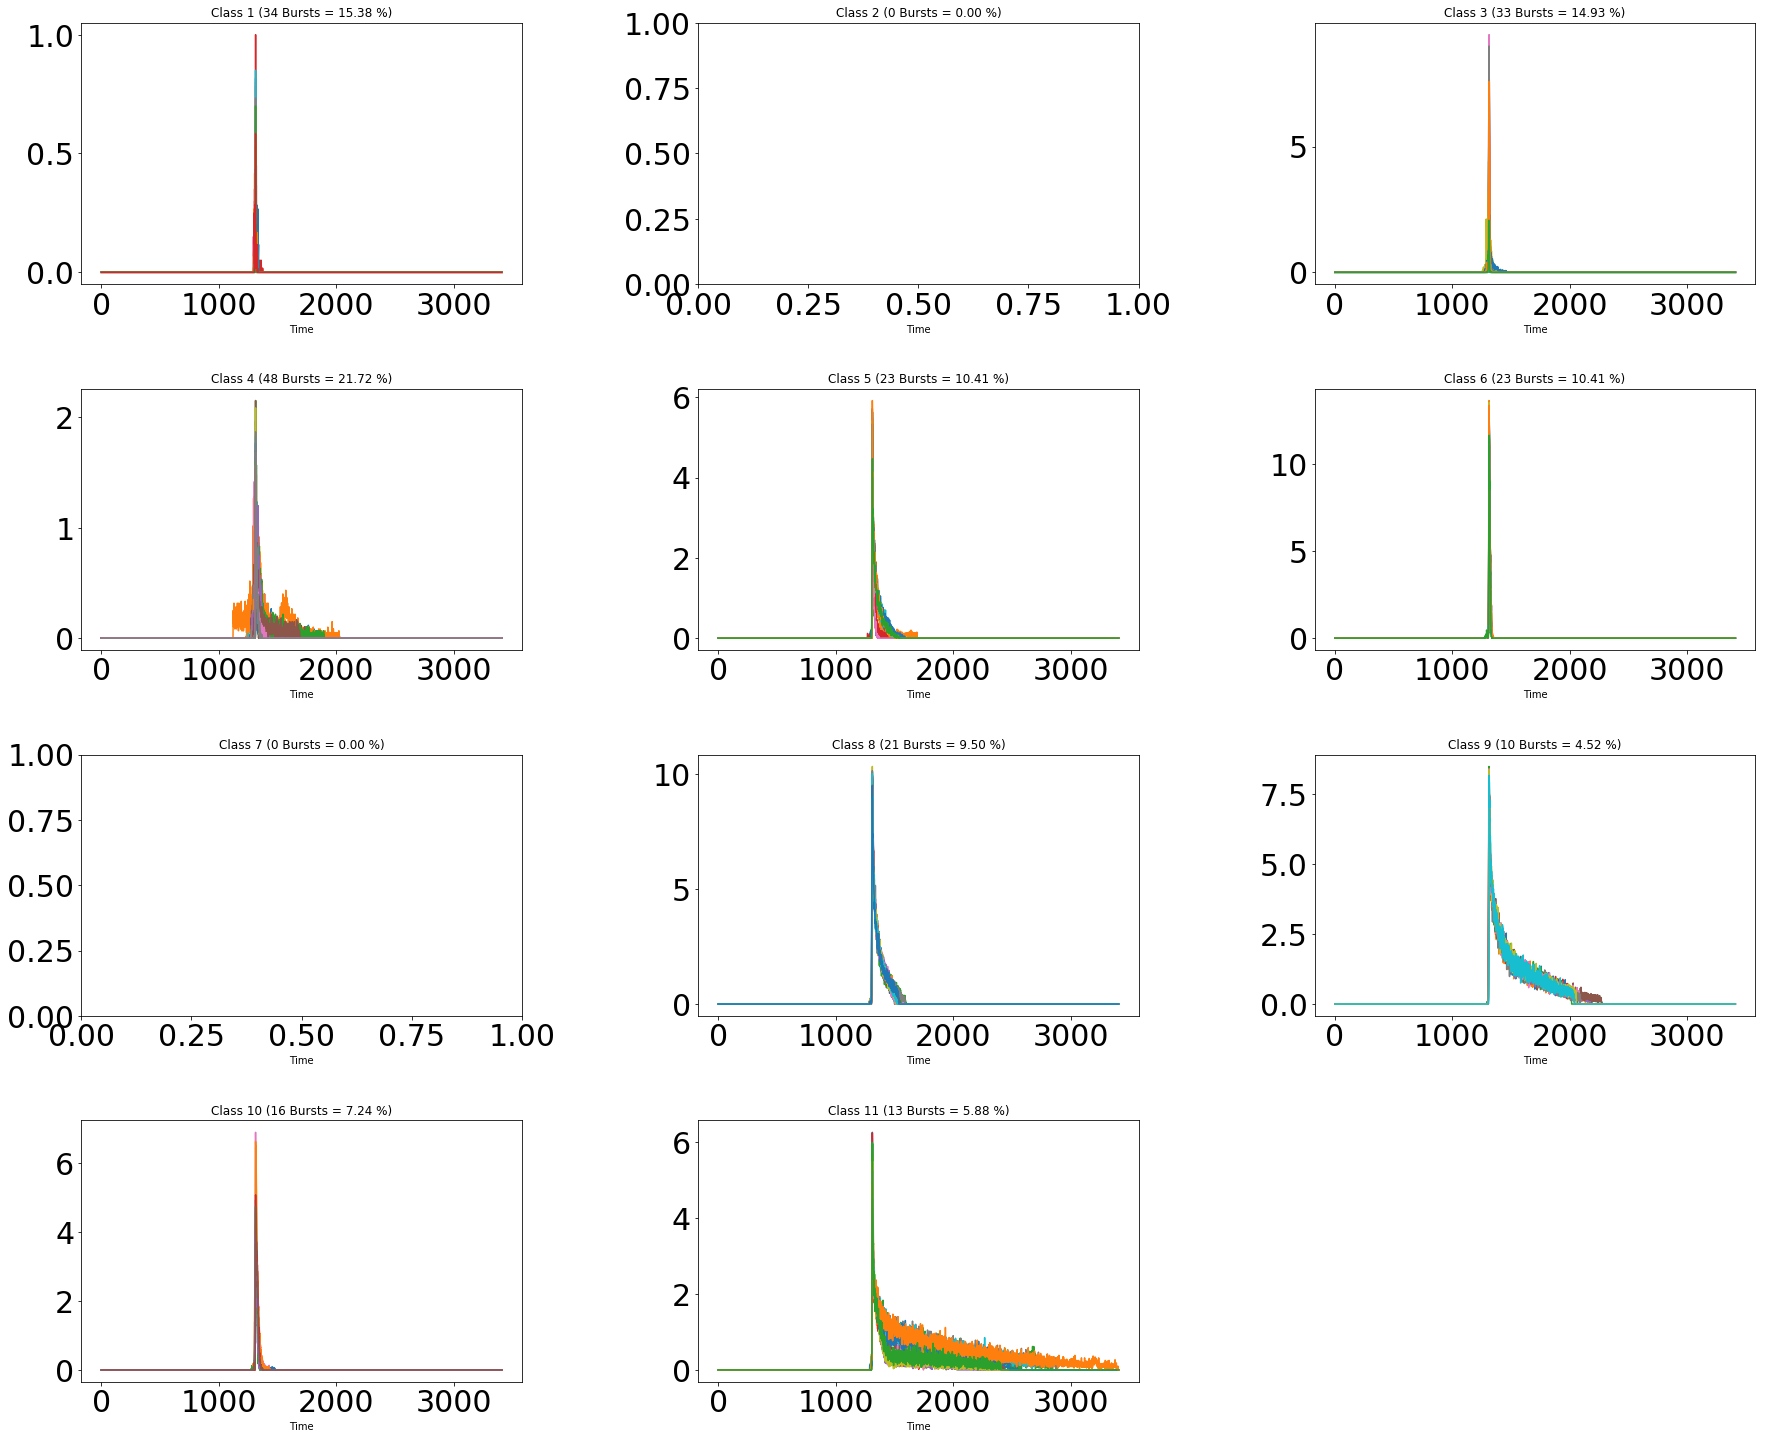

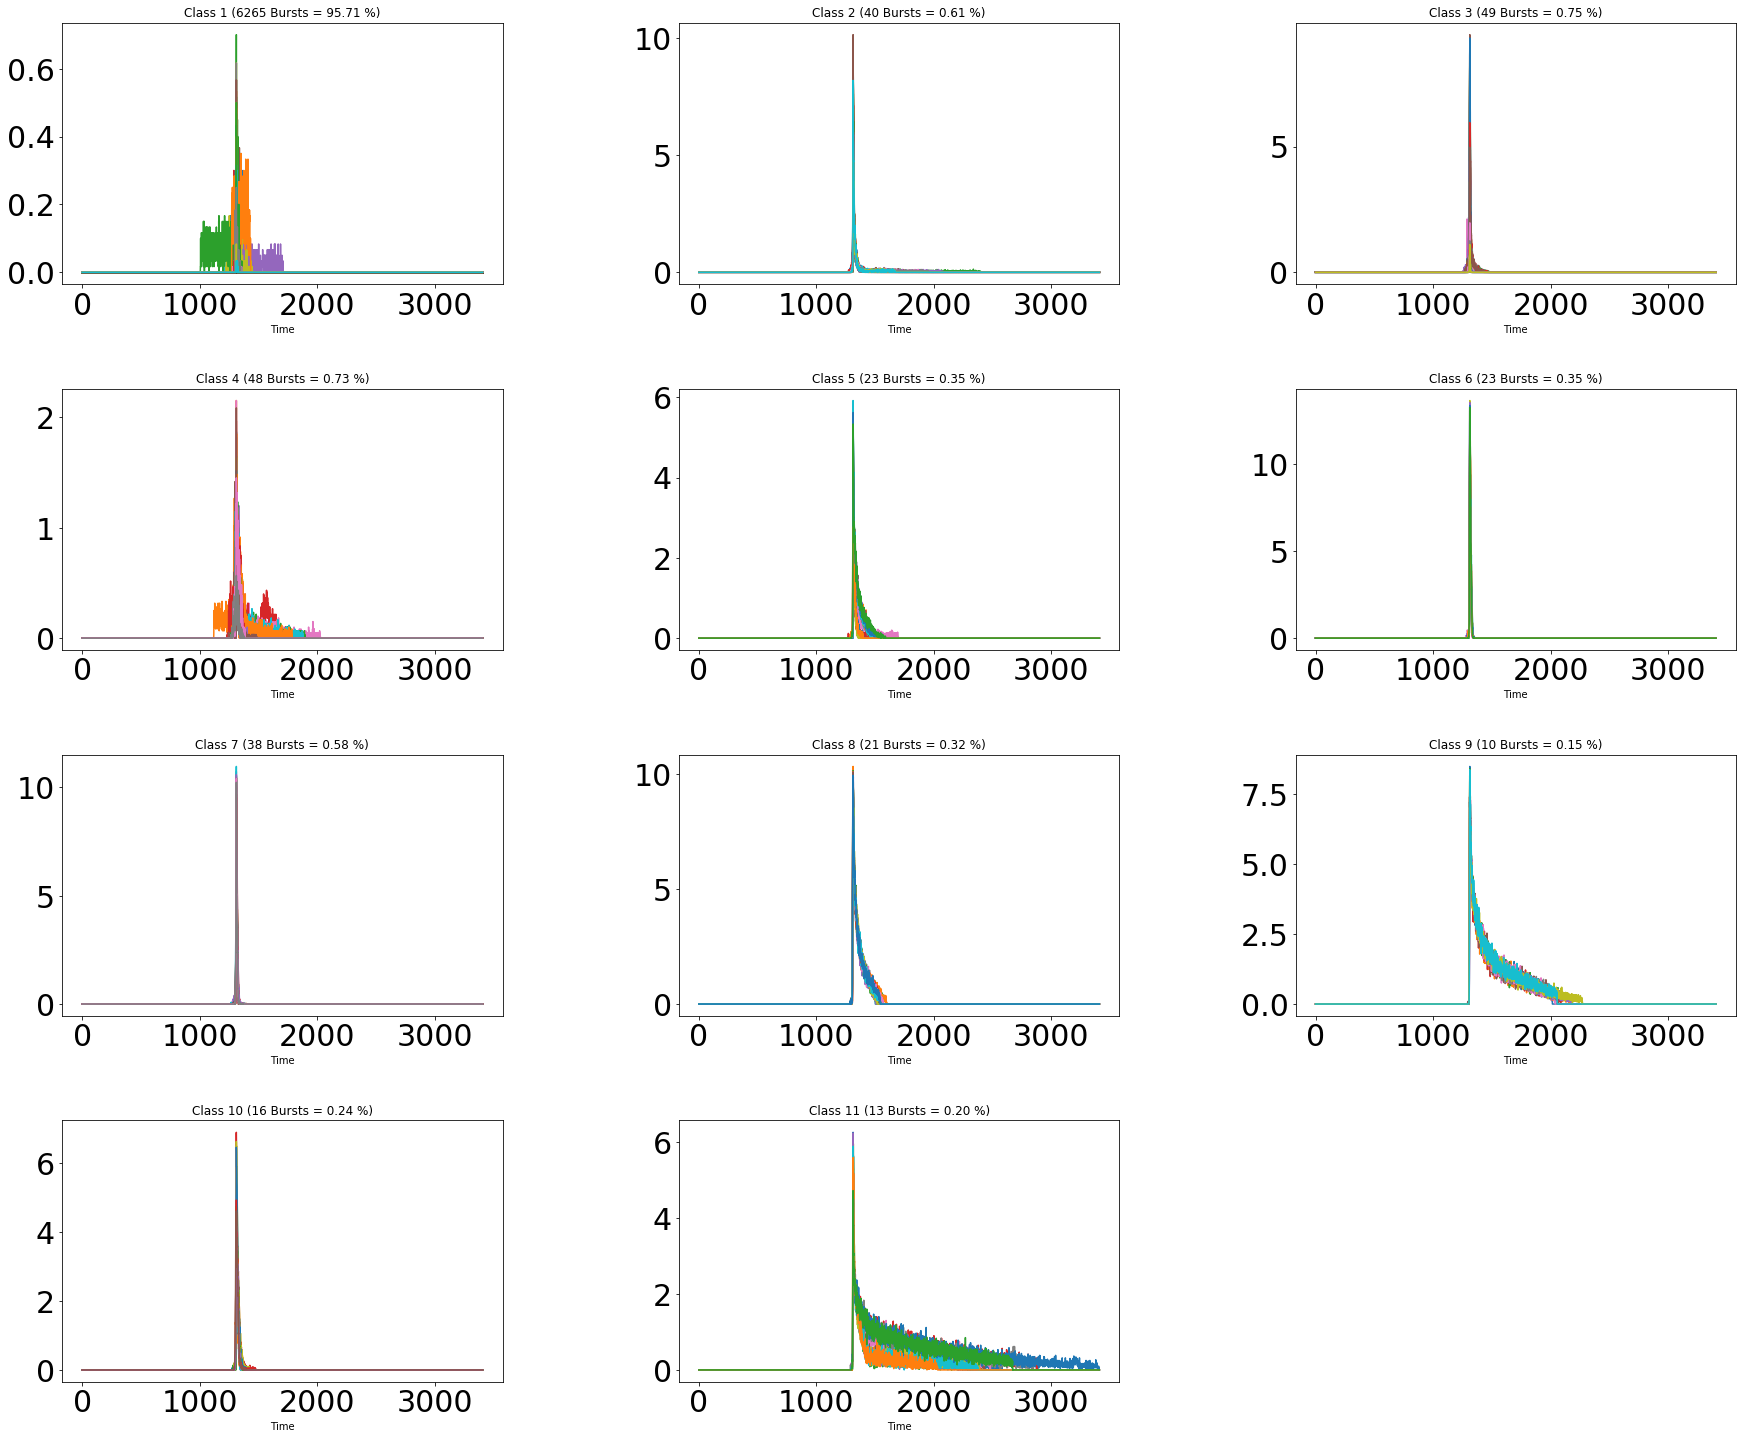

In [30]:
plot_cluster_examples(data[discarded_burst_indices[0]], np.asarray(discarded_burst_train_labels_1), 11)
plot_cluster_examples(training_sets[1], train_fold_labels[1][11-1], 11)

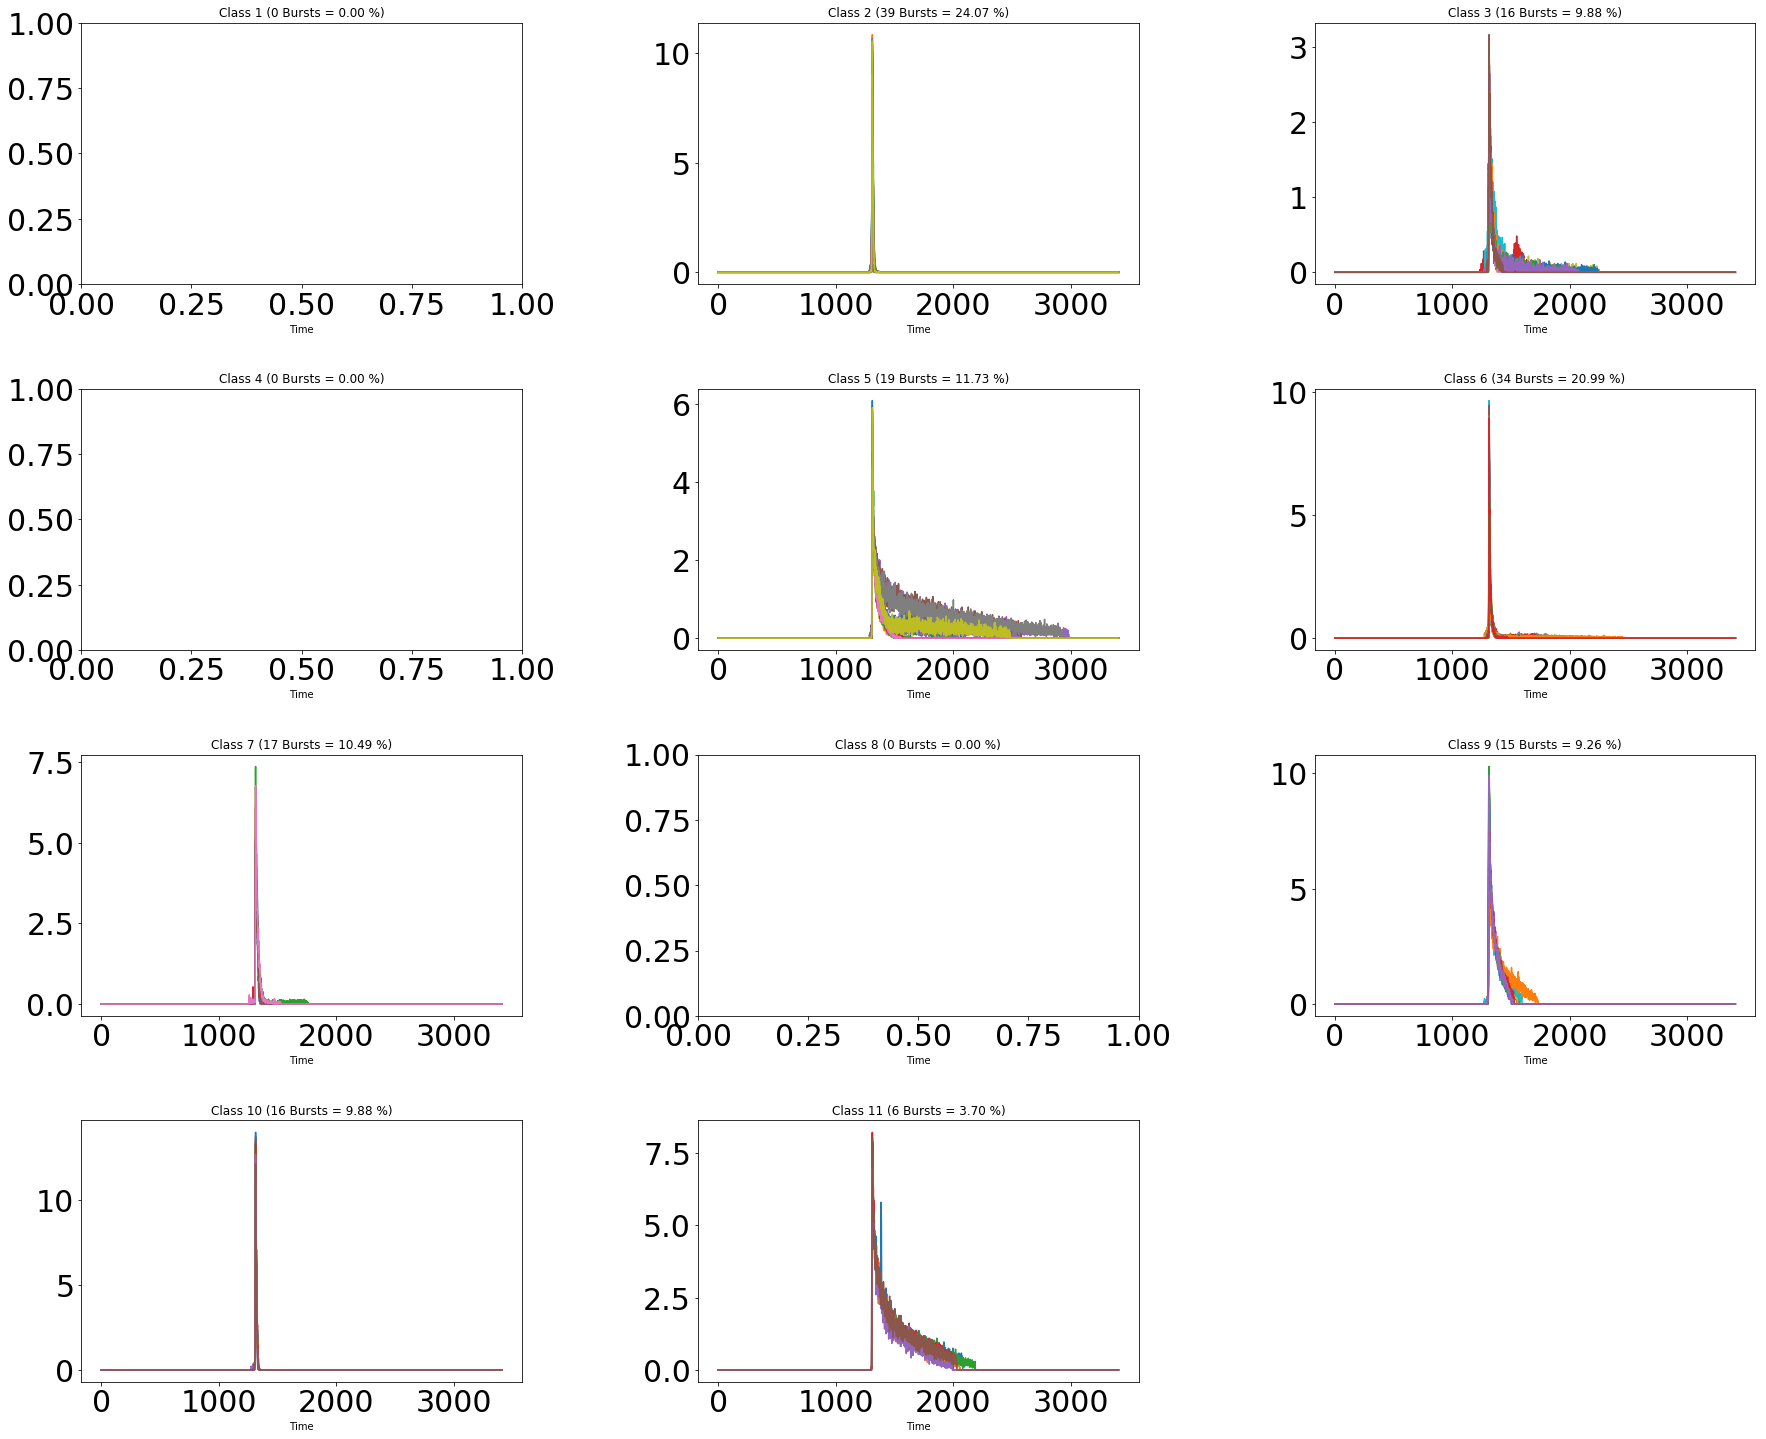

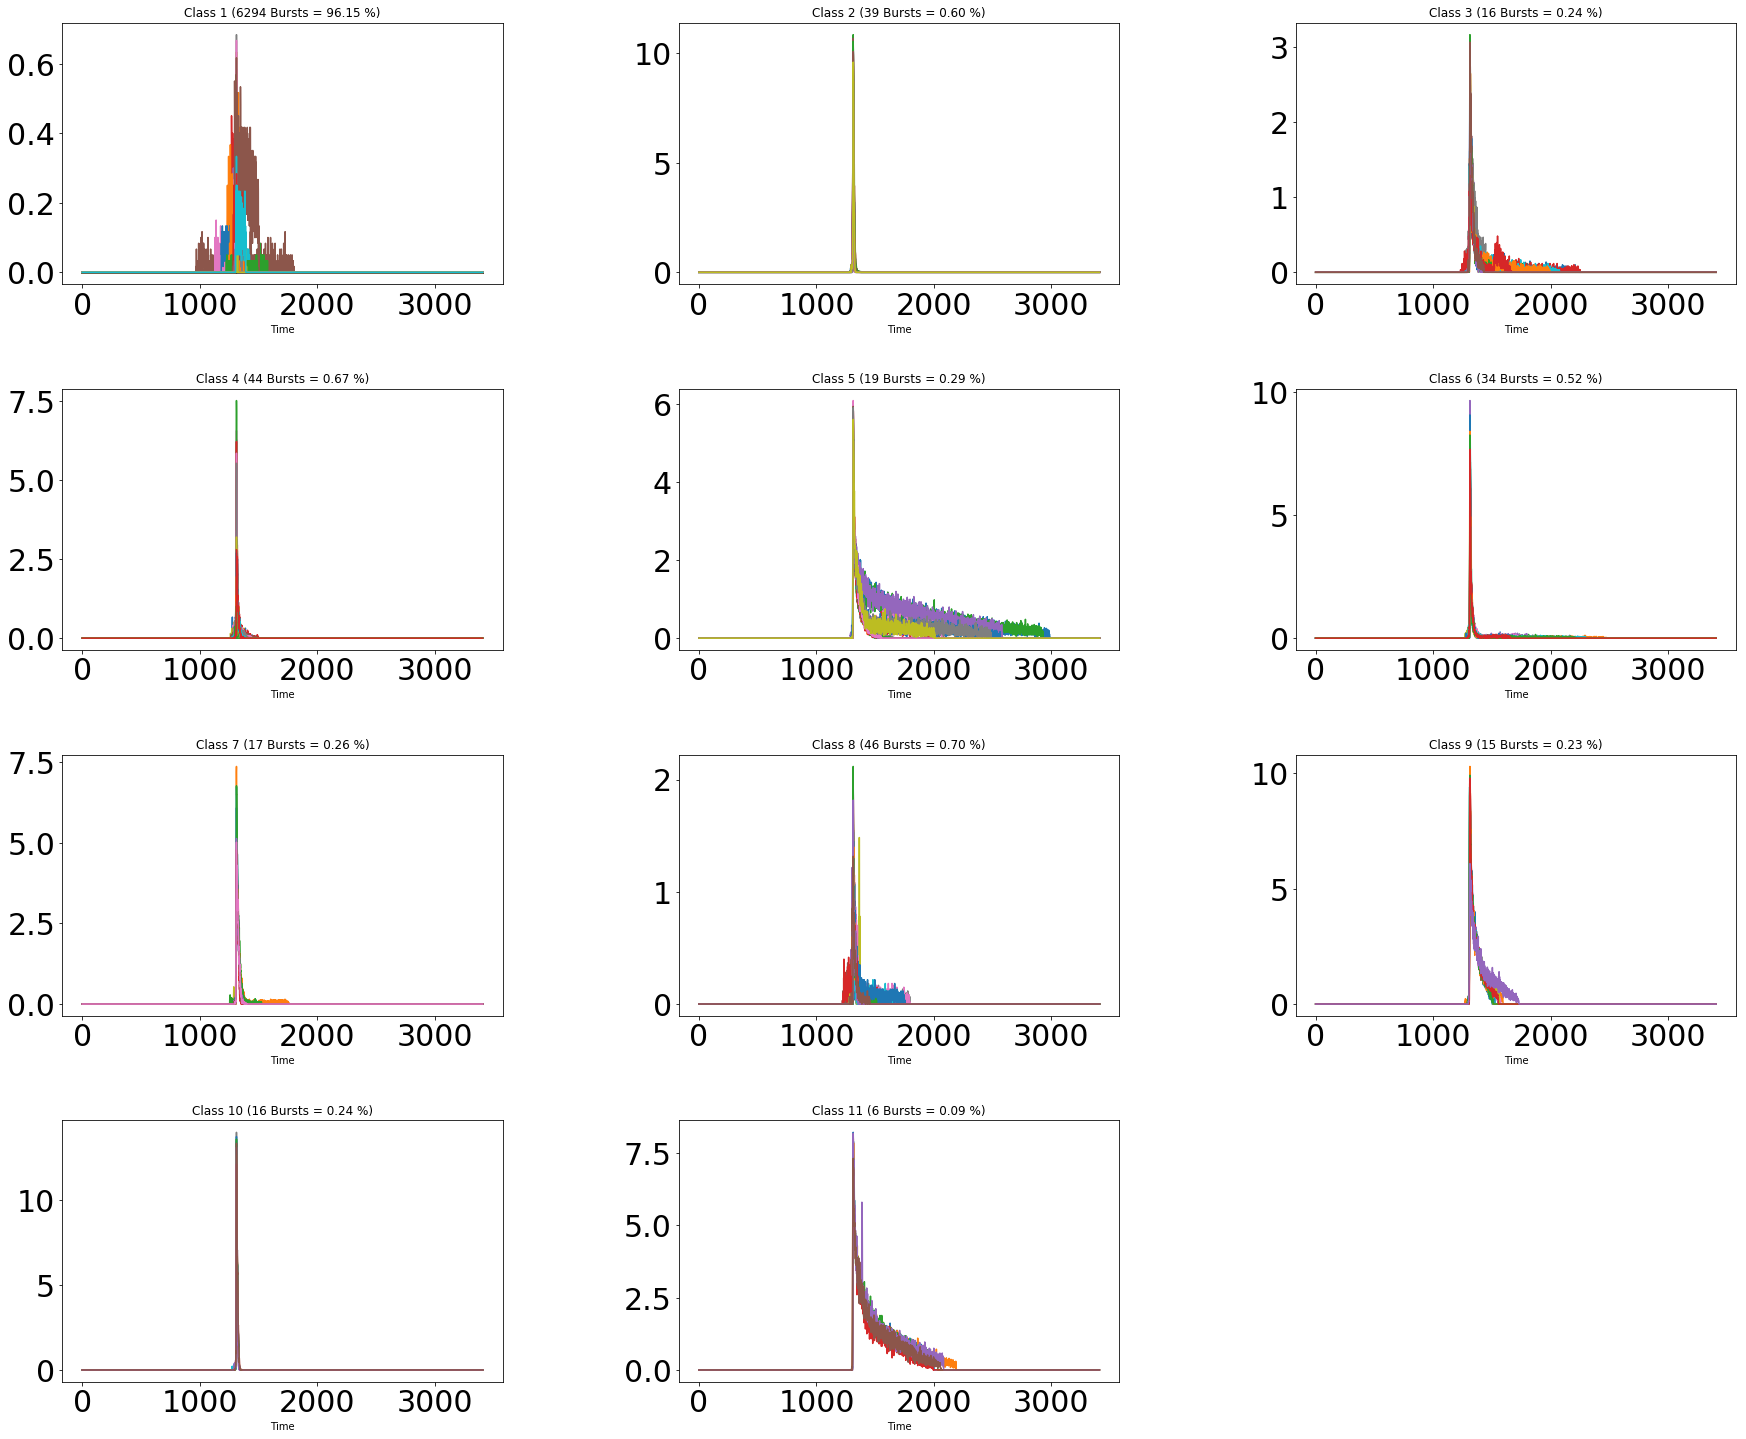

In [31]:
plot_cluster_examples(data[discarded_burst_indices[1]], np.asarray(discarded_burst_train_labels_2), 11)
plot_cluster_examples(training_sets[0], train_fold_labels[0][11-1], 11)

221


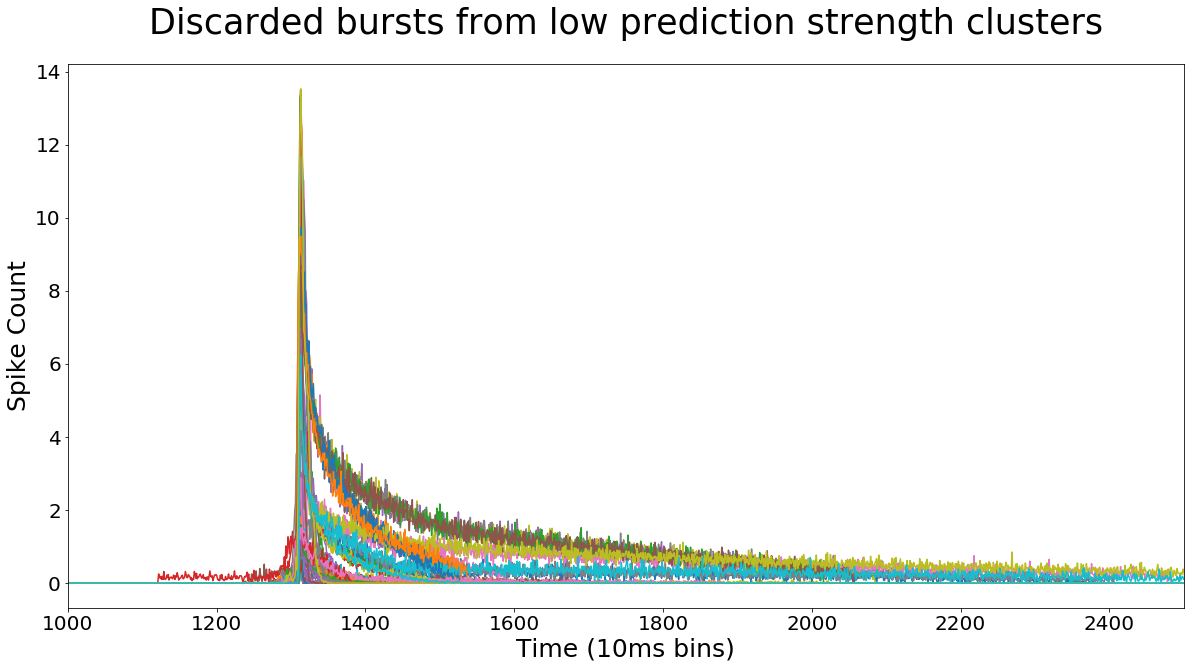

162


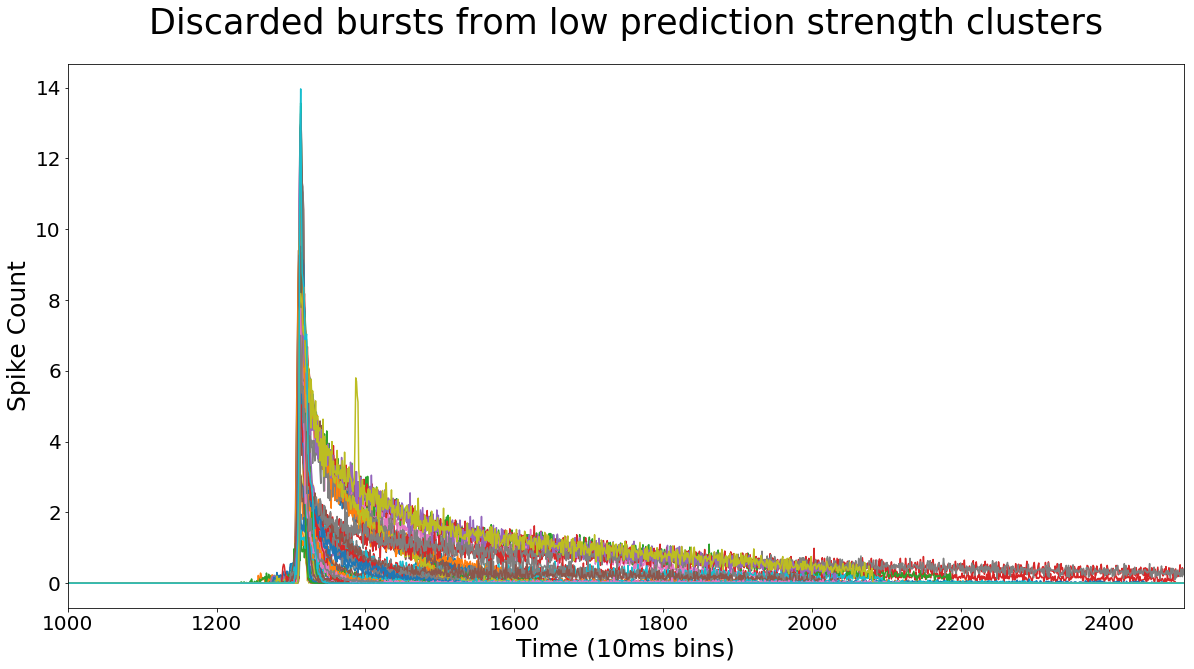

In [43]:
for i in range(n_folds):   
    plt.figure(figsize=(20,10))
    print(len(data[discarded_burst_indices[i]]))
    for burst in data[discarded_burst_indices[i]][0:100]:
        plt.plot(burst)

    plt.xlabel("Time (10ms bins)",fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel("Spike Count",fontsize = 25)
    plt.xlim((1000,2500))
    plt.title("Discarded bursts from low prediction strength clusters",fontsize = 35,pad = 30)    
    plt.show()

# Denoise Data based on prediction Strength per sample 
Calculate prediction strength per sample and throw out samples with low prediction strength.
Reduce the number of clusters if all samples of one cluster are thrown out. 

In [17]:
init_k_clusters =  11
n_folds = 2
k_clusters = np.repeat(init_k_clusters,n_folds) #np.asarray([12, 11]
counter = 0
threshold = 0.5 
n_low_ps_bursts_per_fold = [100,100]
re_shuffle = True


sub_dir = 'day_20_21_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.5/'

In [18]:
from ipynb.fs.defs.Spectral_clustering_pipeline import spectral_clustering
from ipynb.fs.defs.prediction_strength import cross_valdation_prediction_strength
from ipynb.fs.defs.prediction_strength import get_low_individual_ps_bursts
from ipynb.fs.defs.prediction_strength import get_low_and_high_ps_bursts_fold_with_labels
from ipynb.fs.defs.train_validation_split import k_fold_split
from ipynb.fs.defs.prediction_strength import plot_cluster_examples

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## 1. Approach
- start with the number of cluster suggested by the amount of bursts with low prediction strength
- remove bursts with low prediction strength for both sets
- look at number of bursts left in each cluster and reduce the number of clusters by the number of empty clusters

In [ ]:
while True:
    print("Look [%d %d] Clusters in each fold!" % tuple(list(k_clusters)))
    np.save(data_dir + sub_dir + 'k_clusters_per_fold_%d' % counter , k_clusters)
    
    if counter == 0:
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels, valid_fold_labels,predictions_strengths_cv_per_sample,threshold = threshold)
        n_low_ps_bursts_per_fold = [np.sum(k_low_individual_ps_cv_sizes[k_clusters[i]][i]) for i in range(n_folds)] # get low burst examples for each fold after clustering with k_clusters   
        
              
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
    
    else: 
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels,predictions_strengths_cv_per_sample_without_low_samples,threshold = threshold, n_clusters=range(1,max(k_clusters)+1))
        n_low_ps_bursts_per_fold = [np.sum(k_low_individual_ps_cv_sizes[k_clusters[i]][i]) for i in range(n_folds)] # get low burst examples for each fold after clustering with k_clusters   
        
        
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds,high_ps_valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
        
    
    print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_low_ps_bursts_per_fold) + [threshold])))
    
    
    
    if np.sum(n_low_ps_bursts_per_fold) == 0:
        print("Converged!")
        break
        
    print("Save Number of Bursts with low Prediction Strength for each fold!")
    np.save(data_dir + sub_dir + 'n_low_ps_bursts_per_fold_%d' % counter , n_low_ps_bursts_per_fold)
    
     
    high_ps_valid_folds= [] #indices of bursts in validation set with high prediction strenght per fold
    new_k_clusters = []
    
    for i in range(n_folds):  
        high_ps_valid_folds.append(np.asarray(k_high_ps_bursts_folds[k_clusters[i]][i])) # get bursts indices with high ps for clustering with k_clusters 
        new_k_clusters.append(len(np.unique(high_ps_bursts_fold_labels[i][k_clusters[i]-1]))) #get classes with at least one burst 
        
    high_ps_valid_folds = np.asarray(high_ps_valid_folds)
    
    
    clusters = list(range(1,np.amax(new_k_clusters) + 1))
        
    high_ps_train_folds=[]
    high_ps_train_fold_labels=[]
    high_ps_valid_fold_labels=[]
        
    for i in range(n_folds):
        high_ps_bursts_train_i = np.concatenate((high_ps_valid_folds[:i],high_ps_valid_folds[(i+1):]), axis = 0)[0]
        high_ps_train_folds.append(np.asarray(high_ps_bursts_train_i))
            
        high_ps_bursts_valid_i = high_ps_valid_folds[i]
            
        high_ps_train_labels_i = spectral_clustering(data[high_ps_bursts_train_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_train_fold_labels.append(high_ps_train_labels_i)
            
        high_ps_valid_labels_i = spectral_clustering(data[high_ps_bursts_valid_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_valid_fold_labels.append(high_ps_valid_labels_i)
        
   
    high_ps_train_folds = np.asarray(high_ps_train_folds)
        
    
    print("Save denoised folds!")
    np.save(data_dir + sub_dir + 'high_ps_valid_folds_%d' % (counter + 1), high_ps_valid_folds)
    np.save(data_dir + sub_dir + 'high_ps_train_folds_%d' % (counter + 1), high_ps_train_folds) #not necessary can be derived from validation folds 
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'high_ps_train_fold_labels_%d' % (counter + 1), high_ps_train_fold_labels)
    np.save(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d' % (counter + 1), high_ps_valid_fold_labels)
    
    
    
    print("Calculate Prediction Strength per sample for each fold! ")  
    predictions_strengths_cv_per_sample_without_low_samples, _ = cross_valdation_prediction_strength(data, high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels, per_sample = True)
    print("Done!")   
    
    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d' % (counter + 1), predictions_strengths_cv_per_sample_without_low_samples)
 
    
    k_clusters = new_k_clusters
    counter += 1

Look [11 11] Clusters in each fold!
[155 944] Bursts found in each fold with Prediction Strength below threshold = 0.50!
Save Number of Bursts with low Prediction Strength for each fold!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian


## Approach 1.2 
- use criterion of most non empty clusters with least amount of low prediction strength bursts

In [18]:
init_k_clusters = 11
n_folds = 2
k_clusters = np.repeat(init_k_clusters,n_folds)
up_to_k_clusters = init_k_clusters
counter = 0
threshold = 0.5 
n_low_ps_bursts_per_fold = [100,100]
n_clusters = range(1,20)

sub_dir = '50_50_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.5_criterion_based_reduction/'

In [ ]:
while True:    
    print("Look at up to %d Clusters in each fold!" % up_to_k_clusters)
    print(counter)
    np.save(data_dir + sub_dir + 'up_to_k_clusters_%d' % counter , up_to_k_clusters)
    
    if counter == 0:
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels, valid_fold_labels,predictions_strengths_cv_per_sample,threshold = threshold)
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds, n_clusters = range(1,up_to_k_clusters+1))
    else: 
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels,predictions_strengths_cv_per_sample_without_low_samples,threshold = threshold, n_clusters=range(1,up_to_k_clusters+1))
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds,high_ps_valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,up_to_k_clusters+1))
        
    n_low_ps_bursts_per_k_and_fold = [[np.sum(k_low_individual_ps_cv_sizes[k][i]) for i in range(n_folds)] for k in range(1,up_to_k_clusters+1)]# get low burst examples for each fold after clustering with k_clusters                 
    n_low_ps_bursts_per_k = np.sum(n_low_ps_bursts_per_k_and_fold,axis=1)
    
    n_clusters_left_per_k_and_fold = [[len(np.unique(high_ps_bursts_fold_labels[i][k])) for i in range(n_folds)] for k in range(up_to_k_clusters)]

    #print(n_low_ps_bursts_per_k)
    #print(n_clusters_left_per_k_and_fold)
    
    max_number_of_clusters_with_high_ps = np.amax(n_clusters_left_per_k_and_fold)
    possible_ks_with_max_number_clusters = np.where(n_clusters_left_per_k_and_fold == np.amax(n_clusters_left_per_k_and_fold))[0] # only interested in first index not in fold index 
    
    print(possible_ks_with_max_number_clusters)
    
    corresponding_summed_number_of_low_bursts = n_low_ps_bursts_per_k[possible_ks_with_max_number_clusters]
    print(corresponding_summed_number_of_low_bursts)
    
    k_with_highest_n_clusters_and_low_bursts = possible_ks_with_max_number_clusters[np.argmin(corresponding_summed_number_of_low_bursts)]
    
    #print(k_with_highest_n_clusters_and_low_bursts)
    
    print("Maximal number of clusters with maximal number of bursts above threshold = %.2f found by clustering with %d Clusters" % (threshold,(k_with_highest_n_clusters_and_low_bursts +1)))
    print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_low_ps_bursts_per_k_and_fold[k_with_highest_n_clusters_and_low_bursts]) + [threshold])))
    np.save(data_dir + sub_dir + "best_k_%d" % (counter + 1), k_with_highest_n_clusters_and_low_bursts +1)
    
    #print(n_low_ps_bursts_per_k[k_with_highest_n_clusters_and_low_bursts])
    
    if  n_low_ps_bursts_per_k[k_with_highest_n_clusters_and_low_bursts]== 0:
        np.save(data_dir + sub_dir + 'final_k_clusters', k_with_highest_n_clusters_and_low_bursts + 1)
        print("Converged!")
        break
        
        
    print("Save Number of Bursts with low Prediction Strength for each fold!")
    np.save(data_dir + sub_dir + 'n_low_ps_bursts_per_fold_%d' % counter , n_low_ps_bursts_per_k_and_fold[k_with_highest_n_clusters_and_low_bursts])
    
     
    high_ps_valid_folds= [] #indices of bursts in validation set with high prediction strenght per fold
    #new_k_clusters = []
    
    for i in range(n_folds):  
        high_ps_valid_folds.append(np.asarray(k_high_ps_bursts_folds[k_with_highest_n_clusters_and_low_bursts+1][i])) # get bursts indices with high ps for clustering with k_clusters 
        #new_k_clusters.append(len(np.unique(high_ps_bursts_fold_labels[i][k_clusters[i]-1]))) #get classes with at least one burst 
        
    high_ps_valid_folds = np.asarray(high_ps_valid_folds)
    
    
    clusters = list(range(1,k_with_highest_n_clusters_and_low_bursts + 2))
    print(clusters)
    
    
    high_ps_train_folds=[]
    high_ps_train_fold_labels=[]
    high_ps_valid_fold_labels=[]
        
    for i in range(n_folds):
        high_ps_bursts_train_i = np.concatenate((high_ps_valid_folds[:i],high_ps_valid_folds[(i+1):]), axis = 0)[0]
        high_ps_train_folds.append(np.asarray(high_ps_bursts_train_i))
            
        high_ps_bursts_valid_i = high_ps_valid_folds[i]
            
        high_ps_train_labels_i = spectral_clustering(data[high_ps_bursts_train_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_train_fold_labels.append(high_ps_train_labels_i)
            
        high_ps_valid_labels_i = spectral_clustering(data[high_ps_bursts_valid_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_valid_fold_labels.append(high_ps_valid_labels_i)
        
   
    high_ps_train_folds = np.asarray(high_ps_train_folds)
        
    
    print("Save denoised folds!")
    np.save(data_dir + sub_dir + 'high_ps_valid_folds_%d' % (counter + 1), high_ps_valid_folds)
    np.save(data_dir + sub_dir + 'high_ps_train_folds_%d' % (counter + 1), high_ps_train_folds) #not necessary can be derived from validation folds 
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'high_ps_train_fold_labels_%d' % (counter + 1), high_ps_train_fold_labels)
    np.save(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d' % (counter + 1), high_ps_valid_fold_labels)
    
    
    
    print("Calculate Prediction Strength per sample for each fold! ")  
    predictions_strengths_cv_per_sample_without_low_samples, _ = cross_valdation_prediction_strength(data, high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels, per_sample = True)
    print("Done!")   
    
    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d' % (counter + 1), predictions_strengths_cv_per_sample_without_low_samples)
 
    
    up_to_k_clusters = k_with_highest_n_clusters_and_low_bursts + 1
    counter += 1

Look at up to 11 Clusters in each fold!
0
[ 9 10 10]
[104 137 137]
Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with 10 Clusters
[38 66] Bursts found in each fold with Prediction Strength below threshold = 0.50!
Save Number of Bursts with low Prediction Strength for each fold!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save denoised folds!
Save labels!
Calculate Prediction Strength per sample for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
Look at up to 10 Clusters in each fold!
1
[9]
[1792]
Maximal number of clusters with maximal number of bursts 

## Approach 1.2.2
- use criterion of most non empty clusters with least amount of low prediction strength bursts
- 1.2.2 for each fold different making sure number of clusters is <= last iteration 

In [19]:
init_k_clusters = 11
n_folds = 2
#k_clusters = np.repeat(init_k_clusters,n_folds)
k_clusters = [12,11]
counter = 0
threshold = 0.5 
n_low_ps_bursts_per_fold = [100,100]
n_clusters = range(1,20)

sub_dir = 'day_20_21_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.5_criterion_based_reduction_2.0_fixed_cluster_reduction/'

In [20]:
while True:    
    print("Look for up to [%d %d] Clusters in each fold!" % tuple(list(k_clusters)))
    np.save(data_dir + sub_dir + 'k_clusters_per_fold_%d' % counter , k_clusters)
    
    if counter == 0:
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels, valid_fold_labels,predictions_strengths_cv_per_sample,threshold = threshold)
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
    
    else: 
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels,predictions_strengths_cv_per_sample_without_low_samples,threshold = threshold, n_clusters=range(1,max(k_clusters)+1)) 
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds,high_ps_valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
        
    
    n_low_ps_bursts_per_k_and_fold = [[np.sum(k_low_individual_ps_cv_sizes[k][i]) for i in range(n_folds)] for k in range(1,max(k_clusters)+1)]# get low burst examples for each fold after clustering with k_clusters                 
    n_clusters_left_per_k_and_fold = [[len(np.unique(high_ps_bursts_fold_labels[i][k])) for i in range(n_folds)] for k in range(max(k_clusters))]


   
    print(n_low_ps_bursts_per_k_and_fold)
    print(n_clusters_left_per_k_and_fold)
    
    
    max_number_of_clusters_with_high_ps_per_fold = [np.amax(np.asarray(n_clusters_left_per_k_and_fold)[:k_clusters[f],f]) for f in range(n_folds)] #np.amax(n_clusters_left_per_k_and_fold,axis = 0)
    print(max_number_of_clusters_with_high_ps_per_fold)
    #print(paul)
    possible_ks_with_max_number_clusters = [np.where(np.asarray(n_clusters_left_per_k_and_fold)[:k_clusters[f],f] == max_number_of_clusters_with_high_ps_per_fold[f])[0] for f in range(n_folds)] # only interested in first index not in fold index 
    
    
    print(possible_ks_with_max_number_clusters)
    corresponding_summed_number_of_low_bursts_per_fold = [np.asarray(n_low_ps_bursts_per_k_and_fold)[possible_ks_with_max_number_clusters[f],f] for f in range(n_folds)]
    print(corresponding_summed_number_of_low_bursts_per_fold)
    
    k_with_highest_n_clusters_and_low_bursts = [possible_ks_with_max_number_clusters[f][np.argmin(corresponding_summed_number_of_low_bursts_per_fold[f])] for f in range(n_folds)]
    print(k_with_highest_n_clusters_and_low_bursts)
    
    
    new_k_clusters = np.asarray(k_with_highest_n_clusters_and_low_bursts) + 1
    n_low_ps_bursts_per_fold_for_criterion = [n_low_ps_bursts_per_k_and_fold[new_k_clusters[f]-1][f] for f in range(n_folds)]
    
    
    print("Maximal number of clusters with maximal number of bursts above threshold = %.2f found by clustering with [%d %d] Clusters" % tuple([threshold] + list(new_k_clusters)))
    print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(n_low_ps_bursts_per_fold_for_criterion + [threshold])))
    
    
    
    if  np.sum(n_low_ps_bursts_per_fold_for_criterion)== 0:
        np.save(data_dir + sub_dir + 'final_k_clusters', new_k_clusters)
        print("Converged!")
        break
        
        
    print("Save Number of Bursts with low Prediction Strength for each fold!")
    np.save(data_dir + sub_dir + "n_low_ps_bursts_per_fold_%d" % (counter + 1), n_low_ps_bursts_per_fold_for_criterion)
    
     
    high_ps_valid_folds= [] #indices of bursts in validation set with high prediction strenght per fold
    
    for i in range(n_folds):  
        high_ps_valid_folds.append(np.asarray(k_high_ps_bursts_folds[new_k_clusters[i]][i])) # get bursts indices with high ps for clustering with k_clusters 
        
        
    high_ps_valid_folds = np.asarray(high_ps_valid_folds)
    
    
    clusters = list(range(1,max(new_k_clusters) + 1))
    print(clusters)
    
    high_ps_train_folds=[]
    high_ps_train_fold_labels=[]
    high_ps_valid_fold_labels=[]
        
    for i in range(n_folds):
        high_ps_bursts_train_i = np.concatenate((high_ps_valid_folds[:i],high_ps_valid_folds[(i+1):]), axis = 0)[0]
        high_ps_train_folds.append(np.asarray(high_ps_bursts_train_i))
            
        high_ps_bursts_valid_i = high_ps_valid_folds[i]
            
        high_ps_train_labels_i = spectral_clustering(data[high_ps_bursts_train_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_train_fold_labels.append(high_ps_train_labels_i)
            
        high_ps_valid_labels_i = spectral_clustering(data[high_ps_bursts_valid_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_valid_fold_labels.append(high_ps_valid_labels_i)
        
   
    high_ps_train_folds = np.asarray(high_ps_train_folds)
        
    
    print("Save denoised folds!")
    np.save(data_dir + sub_dir + 'high_ps_valid_folds_%d' % (counter + 1), high_ps_valid_folds)
    np.save(data_dir + sub_dir + 'high_ps_train_folds_%d' % (counter + 1), high_ps_train_folds) #not necessary can be derived from validation folds 
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'high_ps_train_fold_labels_%d' % (counter + 1), high_ps_train_fold_labels)
    np.save(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d' % (counter + 1), high_ps_valid_fold_labels)
    
    
    
    print("Calculate Prediction Strength per sample for each fold! ")  
    predictions_strengths_cv_per_sample_without_low_samples, _ = cross_valdation_prediction_strength(data, high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels, per_sample = True)
    print("Done!")   
    
    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d' % (counter + 1), predictions_strengths_cv_per_sample_without_low_samples)
 
    
    k_clusters = new_k_clusters 
    counter += 1

Look for up to [12 11] Clusters in each fold!
[[0, 0], [0, 101], [0, 314], [84, 438], [45, 205], [48, 2603], [48, 2582], [64, 2665], [79, 2746], [172, 834], [155, 944], [136, 4695]]
[[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 6], [9, 6], [10, 9], [11, 9], [12, 9]]
[12, 9]
[array([11]), array([ 9, 10])]
[array([136]), array([834, 944])]
[11, 9]
Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with [12 10] Clusters
[136 834] Bursts found in each fold with Prediction Strength below threshold = 0.50!
Save Number of Bursts with low Prediction Strength for each fold!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save den

# 2. Approach (reshuffling)

- start with clusterings from 1 to 20 
- calculate the prediction strength per sample for each clustering with k clusters and remove bursts with low prediction strength in an individual copy of the splits
- refit each individual reduced copy again with 1 to k clusters (spanning tree)
- stop if no burst below threshold or no burst left in one of the datasets

# 2.1 Approach (reshuffling)
- start with clustering from 1 to 20
- calculate the prediction strenght per sample for each clustering with k clusters and remove bursts with low prediction strength and look how many classes left 
- take the clustering with the most classes left and remove the corresponding low ps bursts 
- reshuffle and refit again with number of classes left
- stop if no bursts below threshold or no burst left

In [44]:
init_k_clusters = 20 #11
n_folds = 2
k_clusters = np.repeat(init_k_clusters,n_folds)
up_to_k_clusters = init_k_clusters
counter = 0
threshold = 0.5 
n_low_ps_bursts_per_fold = [100,100]
n_clusters = range(1,20)
re_shuffle = True

sub_dir = '50_50_split/denoising/spectral_clustering/k_init=20_denoising_per_sample/threshold=0.5_criterion_based_reshuffled/'

In [45]:
from ipynb.fs.defs.train_validation_split import k_fold_split
seed = np.random.RandomState(seed=42)

In [46]:
while True:
    print("Look at up to %d Clusters in each fold!" % up_to_k_clusters)
    print(counter)
    np.save(data_dir + sub_dir + 'up_to_k_clusters_%d' % counter , up_to_k_clusters)
    
    if counter == 0:
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels, valid_fold_labels,predictions_strengths_cv_per_sample,threshold = threshold)
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds, n_clusters = range(1,up_to_k_clusters+1))
    else: 
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels,predictions_strengths_cv_per_sample_without_low_samples,threshold = threshold, n_clusters=range(1,up_to_k_clusters+1))
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds,high_ps_valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,up_to_k_clusters+1))
        
    n_low_ps_bursts_per_k_and_fold = [[np.sum(k_low_individual_ps_cv_sizes[k][i]) for i in range(n_folds)] for k in range(1,up_to_k_clusters+1)]# get low burst examples for each fold after clustering with k_clusters                 
    n_low_ps_bursts_per_k = np.sum(n_low_ps_bursts_per_k_and_fold,axis=1)
    
    n_clusters_left_per_k_and_fold = [[len(np.unique(high_ps_bursts_fold_labels[i][k])) for i in range(n_folds)] for k in range(up_to_k_clusters)]

    #print(n_low_ps_bursts_per_k)
    #print(n_clusters_left_per_k_and_fold)
    
    max_number_of_clusters_with_high_ps = np.amax(n_clusters_left_per_k_and_fold)
    possible_ks_with_max_number_clusters = np.where(n_clusters_left_per_k_and_fold == np.amax(n_clusters_left_per_k_and_fold))[0] # only interested in first index not in fold index 
    
    print(possible_ks_with_max_number_clusters)
    
    corresponding_summed_number_of_low_bursts = n_low_ps_bursts_per_k[possible_ks_with_max_number_clusters]
    print(corresponding_summed_number_of_low_bursts)
    
    k_with_highest_n_clusters_and_low_bursts = possible_ks_with_max_number_clusters[np.argmin(corresponding_summed_number_of_low_bursts)]
    
    #print(k_with_highest_n_clusters_and_low_bursts)
    
    print("Maximal number of clusters with maximal number of bursts above threshold = %.2f found by clustering with %d Clusters" % (threshold,(k_with_highest_n_clusters_and_low_bursts +1)))
    print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_low_ps_bursts_per_k_and_fold[k_with_highest_n_clusters_and_low_bursts]) + [threshold])))
    np.save(data_dir + sub_dir + "best_k_%d" % (counter + 1), k_with_highest_n_clusters_and_low_bursts +1)
    
    print(n_low_ps_bursts_per_k[k_with_highest_n_clusters_and_low_bursts])
    
    if  n_low_ps_bursts_per_k[k_with_highest_n_clusters_and_low_bursts]== 0:
        np.save(data_dir + sub_dir + 'final_k_clusters', k_with_highest_n_clusters_and_low_bursts + 1)
        print("Converged!")
        break
        
        
    print("Save Number of Bursts with low Prediction Strength for each fold!")
    np.save(data_dir + sub_dir + 'n_low_ps_bursts_per_fold_%d' % counter , n_low_ps_bursts_per_k_and_fold[k_with_highest_n_clusters_and_low_bursts])
    
    
    high_ps_bursts= [] #indices of bursts in validation set with high prediction strenght per fold
    
    for i in range(n_folds):  
        high_ps_bursts += k_high_ps_bursts_folds[k_with_highest_n_clusters_and_low_bursts+1][i] # get bursts indices with high ps for clustering with k_clusters  
        
    high_ps_bursts = np.asarray(high_ps_bursts)
    
    
    n_total_high_ps_bursts = len(high_ps_bursts)
    n_total_high_ps_bursts_shuffled = seed.permutation(n_total_high_ps_bursts) # randomly shuffle data 
    
    print("Reshuffle data!")
    train_fold_indices, valid_fold_indices = k_fold_split(n_total_high_ps_bursts_shuffled, k_folds = n_folds) # k fold split indices 
    
    
    clusters = list(range(1,k_with_highest_n_clusters_and_low_bursts + 2))
    #clusters = list(range(1,up_to_k_clusters + 1))
        
    high_ps_train_folds=[]
    high_ps_valid_folds=[]
    high_ps_train_fold_labels=[]
    high_ps_valid_fold_labels=[]
        
    for i in range(n_folds):
        high_ps_bursts_train_i = high_ps_bursts[train_fold_indices[i]]
        high_ps_train_folds.append(np.asarray(high_ps_bursts_train_i))
            
        high_ps_bursts_valid_i = high_ps_bursts[valid_fold_indices[i]]
        high_ps_valid_folds.append(np.asarray(high_ps_bursts_valid_i))
            
        high_ps_train_labels_i = spectral_clustering(data[high_ps_bursts_train_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_train_fold_labels.append(high_ps_train_labels_i)
            
        high_ps_valid_labels_i = spectral_clustering(data[high_ps_bursts_valid_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_valid_fold_labels.append(high_ps_valid_labels_i)
        
   
    high_ps_train_folds = np.asarray(high_ps_train_folds)
    high_ps_valid_folds = np.asarray(high_ps_valid_folds)
    
    print("Save denoised folds!")
    np.save(data_dir + sub_dir + 'high_ps_valid_folds_%d' % (counter + 1), high_ps_valid_folds)
    np.save(data_dir + sub_dir + 'high_ps_train_folds_%d' % (counter + 1), high_ps_train_folds) #not necessary can be derived from validation folds 
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'high_ps_train_fold_labels_%d' % (counter + 1), high_ps_train_fold_labels)
    np.save(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d' % (counter + 1), high_ps_valid_fold_labels)
    
    
    
    print("Calculate Prediction Strength per sample for each fold! ")  
    predictions_strengths_cv_per_sample_without_low_samples, _ = cross_valdation_prediction_strength(data, high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels, per_sample = True)
    print("Done!")   
    
    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d' % (counter + 1), predictions_strengths_cv_per_sample_without_low_samples)
 
    
    up_to_k_clusters = k_with_highest_n_clusters_and_low_bursts + 1
    counter += 1

Look at up to 20 Clusters in each fold!
0
[18 19]
[6588 6921]
Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with 19 Clusters
[3882 2706] Bursts found in each fold with Prediction Strength below threshold = 0.50!
6588
Save Number of Bursts with low Prediction Strength for each fold!
Reshuffle data!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save denoised folds!
Save labels!
Calculate Prediction Strength per sample for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
Look at up to 19 Clusters in each fold!
1
[18]
[1894]
Maximal number of clusters with maximal number of bursts above thres

Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save denoised folds!
Save labels!
Calculate Prediction Strength per sample for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
Look at up to 17 Clusters in each fold!
10
[16 16]
[191 191]
Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with 17 Clusters
[18 173] Bursts found in each fold with Prediction Strength below threshold = 0.50!
191
Save Number of Bursts with low Prediction Strength for each fold!
Reshuffle data!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenv

Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
Look at up to 15 Clusters in each fold!
19
[14]
[118]
Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with 15 Clusters
[110 8] Bursts found in each fold with Prediction Strength below threshold = 0.50!
118
Save Number of Bursts with low Prediction Strength for each fold!
Reshuffle data!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save denoised folds!
Save labels!
Calculate Prediction Strength per sample for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
Look at up to 15 Clusters in each fold!
20
[14]
[45]
Maximal

Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Save denoised folds!
Save labels!
Calculate Prediction Strength per sample for each fold! 
Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold
Done!
Save Prediction Strength!
Look at up to 10 Clusters in each fold!
29
[9]
[33]
Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with 10 Clusters
[20 13] Bursts found in each fold with Prediction Strength below threshold = 0.50!
33
Save Number of Bursts with low Prediction Strength for each fold!
Reshuffle data!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Calculate Normalized Laplacians
Calculate Eigenvalues and V

ZeroDivisionError: division by zero

## Approach 2.1.2

- use denoising cluster reduction criterion from 1.2.2. 

In [17]:
init_k_clusters = 11
n_folds = 2
#k_clusters = np.repeat(init_k_clusters,n_folds)
k_clusters = [12,11]
counter = 0
threshold = 0.5 
n_low_ps_bursts_per_fold = [100,100]

sub_dir = 'day_20_21_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.5_criterion_based_reduction_2.0_fixed_cluster_reduction_reshuffling/'

In [ ]:
from ipynb.fs.defs.train_validation_split import k_fold_split
seed = np.random.RandomState(seed=42)

In [ ]:
while True:    
    print("Look for up to [%d %d] Clusters in each fold!" % tuple(list(k_clusters)))
    np.save(data_dir + sub_dir + 'k_clusters_per_fold_%d' % counter , k_clusters)
    
    if counter == 0:
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels, valid_fold_labels,predictions_strengths_cv_per_sample,threshold = threshold)
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
    
    else: 
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels,predictions_strengths_cv_per_sample_without_low_samples,threshold = threshold, n_clusters=range(1,max(k_clusters)+1)) 
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds,high_ps_valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
        
    
    n_low_ps_bursts_per_k_and_fold = [[np.sum(k_low_individual_ps_cv_sizes[k][i]) for i in range(n_folds)] for k in range(1,max(k_clusters)+1)]# get low burst examples for each fold after clustering with k_clusters                 
    n_clusters_left_per_k_and_fold = [[len(np.unique(high_ps_bursts_fold_labels[i][k])) for i in range(n_folds)] for k in range(max(k_clusters))]


   
    print(n_low_ps_bursts_per_k_and_fold)
    print(n_clusters_left_per_k_and_fold)
    
    
    max_number_of_clusters_with_high_ps_per_fold = [np.amax(np.asarray(n_clusters_left_per_k_and_fold)[:k_clusters[f],f]) for f in range(n_folds)] #np.amax(n_clusters_left_per_k_and_fold,axis = 0)
    print(max_number_of_clusters_with_high_ps_per_fold)
    possible_ks_with_max_number_clusters = [np.where(np.asarray(n_clusters_left_per_k_and_fold)[:k_clusters[f],f] == max_number_of_clusters_with_high_ps_per_fold[f])[0] for f in range(n_folds)] # only interested in first index not in fold index 
    
    
    print(possible_ks_with_max_number_clusters)
    corresponding_summed_number_of_low_bursts_per_fold = [np.asarray(n_low_ps_bursts_per_k_and_fold)[possible_ks_with_max_number_clusters[f],f] for f in range(n_folds)]
    print(corresponding_summed_number_of_low_bursts_per_fold)
    
    k_with_highest_n_clusters_and_low_bursts = [possible_ks_with_max_number_clusters[f][np.argmin(corresponding_summed_number_of_low_bursts_per_fold[f])] for f in range(n_folds)]
    print(k_with_highest_n_clusters_and_low_bursts)
    
    
    new_k_clusters = np.asarray(k_with_highest_n_clusters_and_low_bursts) + 1
    n_low_ps_bursts_per_fold_for_criterion = [n_low_ps_bursts_per_k_and_fold[new_k_clusters[f]-1][f] for f in range(n_folds)]
    
    
    print("Maximal number of clusters with maximal number of bursts above threshold = %.2f found by clustering with [%d %d] Clusters" % tuple([threshold] + list(new_k_clusters)))
    print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(n_low_ps_bursts_per_fold_for_criterion + [threshold])))
    
    
    
    if  np.sum(n_low_ps_bursts_per_fold_for_criterion)== 0:
        np.save(data_dir + sub_dir + 'final_k_clusters', new_k_clusters)
        print("Converged!")
        break
        
        
    print("Save Number of Bursts with low Prediction Strength for each fold!")
    np.save(data_dir + sub_dir + "n_low_ps_bursts_per_fold_%d" % (counter + 1), n_low_ps_bursts_per_fold_for_criterion)
    
     
    #high_ps_valid_folds= [] #indices of bursts in validation set with high prediction strenght per fold
    
    #for i in range(n_folds):  
    #    high_ps_valid_folds.append(np.asarray(k_high_ps_bursts_folds[new_k_clusters[i]][i])) # get bursts indices with high ps for clustering with k_clusters 
        
        
    #high_ps_valid_folds = np.asarray(high_ps_valid_folds)
    
    
    
    high_ps_bursts= [] #indices of bursts in validation set with high prediction strenght per fold
    
    for i in range(n_folds):  
        high_ps_bursts += k_high_ps_bursts_folds[new_k_clusters[i]][i] # get bursts indices with high ps for clustering with k_clusters  
        
    high_ps_bursts = np.asarray(high_ps_bursts)
    
    
    n_total_high_ps_bursts = len(high_ps_bursts)
    n_total_high_ps_bursts_shuffled = seed.permutation(n_total_high_ps_bursts) # randomly shuffle data 
    
    print("Reshuffle data!")
    train_fold_indices, valid_fold_indices = k_fold_split(n_total_high_ps_bursts_shuffled, k_folds = n_folds) # k fold split indices 
    
    
    
    clusters = list(range(1,max(new_k_clusters) + 1))
    print(clusters)
    
    high_ps_train_folds=[]
    high_ps_valid_folds=[]
    high_ps_train_fold_labels=[]
    high_ps_valid_fold_labels=[]
        
    for i in range(n_folds):
        high_ps_bursts_train_i = high_ps_bursts[train_fold_indices[i]]
        high_ps_train_folds.append(np.asarray(high_ps_bursts_train_i))
            
        high_ps_bursts_valid_i = high_ps_bursts[valid_fold_indices[i]]
        high_ps_valid_folds.append(np.asarray(high_ps_bursts_valid_i))
            
        high_ps_train_labels_i = spectral_clustering(data[high_ps_bursts_train_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_train_fold_labels.append(high_ps_train_labels_i)
            
        high_ps_valid_labels_i = spectral_clustering(data[high_ps_bursts_valid_i], "euclidean",clusters,  k=5, mutual = False, weighting = "distance", normalize = True, reg_lambda = 0.1, save_laplacian = False, save_eigenvalues_and_vectors = False)
        high_ps_valid_fold_labels.append(high_ps_valid_labels_i)
        
   
    high_ps_train_folds = np.asarray(high_ps_train_folds)
    high_ps_valid_folds = np.asarray(high_ps_valid_folds)
        
    
    print("Save denoised folds!")
    np.save(data_dir + sub_dir + 'high_ps_valid_folds_%d' % (counter + 1), high_ps_valid_folds)
    np.save(data_dir + sub_dir + 'high_ps_train_folds_%d' % (counter + 1), high_ps_train_folds) #not necessary can be derived from validation folds 
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'high_ps_train_fold_labels_%d' % (counter + 1), high_ps_train_fold_labels)
    np.save(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d' % (counter + 1), high_ps_valid_fold_labels)
    
    
    
    print("Calculate Prediction Strength per sample for each fold! ")  
    predictions_strengths_cv_per_sample_without_low_samples, _ = cross_valdation_prediction_strength(data, high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels, per_sample = True)
    print("Done!")   
    
    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d' % (counter + 1), predictions_strengths_cv_per_sample_without_low_samples)
 
    
    k_clusters = np.repeat(max(new_k_clusters),n_folds)#new_k_clusters 
    counter += 1

## Analysis after denoising 

## Load saved data

In [20]:
def load_denoised_data(data_dir, sub_dir,init_train_folds, init_valid_folds, init_predictions_strengths_cv_per_sample, init_train_fold_labels, init_valid_fold_labels, shuffle = False): 
    
    files = list(filter(lambda x: x.endswith(".npy") and x.find("final") < 0, os.listdir(data_dir + sub_dir)))
    files = np.asarray(files)
    sorted_files = files[np.argsort([int(z) for z in [y.split(".")[0] for y in [x.split("_")[-1] for x in files]]])]
    #print(sorted_files)
    
    if shuffle:
        n_low_ps_bursts_per_fold_and_iteration = []
        high_ps_valid_folds_after_denoising_per_iteration = []
        high_ps_train_folds_after_denoising_per_iteration = []
        up_to_k_clusters_per_iteraton = []
        predictions_strengths_cv_per_sample_and_iteration = [init_predictions_strengths_cv_per_sample]
        train_fold_labels_per_iteration = [init_train_fold_labels]
        valid_fold_labels_per_iteration = [init_valid_fold_labels]


        for file in sorted_files:
            if file.startswith("n_low_ps_bursts_per_fold_"):
                print(file)
                n_low_ps_bursts_per_fold_and_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))
            if file.startswith("high_ps_valid_folds_"):
                print(file)
                high_ps_valid_folds_after_denoising_per_iteration.append(np.asarray(list(np.load(data_dir + sub_dir + file ,allow_pickle=True))))
            if file.startswith("high_ps_train_folds_"):
                print(file)
                high_ps_train_folds_after_denoising_per_iteration.append(np.asarray(list(np.load(data_dir + sub_dir + file ,allow_pickle=True))))    

            if file.startswith("up_to_k_clusters_"):
                print(file)
                up_to_k_clusters_per_iteraton.append(np.load(data_dir + sub_dir + file))

            if file.startswith("predictions_strengths_cv_per_sample_"):
                print(file)
                predictions_strengths_cv_per_sample_and_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

            if file.startswith("high_ps_train_fold_labels_"):
                print(file)
                train_fold_labels_per_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

            if file.startswith("high_ps_valid_fold_labels_"):
                print(file)
                valid_fold_labels_per_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

        n_low_ps_bursts_per_fold_and_iteration.append([0 for i in n_low_ps_bursts_per_fold_and_iteration[0]])
        n_low_ps_bursts_per_fold_and_iteration.insert(0,[0 for i in n_low_ps_bursts_per_fold_and_iteration[0]])
        high_ps_valid_folds_after_denoising_per_iteration.insert(0,init_valid_folds)
        high_ps_valid_folds_after_denoising_per_iteration.append(high_ps_valid_folds_after_denoising_per_iteration[-1])
        
        return n_low_ps_bursts_per_fold_and_iteration, high_ps_valid_folds_after_denoising_per_iteration, high_ps_train_folds_after_denoising_per_iteration, up_to_k_clusters_per_iteraton, predictions_strengths_cv_per_sample_and_iteration, train_fold_labels_per_iteration, valid_fold_labels_per_iteration  
        
    else:
        n_low_ps_bursts_per_fold_and_iteration = []
        high_ps_valid_folds_after_denoising_per_iteration = []
        k_clusters_per_fold_and_iteraton = []
        predictions_strengths_cv_per_sample_and_iteration = [init_predictions_strengths_cv_per_sample]
        train_fold_labels_per_iteration = [init_train_fold_labels]
        valid_fold_labels_per_iteration = [init_valid_fold_labels]

        
        for file in sorted_files:
            if file.startswith("n_low_ps_bursts_per_fold_"):
                print(file)
                n_low_ps_bursts_per_fold_and_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))
            if file.startswith("high_ps_valid_folds_"):
                print(file)
                high_ps_valid_folds_after_denoising_per_iteration.append(np.asarray(list(np.load(data_dir + sub_dir + file ,allow_pickle=True))))

            if file.startswith("k_clusters_per_fold_"):
                print(file)
                k_clusters_per_fold_and_iteraton.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

            if file.startswith("predictions_strengths_cv_per_sample_"):
                print(file)
                predictions_strengths_cv_per_sample_and_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

            if file.startswith("high_ps_train_fold_labels_"):
                print(file)
                train_fold_labels_per_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

            if file.startswith("high_ps_valid_fold_labels_"):
                print(file)
                valid_fold_labels_per_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

        n_low_ps_bursts_per_fold_and_iteration.append([0 for i in n_low_ps_bursts_per_fold_and_iteration[0]])
        n_low_ps_bursts_per_fold_and_iteration.insert(0,[0 for i in n_low_ps_bursts_per_fold_and_iteration[0]])
        high_ps_valid_folds_after_denoising_per_iteration.insert(0,init_valid_folds)
        high_ps_valid_folds_after_denoising_per_iteration.append(high_ps_valid_folds_after_denoising_per_iteration[-1])
        
        return n_low_ps_bursts_per_fold_and_iteration, high_ps_valid_folds_after_denoising_per_iteration, k_clusters_per_fold_and_iteraton, predictions_strengths_cv_per_sample_and_iteration, train_fold_labels_per_iteration, valid_fold_labels_per_iteration      

In [136]:
files = list(filter(lambda x: x.endswith(".npy") and x.find("final") < 0, os.listdir(data_dir + sub_dir)))
files = np.asarray(files)
files[np.argsort([int(z) for z in [y.split(".")[0] for y in [x.split("_")[-1] for x in files]]])]

array(['up_to_k_clusters_0.npy', 'n_low_ps_bursts_per_fold_0.npy',
       'high_ps_valid_folds_1.npy',
       'predictions_strengths_cv_per_sample_without_low_samples_1.npy',
       'high_ps_train_folds_1.npy', 'high_ps_valid_fold_labels_1.npy',
       'n_low_ps_bursts_per_fold_1.npy', 'best_k_1.npy',
       'up_to_k_clusters_1.npy', 'high_ps_train_fold_labels_1.npy',
       'n_low_ps_bursts_per_fold_2.npy', 'high_ps_train_fold_labels_2.npy',
       'high_ps_valid_folds_2.npy',
       'predictions_strengths_cv_per_sample_without_low_samples_2.npy',
       'up_to_k_clusters_2.npy', 'high_ps_train_folds_2.npy',
       'best_k_2.npy', 'high_ps_valid_fold_labels_2.npy',
       'n_low_ps_bursts_per_fold_3.npy', 'high_ps_train_fold_labels_3.npy',
       'high_ps_valid_fold_labels_3.npy', 'best_k_3.npy',
       'high_ps_valid_folds_3.npy', 'up_to_k_clusters_3.npy',
       'high_ps_train_folds_3.npy',
       'predictions_strengths_cv_per_sample_without_low_samples_3.npy',
       'best_k_4.npy'

## Load Data for 1. Approach (shuffle = False)

In [21]:
#sub_dir = 'day_20_21_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.5/'
sub_dir = 'day_20_21_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.5_criterion_based_reduction_2.0/'

In [22]:
counter = 3
k_clusters_after_denoising = list(np.load(data_dir + sub_dir + 'k_clusters_per_fold_%d.npy' % (counter),allow_pickle=True))
n_low_ps_bursts_per_fold_after_denoising = [0,0]
high_ps_valid_folds_after_denoising = list(np.load(data_dir + sub_dir + 'high_ps_valid_folds_%d.npy' % counter,allow_pickle=True))
high_ps_train_fold_labels_after_denoising = list(np.load(data_dir + sub_dir + 'high_ps_train_fold_labels_%d.npy' % counter,allow_pickle=True))
high_ps_valid_fold_labels_after_denoising = list(np.load(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d.npy' % counter ,allow_pickle=True))
predictions_strengths_cv_per_sample_without_low_samples = list(np.load(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d.npy' % counter,allow_pickle=True))

In [23]:
print("[%d %d] Clusters found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_low_ps_bursts_per_fold_after_denoising) + [threshold])))
print("Look at [%d %d] Clusters in each fold!" % tuple(list(k_clusters_after_denoising)))

[0 0] Clusters found in each fold with Prediction Strength below threshold = 0.50!
Look at [10 11] Clusters in each fold!


In [26]:
print(type(high_ps_train_fold_labels_after_denoising[0]))

<class 'numpy.ndarray'>


In [24]:
n_low_ps_bursts_per_fold_and_iteration, high_ps_valid_folds_after_denoising_per_iteration, k_clusters_per_fold_and_iteraton, predictions_strengths_cv_per_sample_and_iteration, train_fold_labels_per_iteration, valid_fold_labels_per_iteration = load_denoised_data(data_dir, sub_dir,train_fold_labels,valid_fold_labels, predictions_strengths_cv_per_sample, train_fold_labels, valid_fold_labels, shuffle = False) 

k_clusters_per_fold_0.npy
k_clusters_per_fold_1.npy
high_ps_train_fold_labels_1.npy
predictions_strengths_cv_per_sample_without_low_samples_1.npy
high_ps_valid_folds_1.npy
high_ps_valid_fold_labels_1.npy
n_low_ps_bursts_per_fold_1.npy
n_low_ps_bursts_per_fold_2.npy
k_clusters_per_fold_2.npy
high_ps_valid_folds_2.npy
high_ps_train_fold_labels_2.npy
high_ps_valid_fold_labels_2.npy
predictions_strengths_cv_per_sample_without_low_samples_2.npy
n_low_ps_bursts_per_fold_3.npy
high_ps_valid_fold_labels_3.npy
k_clusters_per_fold_3.npy
high_ps_train_fold_labels_3.npy
predictions_strengths_cv_per_sample_without_low_samples_3.npy
high_ps_valid_folds_3.npy


In [21]:
n_low_ps_bursts_per_fold_and_iteration, high_ps_valid_folds_after_denoising_per_iteration, high_ps_train_folds_after_denoising_per_iteration, up_to_k_clusters_per_iteraton, predictions_strengths_cv_per_sample_and_iteration, train_fold_labels_per_iteration, valid_fold_labels_per_iteration = load_denoised_data(data_dir, sub_dir, predictions_strengths_cv_per_sample, train_fold_labels, valid_fold_labels, shuffle = True)

n_low_ps_bursts_per_fold_0.npy
up_to_k_clusters_0.npy
n_low_ps_bursts_per_fold_1.npy
high_ps_train_folds_1.npy
up_to_k_clusters_1.npy
predictions_strengths_cv_per_sample_without_low_samples_1.npy
high_ps_valid_fold_labels_1.npy
high_ps_valid_folds_1.npy
high_ps_train_fold_labels_1.npy
high_ps_valid_folds_2.npy
high_ps_train_folds_2.npy
predictions_strengths_cv_per_sample_without_low_samples_2.npy
n_low_ps_bursts_per_fold_2.npy
up_to_k_clusters_2.npy
high_ps_valid_fold_labels_2.npy
high_ps_train_fold_labels_2.npy
up_to_k_clusters_3.npy
high_ps_train_folds_3.npy
n_low_ps_bursts_per_fold_3.npy
predictions_strengths_cv_per_sample_without_low_samples_3.npy
high_ps_valid_fold_labels_3.npy
high_ps_train_fold_labels_3.npy
high_ps_valid_folds_3.npy
high_ps_train_folds_4.npy
high_ps_train_fold_labels_4.npy
n_low_ps_bursts_per_fold_4.npy
up_to_k_clusters_4.npy
high_ps_valid_folds_4.npy
predictions_strengths_cv_per_sample_without_low_samples_4.npy
high_ps_valid_fold_labels_4.npy
up_to_k_clusters_5

In [25]:
final_k_clusters = np.load(data_dir + sub_dir + "final_k_clusters.npy")
print(final_k_clusters)

[10 11]


## Load Data for 2.0 Approach (shuffle = True)

In [141]:
threshold = 0.8 
sub_dir = '50_50_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.8_reshuffled_2.0_without_ncluster_reduction/'

In [296]:
n_low_ps_bursts_per_fold_and_iteration, high_ps_valid_folds_after_denoising_per_iteration, high_ps_train_folds_after_denoising_per_iteration, up_to_k_clusters_per_iteraton, predictions_strengths_cv_per_sample_and_iteration, train_fold_labels_per_iteration, valid_fold_labels_per_iteration = load_denoised_data(data_dir, sub_dir, predictions_strengths_cv_per_sample, train_fold_labels, valid_fold_labels, shuffle = True)

high_ps_train_fold_labels_1.npy
high_ps_train_fold_labels_10.npy
high_ps_train_fold_labels_11.npy
high_ps_train_fold_labels_12.npy
high_ps_train_fold_labels_13.npy
high_ps_train_fold_labels_14.npy
high_ps_train_fold_labels_15.npy
high_ps_train_fold_labels_16.npy
high_ps_train_fold_labels_17.npy
high_ps_train_fold_labels_18.npy
high_ps_train_fold_labels_19.npy
high_ps_train_fold_labels_2.npy
high_ps_train_fold_labels_3.npy
high_ps_train_fold_labels_4.npy
high_ps_train_fold_labels_5.npy
high_ps_train_fold_labels_6.npy
high_ps_train_fold_labels_7.npy
high_ps_train_fold_labels_8.npy
high_ps_train_fold_labels_9.npy
high_ps_train_folds_1.npy
high_ps_train_folds_10.npy
high_ps_train_folds_11.npy
high_ps_train_folds_12.npy
high_ps_train_folds_13.npy
high_ps_train_folds_14.npy
high_ps_train_folds_15.npy
high_ps_train_folds_16.npy
high_ps_train_folds_17.npy
high_ps_train_folds_18.npy
high_ps_train_folds_19.npy
high_ps_train_folds_2.npy
high_ps_train_folds_3.npy
high_ps_train_folds_4.npy
high_ps_

In [298]:
np.load(data_dir + sub_dir + "final_k_clusters.npy")

FileNotFoundError: [Errno 2] No such file or directory: '../Data/50_50_split/denoising/spectral_clustering/k_init=11_denoising_per_sample/threshold=0.8_reshuffled_2.0_without_ncluster_reduction/final_k_clusters.npy'

In [24]:
k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds_after_denoising_per_iteration[-1], high_ps_valid_folds_after_denoising_per_iteration[-1], train_fold_labels_per_iteration[-1], valid_fold_labels_per_iteration[-1],predictions_strengths_cv_per_sample_and_iteration[-1],threshold = threshold, n_clusters=range(1,up_to_k_clusters_per_iteraton[-1]+1))
k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds_after_denoising_per_iteration[-1],valid_fold_labels_per_iteration[-1],k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,up_to_k_clusters_per_iteraton[-1]+1))
        
n_low_ps_bursts_per_k_and_fold = [[np.sum(k_low_individual_ps_cv_sizes[k][i]) for i in range(n_folds)] for k in range(1,up_to_k_clusters_per_iteraton[-1]+1)]# get low burst examples for each fold after clustering with k_clusters                 
n_low_ps_bursts_per_k = np.sum(n_low_ps_bursts_per_k_and_fold,axis=1)
    
    
n_clusters_left_per_k_and_fold = [[len(np.unique(high_ps_bursts_fold_labels[i][k])) for i in range(n_folds)] for k in range(up_to_k_clusters_per_iteraton[-1])]
        
max_number_of_clusters_with_high_ps = np.amax(n_clusters_left_per_k_and_fold)
possible_ks_with_max_number_clusters = np.where(n_clusters_left_per_k_and_fold == np.amax(n_clusters_left_per_k_and_fold))[0] # only interested in first index not in fold index 
    
    
corresponding_summed_number_of_low_bursts = n_low_ps_bursts_per_k[possible_ks_with_max_number_clusters]
k_with_highest_n_clusters_and_low_bursts = possible_ks_with_max_number_clusters[np.argmin(corresponding_summed_number_of_low_bursts)]
    
up_to_k_clusters_per_iteraton.append(k_with_highest_n_clusters_and_low_bursts +1)   
    
print("Maximal number of clusters with maximal number of bursts above threshold = %.2f found by clustering with %d Clusters" % (threshold,(k_with_highest_n_clusters_and_low_bursts +1)))
print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_low_ps_bursts_per_k_and_fold[k_with_highest_n_clusters_and_low_bursts]) + [threshold])))
    
#print(n_low_ps_bursts_per_k[k_with_highest_n_clusters_and_low_bursts])

Maximal number of clusters with maximal number of bursts above threshold = 0.50 found by clustering with 10 Clusters
[0 0] Bursts found in each fold with Prediction Strength below threshold = 0.50!


In [23]:
k_clusters_per_fold_and_iteraton = []
for k_cluster in up_to_k_clusters_per_iteraton:
    k_clusters_per_fold_and_iteraton.append([int(k_cluster), int(k_cluster)])

## Analysing Data

In [26]:
print("K_clusters per iteration: ", k_clusters_per_fold_and_iteraton)
print("High PS Validation Folds: ", [[len(i[0]),len(i[1])] for i in high_ps_valid_folds_after_denoising_per_iteration])
print("Number of bursts with PS below threshold: ", n_low_ps_bursts_per_fold_and_iteration)

K_clusters per iteration:  [[12, 11], [12, 10], [10, 11], [10, 11]]
High PS Validation Folds:  [[11571, 13092], [11435, 12258], [11377, 12225], [11372, 11020], [11372, 11020]]
Number of bursts with PS below threshold:  [[0, 0], [136, 834], [58, 33], [5, 1205], [0, 0]]


In [27]:
shuffle = False

In [28]:
reduction_in_percent_per_iteration = []

for i, n_low_ps_bursts in enumerate(n_low_ps_bursts_per_fold_and_iteration):
    if i == 0:
        print("Start denoising by clustering with up to [%d %d] clusters!" % tuple(list(k_clusters_per_fold_and_iteraton[i])))
    
    elif i < len(n_low_ps_bursts_per_fold_and_iteration):
        print("Iteration %d " % (i))
        if shuffle:
            print("Found [%d %d] Bursts with prediction strength below threshold = %.2f per fold for clustering with [%d %d] clusters!" % tuple(list(n_low_ps_bursts) + [threshold] + list(k_clusters_per_fold_and_iteraton[i])))
        else:
            print("Found [%d %d] Bursts with prediction strength below threshold = %.2f per fold after clustering with [%d %d] clusters!" % tuple(list(n_low_ps_bursts) + [threshold] + list(k_clusters_per_fold_and_iteraton[i-1])))
    reduction_in_percent_i = []
    
    #print(len(high_ps_valid_folds_after_denoising_per_iteration))
    for j, fold in  enumerate(high_ps_valid_folds_after_denoising_per_iteration[i]):
        reduction_percent = np.round((len(valid_folds[j]) - len(fold))/len(valid_folds[j]) ,4) * 100
        reduction_in_percent_i.append(reduction_percent)
        print("Validation fold %d size reduced from %d bursts to %d bursts. Reduction of %.2f %%!" % (j+1, len(valid_folds[j]), len(fold), reduction_percent))

        print([len(fold) for fold in high_ps_valid_folds_after_denoising_per_iteration[i]]) 
    reduction_in_percent_per_iteration.append(reduction_in_percent_i)
    
    if i != 0 and i < len(n_low_ps_bursts_per_fold_and_iteration)-1:
        print("Recalculated Spectral clustering with [%d %d]"  % tuple(list(k_clusters_per_fold_and_iteraton[i])))

Start denoising by clustering with up to [12 11] clusters!
Validation fold 1 size reduced from 11571 bursts to 11571 bursts. Reduction of 0.00 %!
[11571, 13092]
Validation fold 2 size reduced from 13092 bursts to 13092 bursts. Reduction of 0.00 %!
[11571, 13092]
Iteration 1 
Found [136 834] Bursts with prediction strength below threshold = 0.50 per fold after clustering with [12 11] clusters!
Validation fold 1 size reduced from 11571 bursts to 11435 bursts. Reduction of 1.18 %!
[11435, 12258]
Validation fold 2 size reduced from 13092 bursts to 12258 bursts. Reduction of 6.37 %!
[11435, 12258]
Recalculated Spectral clustering with [12 10]
Iteration 2 
Found [58 33] Bursts with prediction strength below threshold = 0.50 per fold after clustering with [12 10] clusters!
Validation fold 1 size reduced from 11571 bursts to 11377 bursts. Reduction of 1.68 %!
[11377, 12225]
Validation fold 2 size reduced from 13092 bursts to 12225 bursts. Reduction of 6.62 %!
[11377, 12225]
Recalculated Spectr

In [34]:
print(reduction_in_percent_per_iteration)

[[0.0, 0.0], [1.3400000000000001, 7.21], [2.3199999999999998, 16.900000000000002], [3.3099999999999996, 16.969999999999999], [3.3099999999999996, 39.800000000000004], [3.71, 39.890000000000001], [3.71, 44.289999999999999], [3.71, 44.299999999999997], [3.71, 44.310000000000002], [3.71, 44.310000000000002]]


Text(0.5,0,'Iteration')

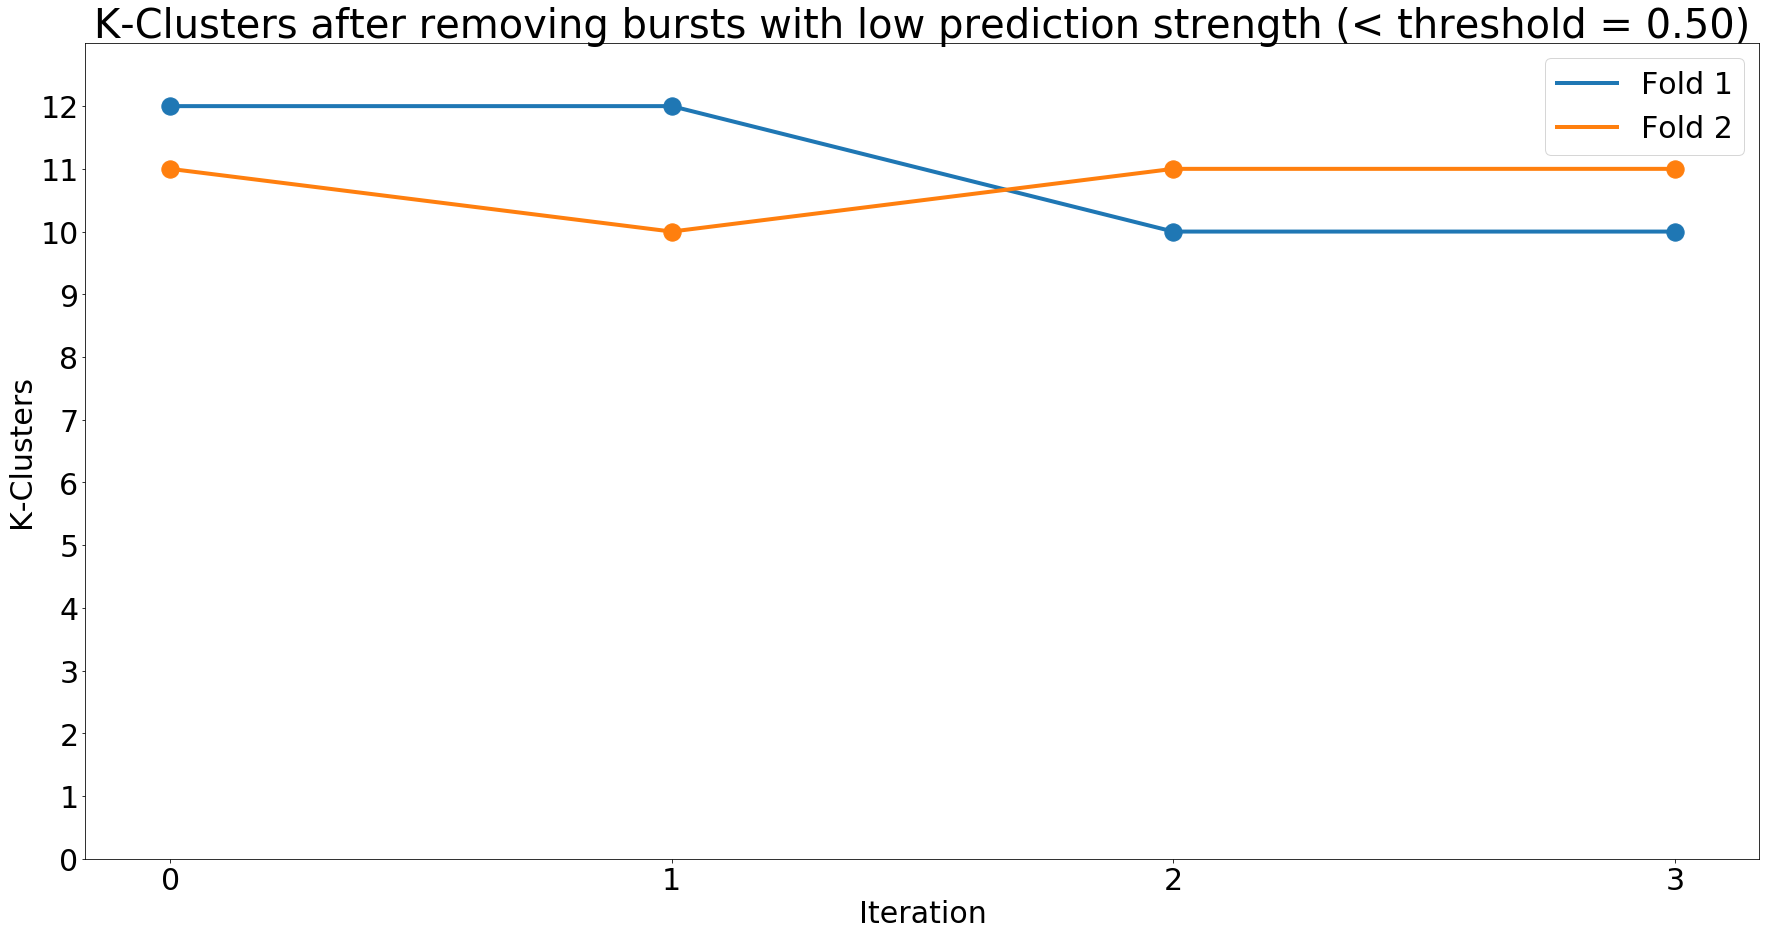

In [30]:
n_folds = 2
threshold = 0.5
fig, ax = plt.subplots(figsize=(30,15))
color = ["C%d" %i for i in range(10)]
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(k_clusters_per_fold_and_iteraton))
for i in range(n_folds): # per fold 
    ax.scatter(iterations, np.asarray(k_clusters_per_fold_and_iteraton)[:,i], s = 300, color = color[i])
    ax.plot(iterations, np.asarray(k_clusters_per_fold_and_iteraton)[:,i],label = "Fold %d" % (i+1), linewidth = 4,color = color[i])
ax.legend(fontsize = 30)
ax.set_title("K-Clusters after removing bursts with low prediction strength (< threshold = %.2f)" % threshold, fontsize = 40)
ax.set_ylim((0,13))
ax.set_yticks(range(0,13))
ax.set_xticks(range(len(k_clusters_per_fold_and_iteraton)))
ax.set_ylabel("K-Clusters", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)

[[0.0, 0.0], [1.3400000000000001, 7.21], [2.3199999999999998, 16.900000000000002], [3.3099999999999996, 16.969999999999999], [3.3099999999999996, 39.800000000000004], [3.71, 39.890000000000001], [3.71, 44.289999999999999], [3.71, 44.299999999999997], [3.71, 44.310000000000002], [3.71, 44.310000000000002]]


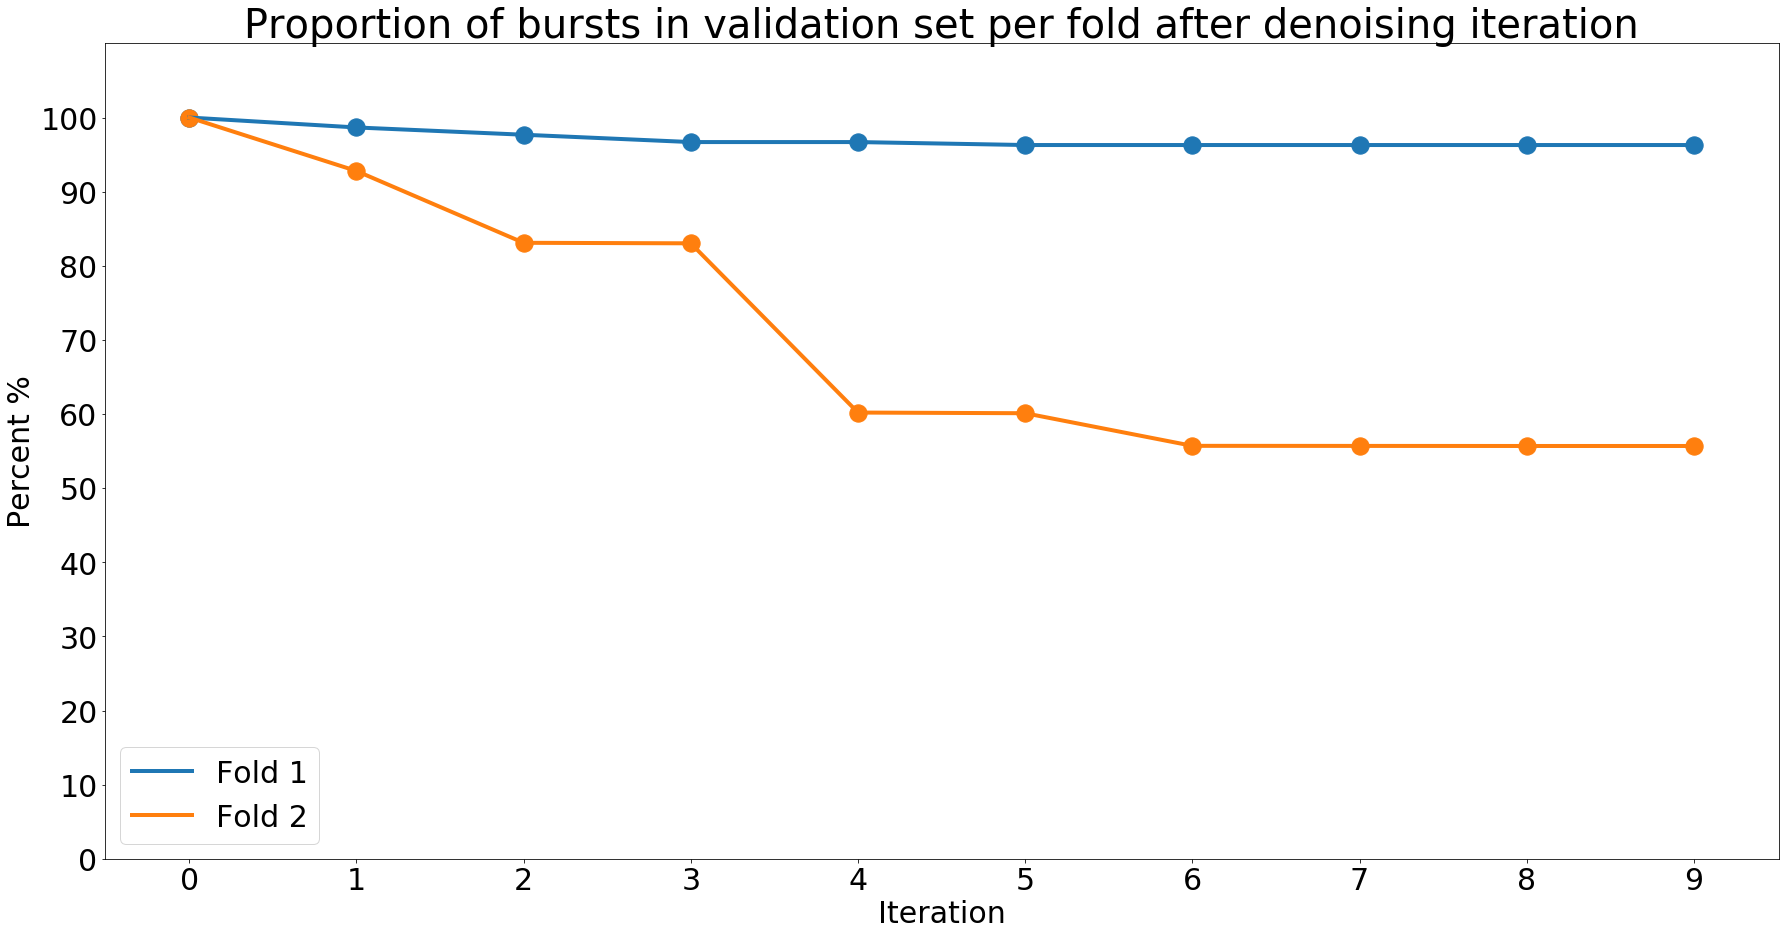

In [36]:
n_folds = 2
print(reduction_in_percent_per_iteration)
fig, ax = plt.subplots(figsize=(30,15))
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(reduction_in_percent_per_iteration))
for i in range(n_folds): # per fold 
    ax.scatter(iterations, 100 - np.asarray(reduction_in_percent_per_iteration)[:,i], s = 300,color = color[i])
    ax.plot(iterations, 100 - np.asarray(reduction_in_percent_per_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4, color = color[i])
ax.legend(fontsize = 30)
ax.set_title("Proportion of bursts in validation set per fold after denoising iteration", fontsize = 40)
ax.set_ylabel("Percent %", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)
ax.set_ylim((0,110))
ax.set_yticks(range(0,110,10))
ax.set_xticks(range(len(reduction_in_percent_per_iteration)))

[[0.0, 0.0], [1.1799999999999999, 6.370000000000001], [1.6799999999999999, 6.6199999999999992], [1.72, 15.83], [1.72, 15.83]]


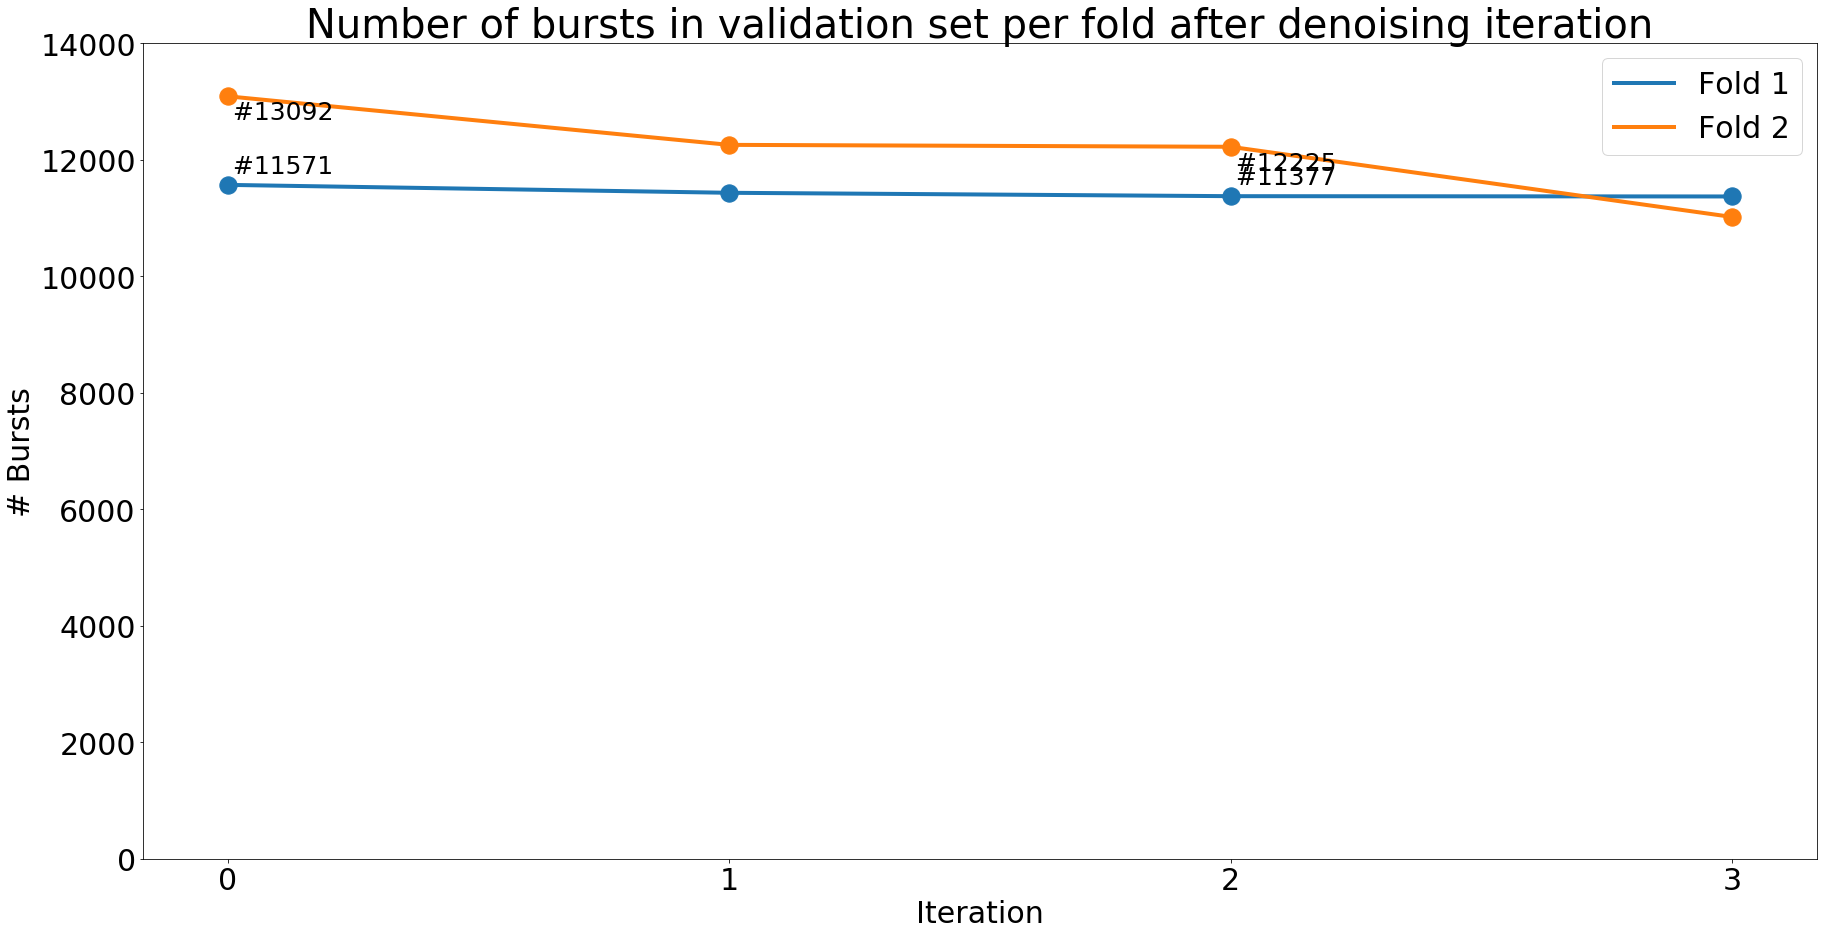

In [32]:
n_folds = 2
print(reduction_in_percent_per_iteration)
fig, ax = plt.subplots(figsize=(30,15))
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(reduction_in_percent_per_iteration[:-1]))
for i in range(n_folds): # per fold 
    n_burst_in_fold_i_per_iteration = np.asarray([len(x[i]) for x in high_ps_valid_folds_after_denoising_per_iteration])
    ax.scatter(iterations, n_burst_in_fold_i_per_iteration[:-1], s = 300,color = color[i])
    ax.plot(iterations, n_burst_in_fold_i_per_iteration[:-1], label = "Fold %d" % (i+1), linewidth = 4, color = color[i])
    for j, n_bursts in enumerate(n_burst_in_fold_i_per_iteration[:-1]):
        if (i == 1) and iterations[j]%2 == 0 and iterations[j] <= 7:# and iterations[j] == 1): #or (i == 1 and iterations[j] == 1): 
            ax.annotate("#%d " % int(n_bursts), (iterations[j]+0.01, n_burst_in_fold_i_per_iteration[j]-(400)), fontsize = 25)
        elif (i == 1) and iterations[j]%2 == 0 and iterations[j] > 7:
            ax.annotate("#%d " % int(n_bursts), (iterations[j]+0.01, n_burst_in_fold_i_per_iteration[j]+(200)), fontsize = 25)
          
        elif (i == 0) and iterations[j]%2 == 0 and iterations[j] <= 7:
            ax.annotate("#%d " % int(n_bursts), (iterations[j]+0.01, n_burst_in_fold_i_per_iteration[j]+(200)), fontsize = 25)
        elif (i == 0) and iterations[j]%2 == 0 and iterations[j] > 7:
            ax.annotate("#%d " % int(n_bursts), (iterations[j]+0.01, n_burst_in_fold_i_per_iteration[j]-(400)), fontsize = 25)


    
    
ax.legend(fontsize = 30)
ax.set_title("Number of bursts in validation set per fold after denoising iteration", fontsize = 40)
ax.set_ylabel("# Bursts", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)
ax.set_ylim((0,14000))
#ax.set_xlim((0,33))
#ax.set_yticks(range(0,6600,100))
ax.set_xticks(range(len(reduction_in_percent_per_iteration[:-1])))

In [34]:
print(k_clusters_per_fold_and_iteraton[11])
print(n_low_bursts)

[17, 17]


In [45]:
k_clusters_per_fold_and_iteraton[1]

[7, 7]

In [76]:
k_clusters_per_fold_and_iteraton[-1]

[10, 10]

In [61]:
np.asarray(predictions_strengths_cv_per_sample_and_iteration[1][0][6][5])

array([ 0.58333333,  0.58333333,  0.58333333,  0.25      ,  0.        ,
        0.58333333,  0.25      ,  0.25      ,  0.58333333,  0.58333333,
        0.25      ,  0.58333333,  0.58333333])

In [163]:
print(final_k_clusters)

19


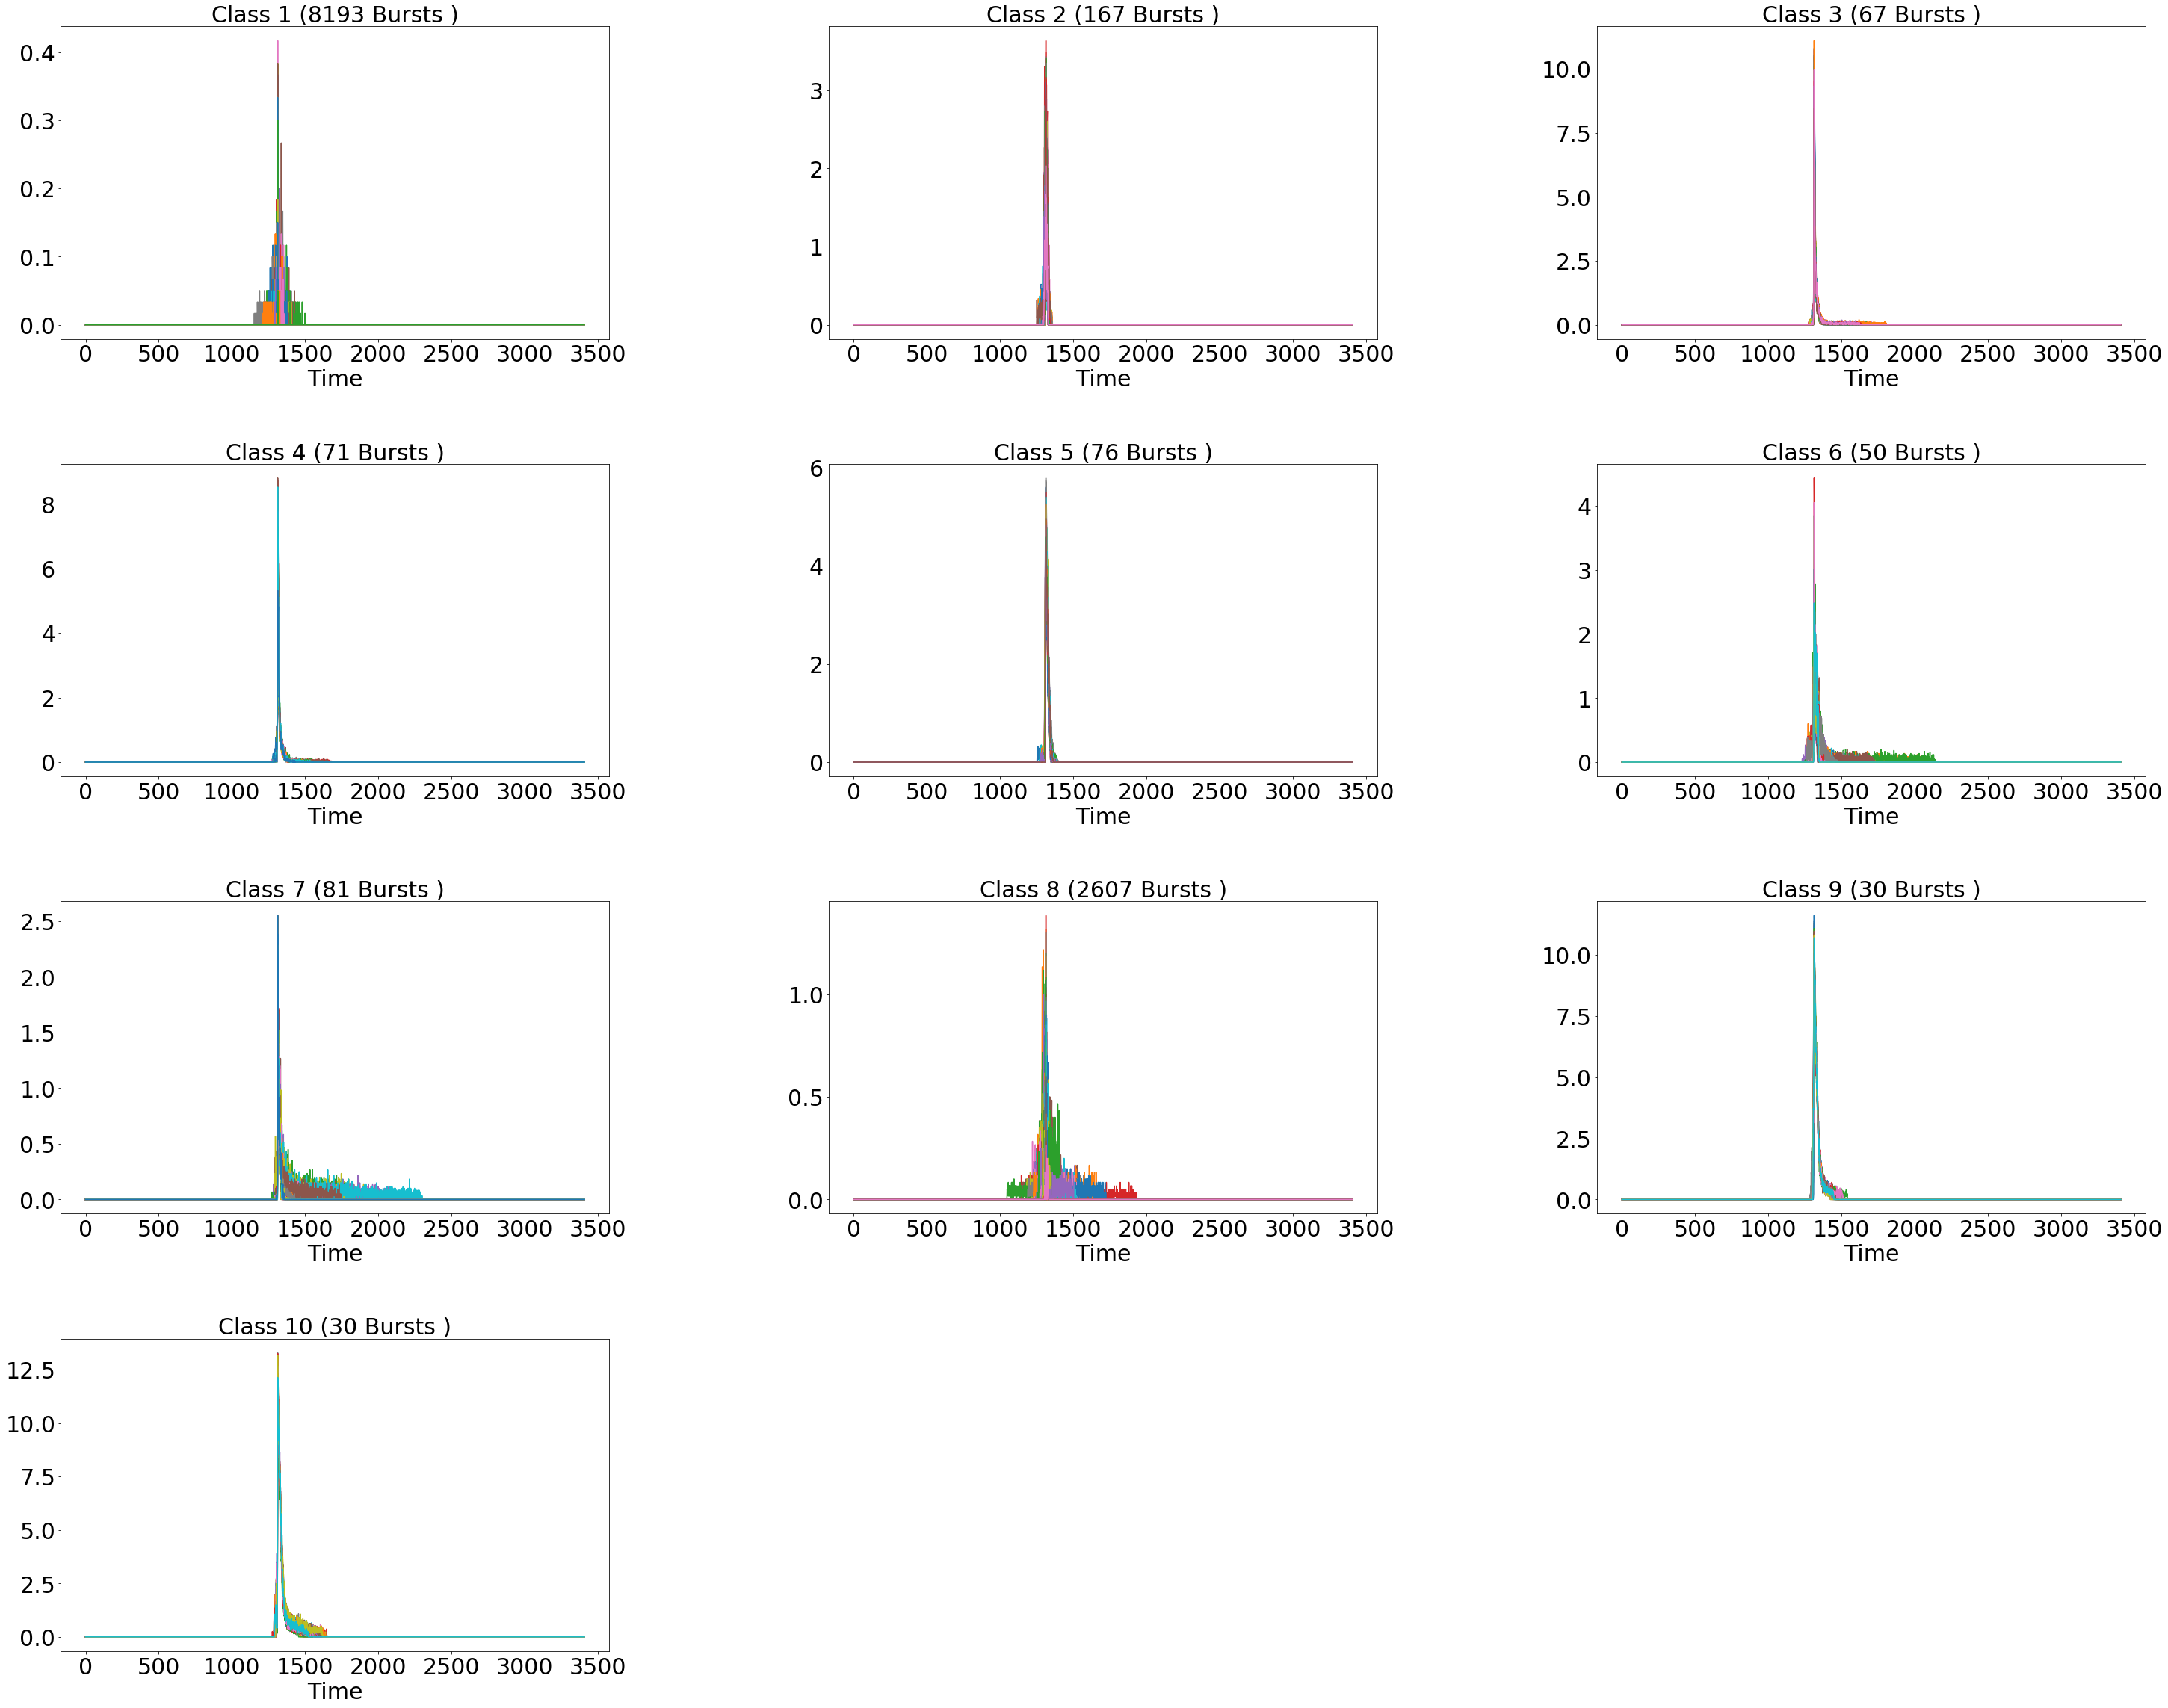

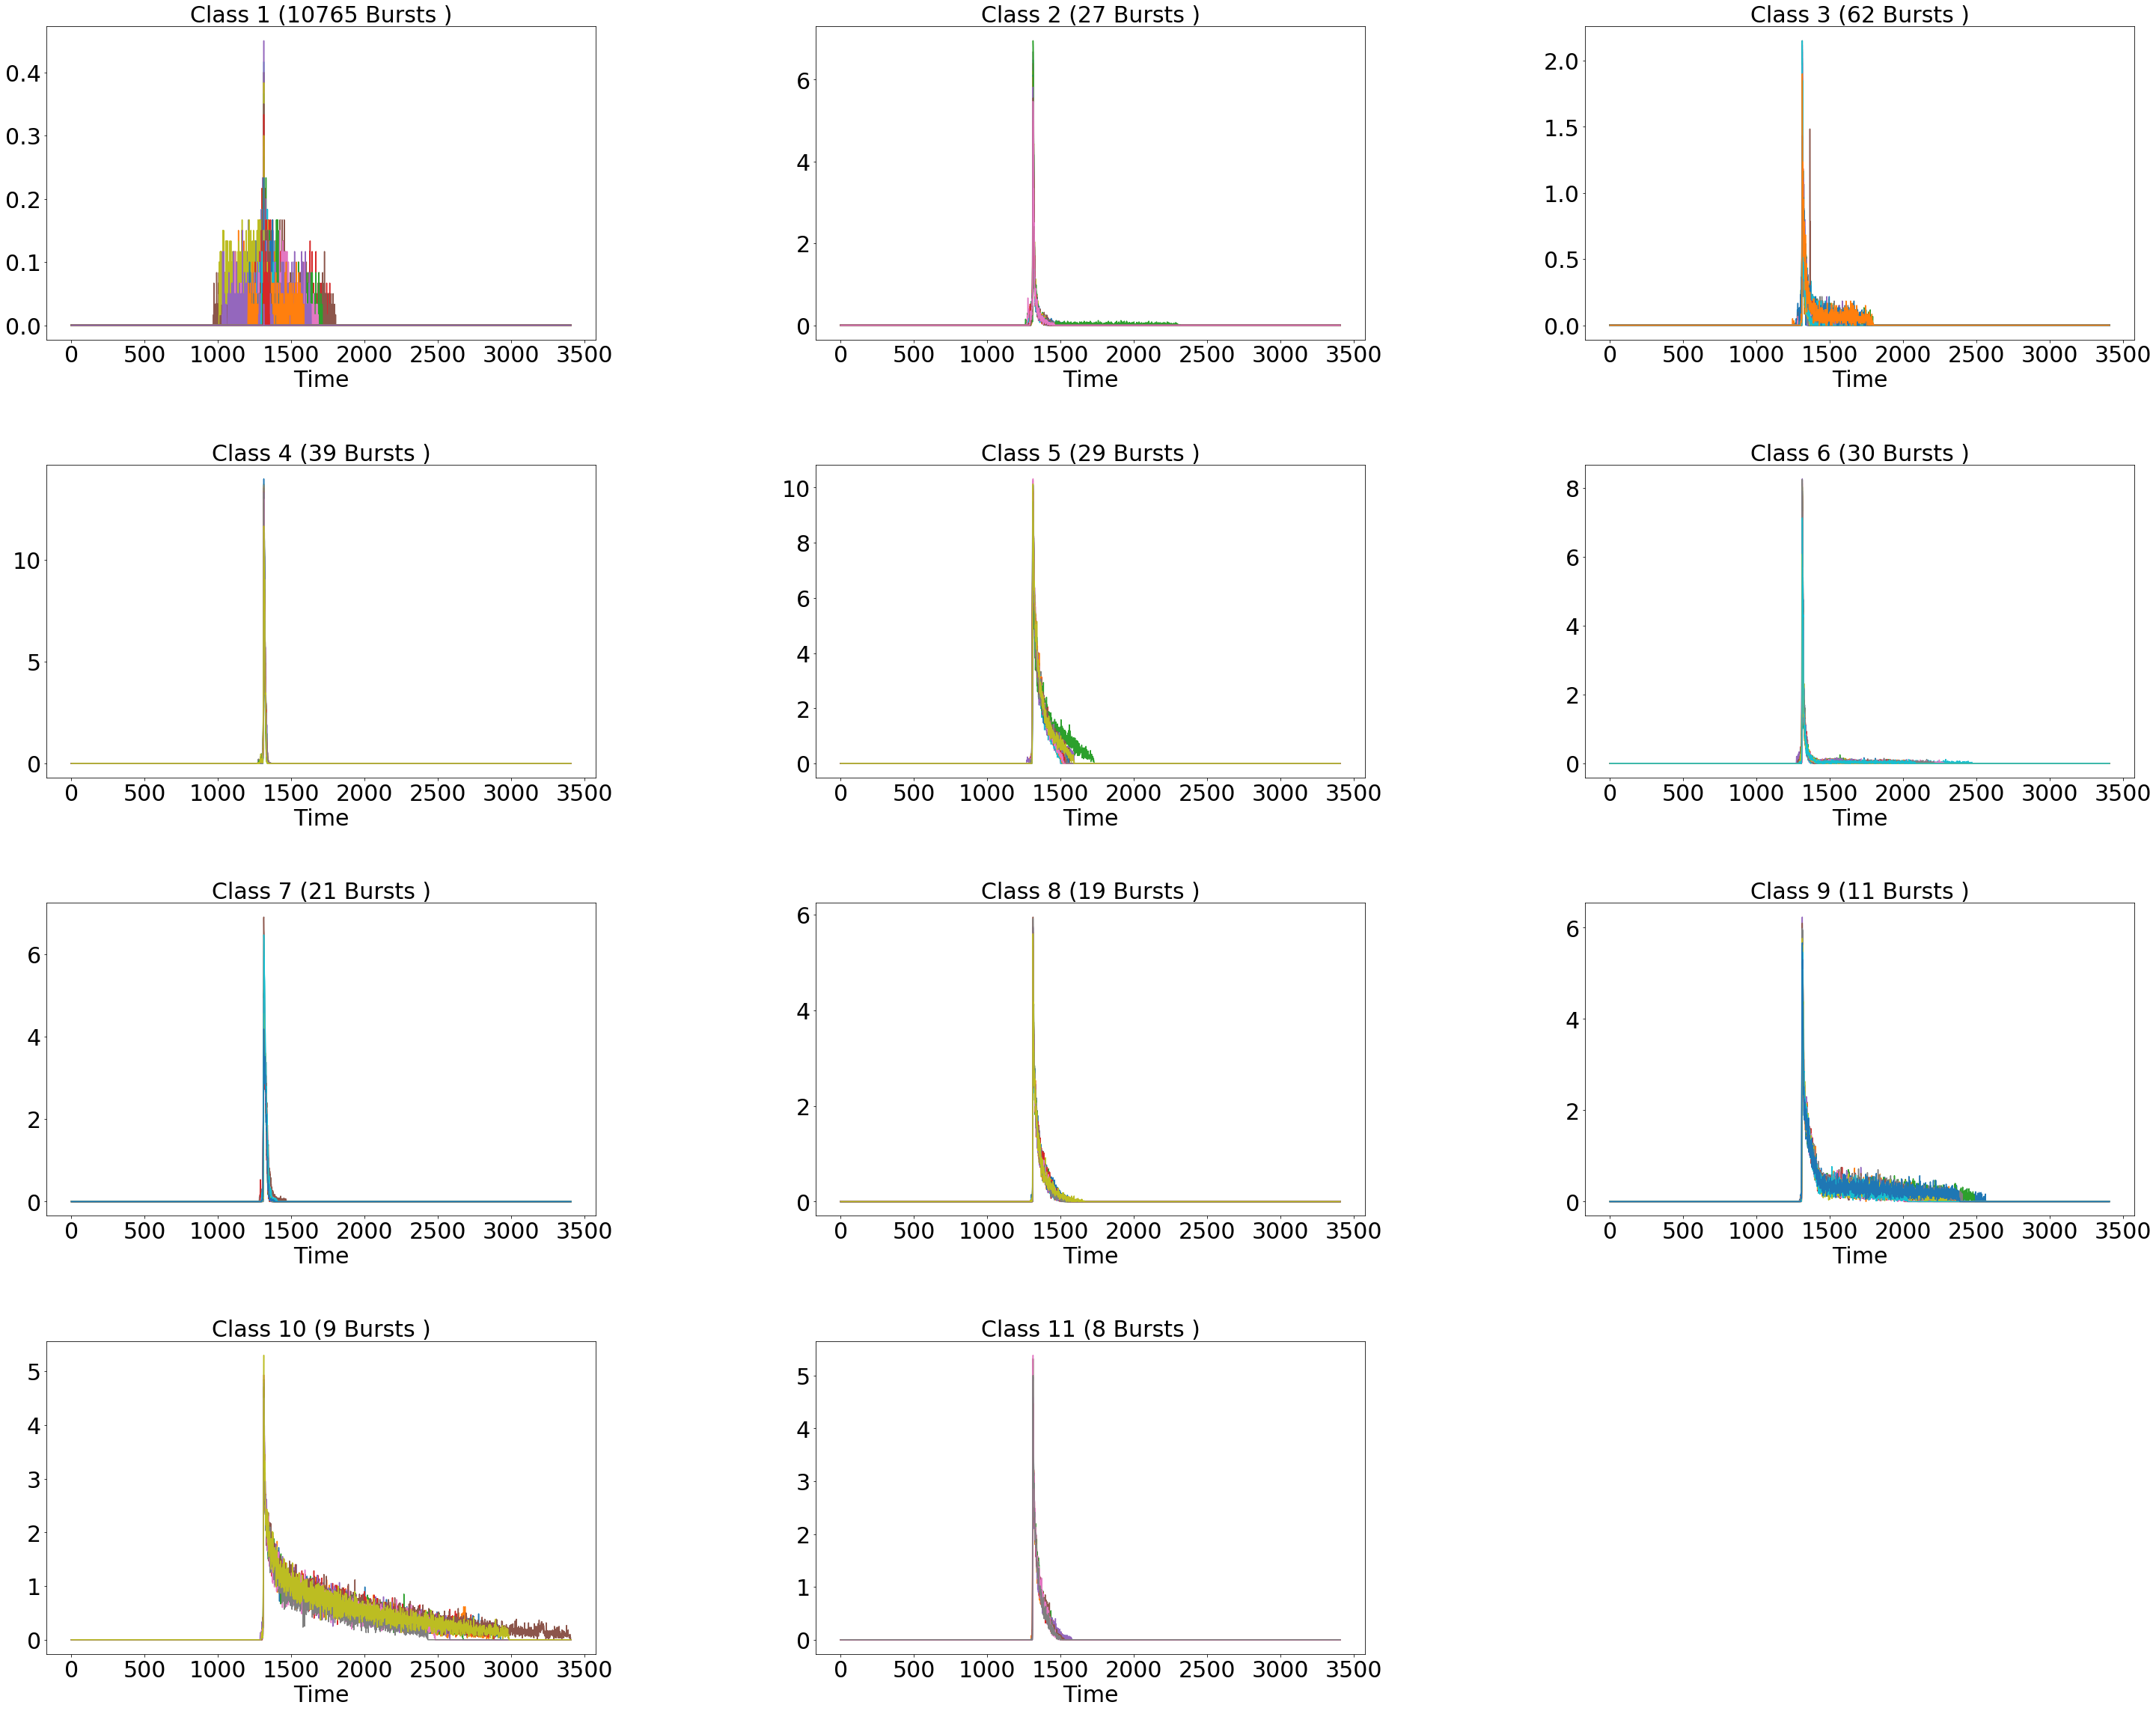

In [33]:
from ipynb.fs.defs.prediction_strength import plot_cluster_examples
k_clusters_after_denoising = k_clusters_per_fold_and_iteraton[-1]
high_ps_valid_folds_after_denoising = high_ps_valid_folds_after_denoising_per_iteration[-1]
high_ps_valid_fold_labels_after_denoising = valid_fold_labels_per_iteration[-1]
for i, k in enumerate(k_clusters_after_denoising):
    plot_cluster_examples(data[high_ps_valid_folds_after_denoising[i]],high_ps_valid_fold_labels_after_denoising[i][k-1],k,figsize=(50, 40))

## Plot Clusters with discarded Bursts 

### a) overall

### b) per iteration

### a)

In [99]:
k_clusters_after_denoising = k_clusters_per_fold_and_iteraton[-1]
high_ps_valid_folds_after_denoising = high_ps_valid_folds_after_denoising_per_iteration[-1]
high_ps_valid_fold_labels_after_denoising = valid_fold_labels_per_iteration[-1]

discarded_bursts_per_fold = [list(fold) for fold in valid_folds]

for f, fold in enumerate(discarded_bursts_per_fold):
    for burst in high_ps_valid_folds_after_denoising[f]:   
        fold.remove(burst)  

        
int_k_clusters = [10,10]        
discarded_burst_init_labels = []
for f,fold in enumerate(discarded_bursts_per_fold):
    discarded_labels_i = []
    for burst in fold:
        discarded_labels_i += list(valid_fold_labels[f][int_k_clusters[f]-1][np.where(valid_folds[f] == burst)[0]])
    discarded_burst_init_labels.append(np.asarray(discarded_labels_i))

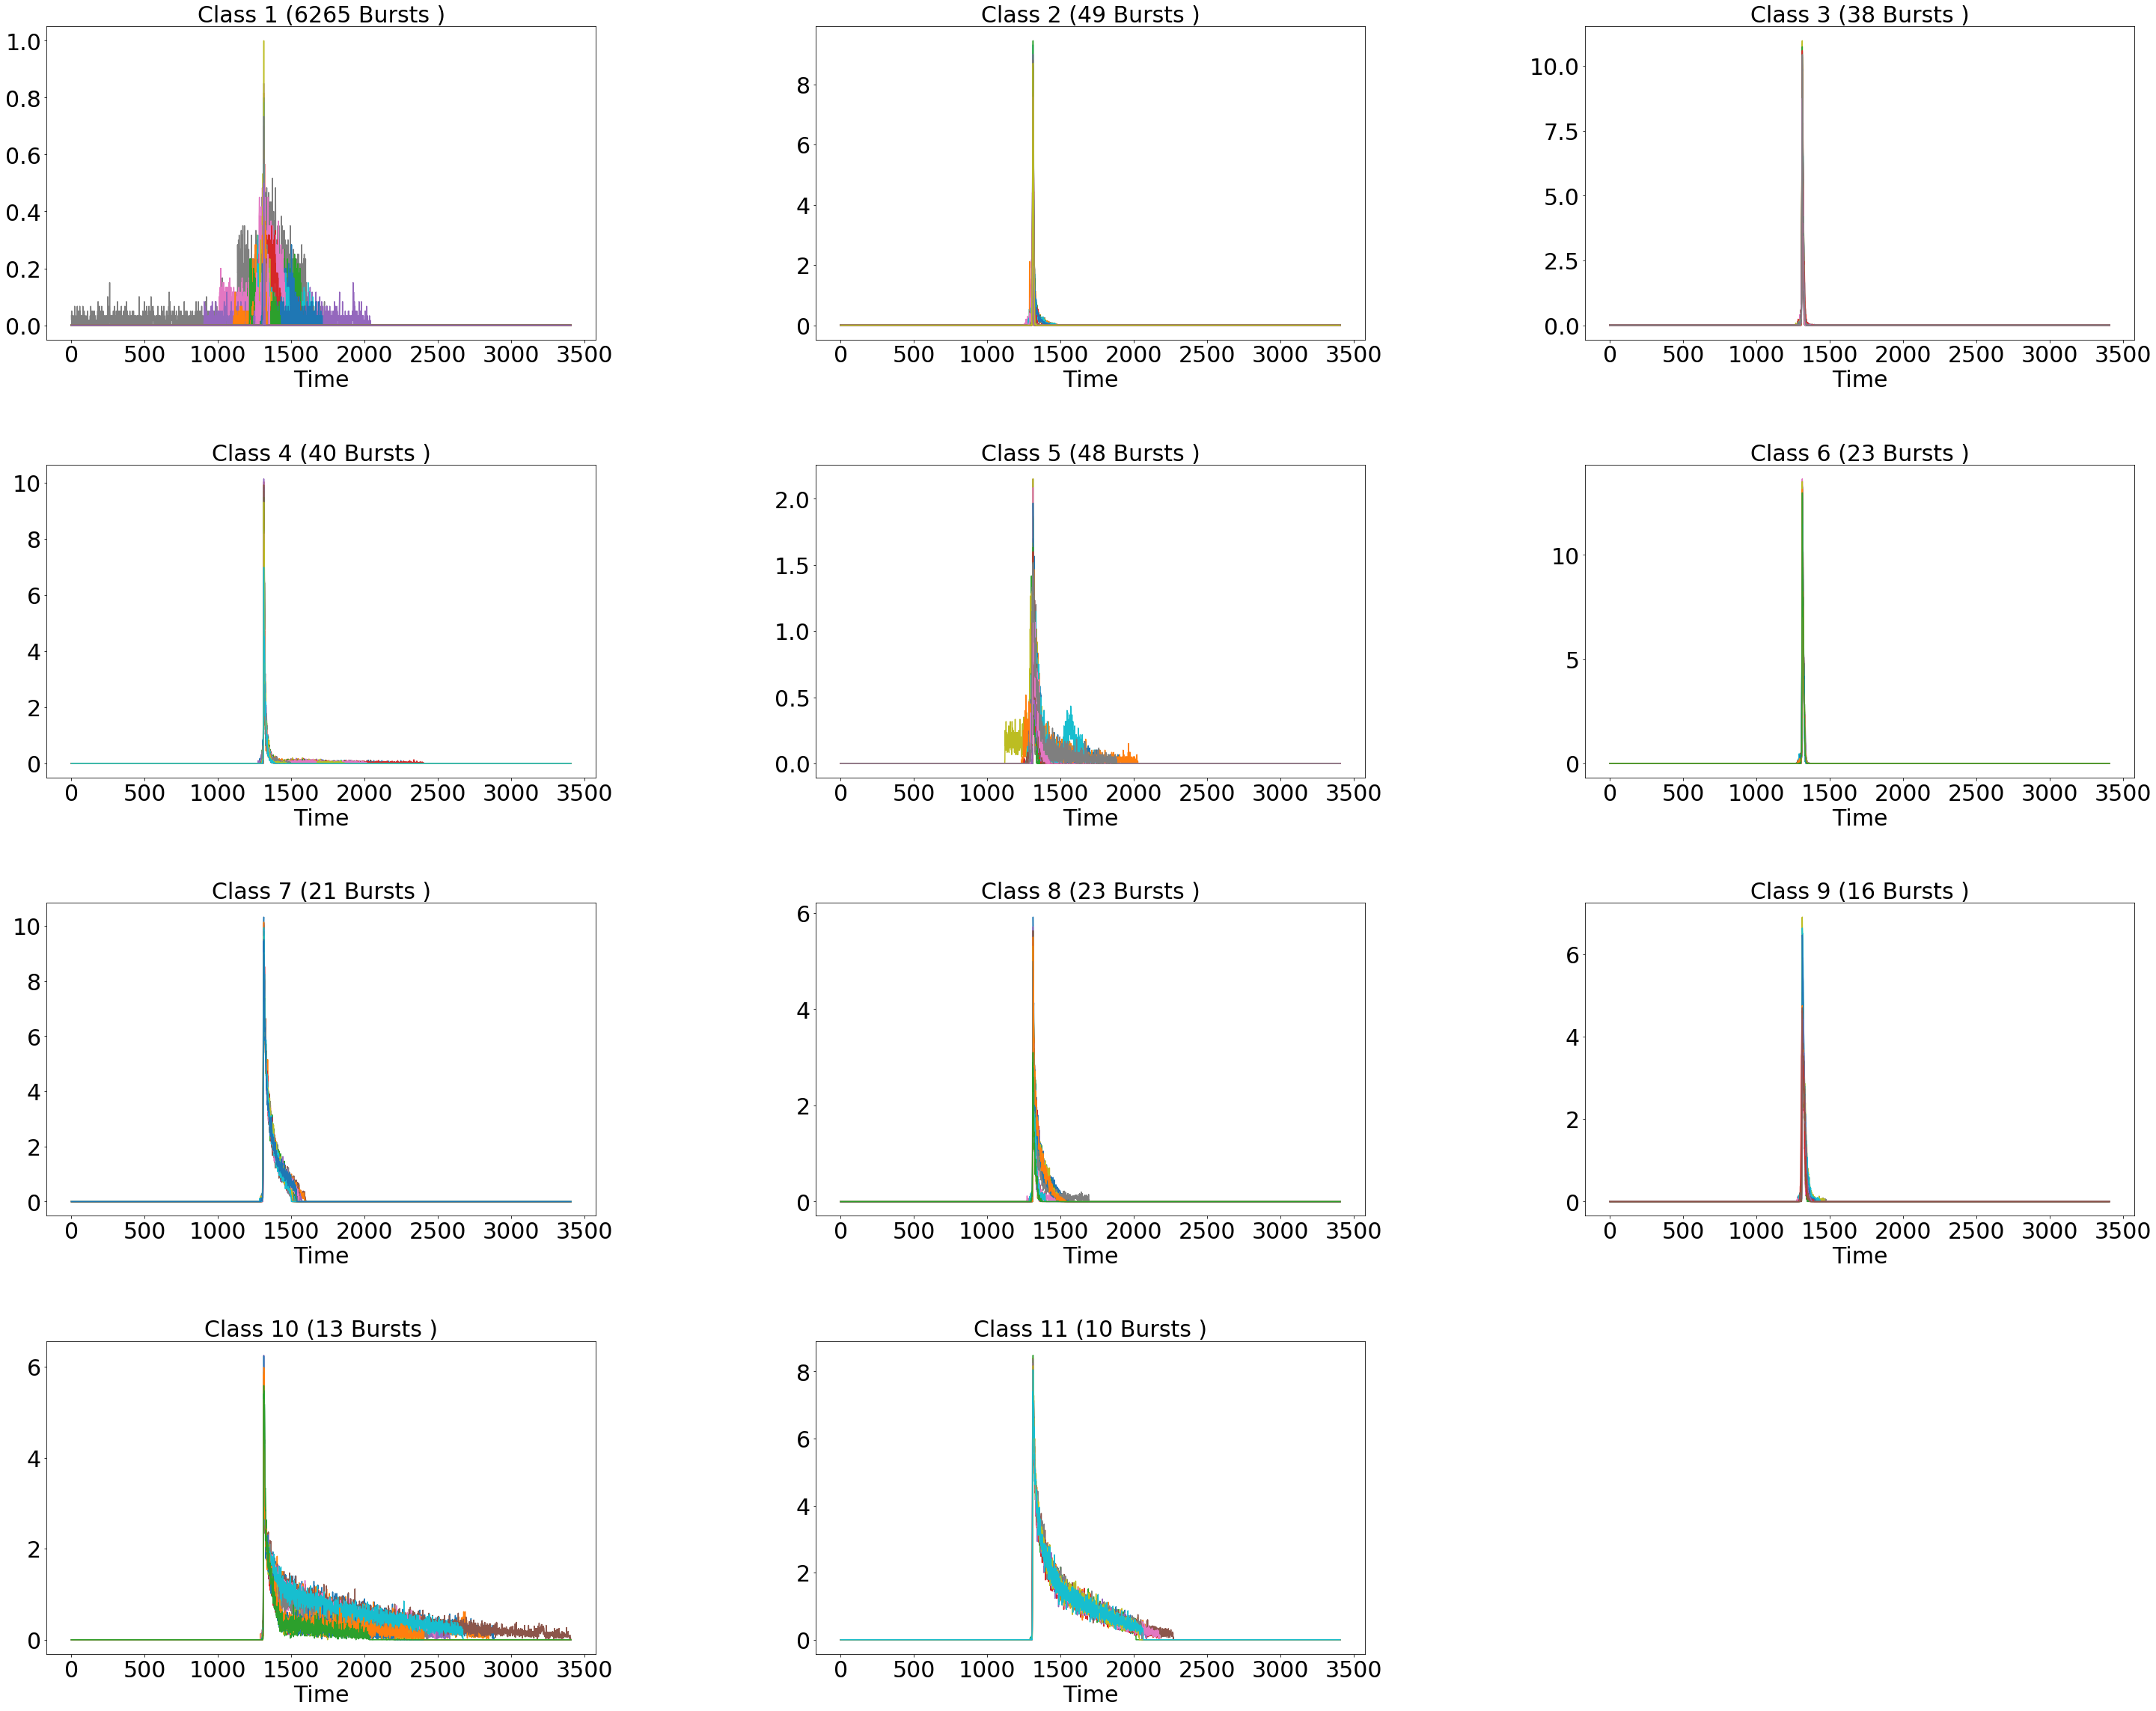

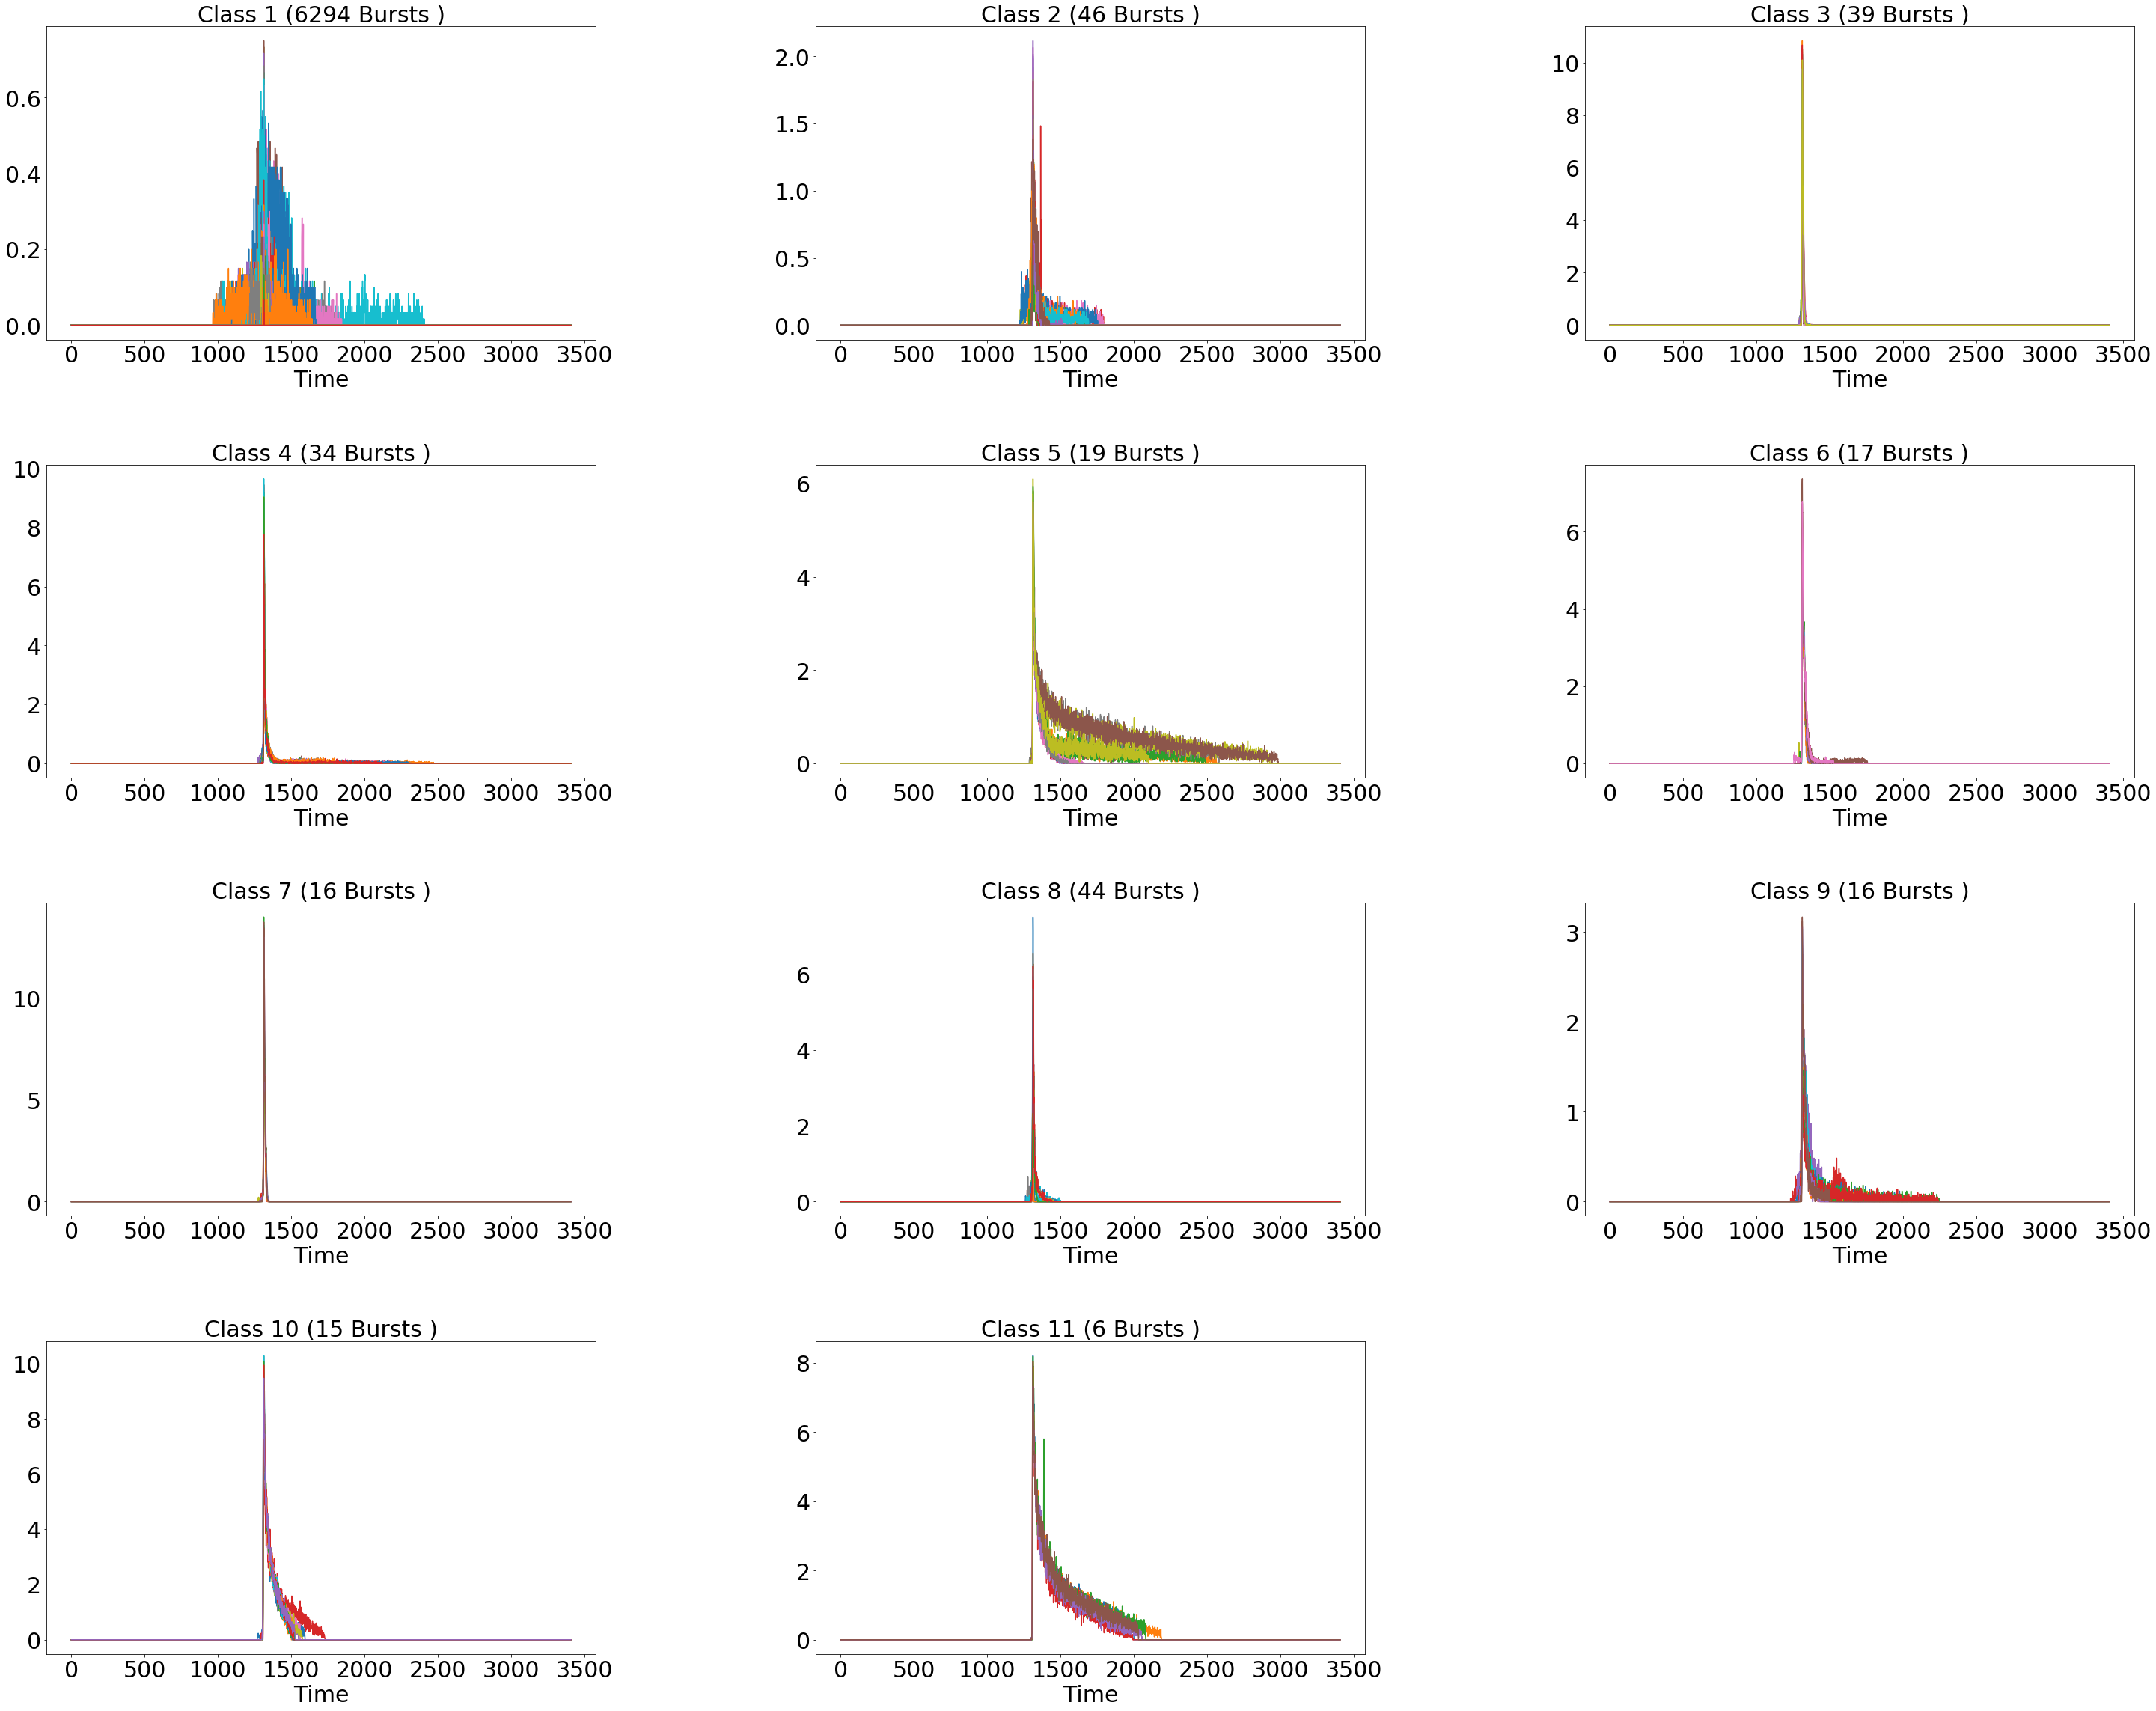

In [97]:
int_k_clusters = [11,11]
for i, k in enumerate(int_k_clusters):
    plot_cluster_examples(data[valid_folds[i]],valid_fold_labels[i][k-1],k,figsize=(50, 40))

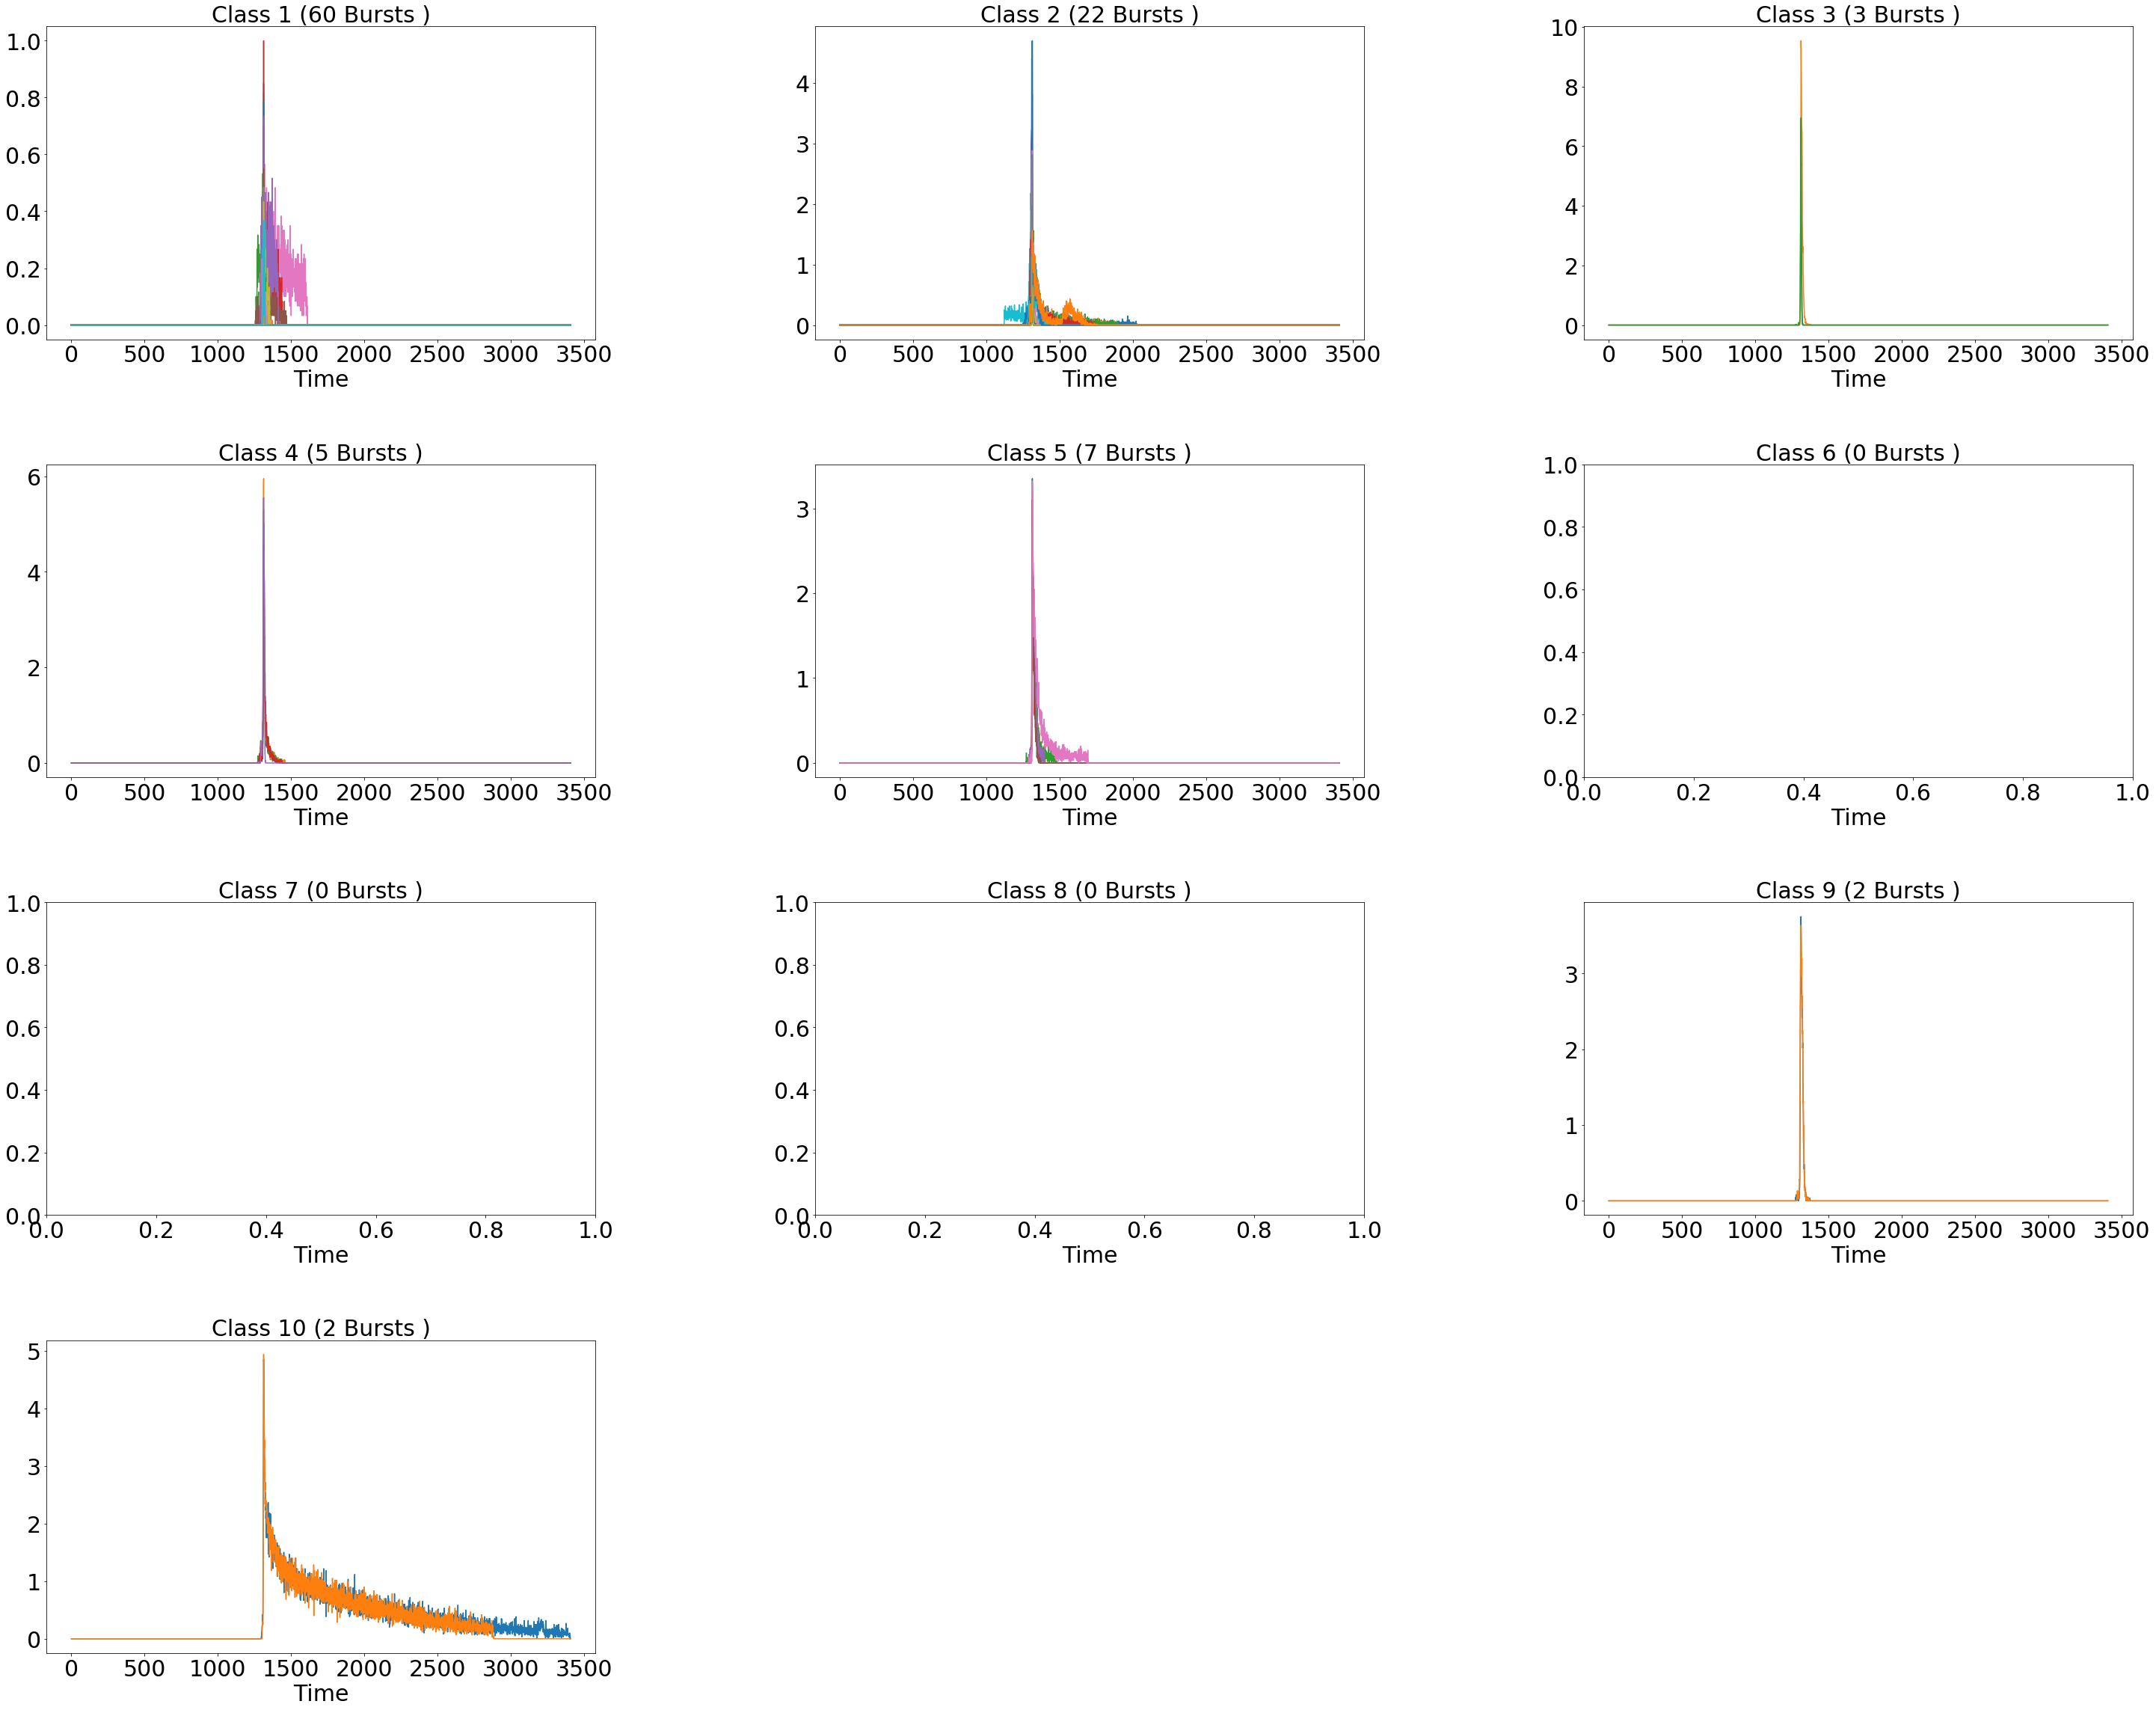

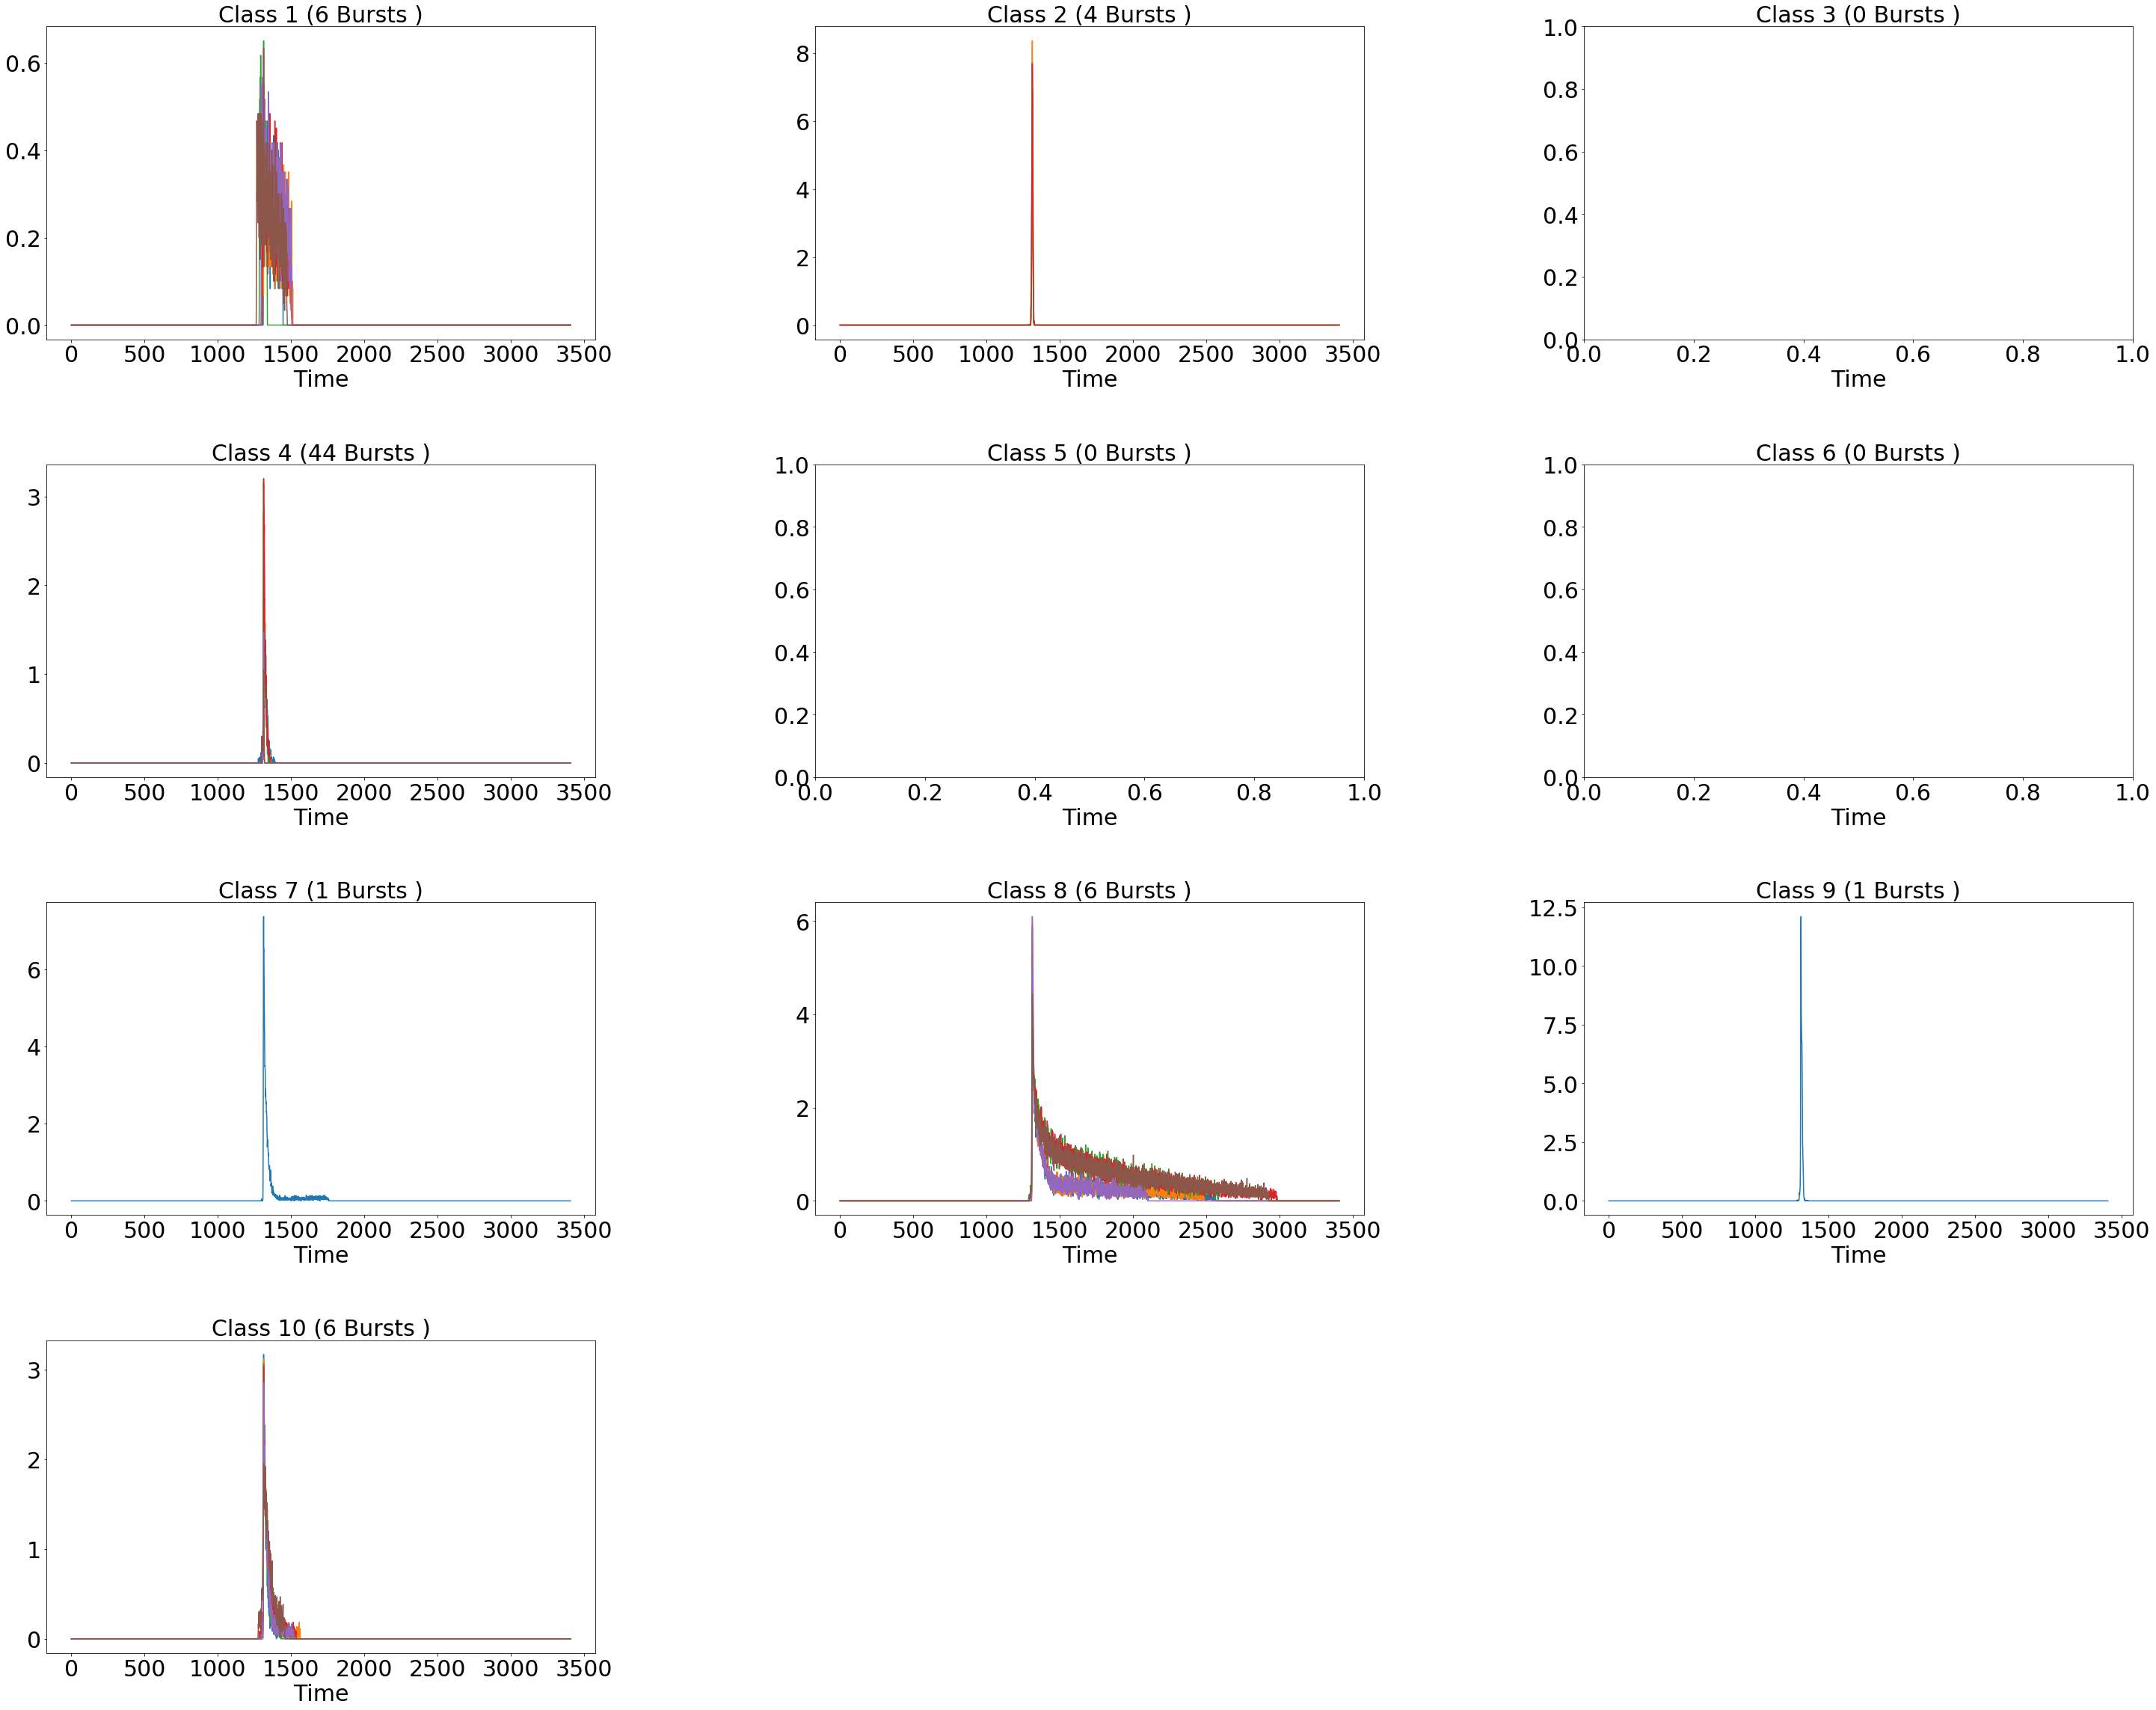

In [100]:
int_k_clusters = [10,10]
for i, k in enumerate(int_k_clusters):
    plot_cluster_examples(data[discarded_bursts_per_fold[i]],discarded_burst_init_labels[i],k,figsize=(50, 40))

### b)

In [46]:
def get_low_individual_ps_bursts(data, train_folds, valid_folds, train_fold_labels, valid_fold_labels ,predictions_strengths_cv_per_samples, n_clusters = range(1,21), threshold = 0.8):
    """ extract burst indices for burst with low individual prediction strength for clustering with k clusters per cluster
    Args:
        data (nd.array): Array containing data (n x m)
        train_folds (list of nd.arrays): list of k training set indices each with dimension n-(n/k) x m
        valid_folds (list of nd.arrays): list of k validation set indices each with dimension n/k x m
        train_fold_labels (list of lists): list of lists containing the cluster labels for each point in training set
        valid_fold_labels (list of lists): list of lists containing the cluster labels for each point in validation set
        predictions_strengths_cv_per_samples(list of lists): list of lists containin the prediction strength for individual bursts in each cluster by clustering with k clusters for each folds 
                                                             1. dim n-folds 2.dim n-clusters 3.dim prediction strength for each cluster i in clustering with k clusters 
        n_clusters (nd.array): range of clusters to use for clustering
        n_folds (int): number of folds the data is splitted 
        threshold (float): cutoff for defining low individual prediction strength                                                    
    
    Returns:
        k_low_individual_ps_cv (list of lists): list of lists containin the burst indices for bursts with individual ps below threshold  strength for individual bursts in each cluster by clustering with k clusters for each folds 
                                                keys = n_clusters  values = k_folds x n_clusters (burst indices of bursts from validation set with individual ps below threshold for each cluster) 
    
    """     
    
    
    k_low_individual_ps_cv = {}
    k_low_individual_ps_cv_sizes = {}
    k_low_individual_ps_cv_sizes_prop = {}
    
    for i in n_clusters: # for each clustering ranging from 1 to max n_clusters 
        k_low_individual_ps_cv[i] = []
        k_low_individual_ps_cv_sizes[i] = []
        k_low_individual_ps_cv_sizes_prop[i] = []
    
    for f, fold in enumerate(predictions_strengths_cv_per_samples): # for each fold
        train_fold = train_folds[f] # training set for fold k splitting
        valid_fold = valid_folds[f] # validation set for fold k splitting
        
        train_labels = train_fold_labels[f] # labels for training set  
        valid_labels = valid_fold_labels[f] # labels for validation set 
        
        for j,k in enumerate(fold): # for each clustering j with k clusters prediction strenght of fold 
            train_labels_k = train_labels[j] 
            valid_labels_k = valid_labels[j]
            
            #print(j, len(train_labels_k),len(valid_labels_k))
            
            k_low_individual_ps_cv_k = []
            k_low_individual_ps_cv_sizes_k = []
            k_low_individual_ps_cv_sizes_prop_k = []
            
            #print(len(np.concatenate(predictions_strengths_cv_per_samples[f][j])))
            
            for i in range(j+1):
                index_in_class = np.where(np.asarray(predictions_strengths_cv_per_samples[f][j][i]) < threshold) #get position relative to class
                #print(i)
                #print(np.where(valid_labels_k == i)[0])
                #print(np.where(valid_labels_k == i)[0][index_in_class])
                #print(len(predictions_strengths_cv_per_samples[f][j][i]))
                
                low_predictive_bursts = valid_fold[np.where(valid_labels_k == i)[0][index_in_class]]
                
                k_low_individual_ps_cv_k.append(low_predictive_bursts) #get burst indices relative to overall data
                k_low_individual_ps_cv_sizes_k.append(len(low_predictive_bursts))
                k_low_individual_ps_cv_sizes_prop_k.append(len(low_predictive_bursts)/len(valid_fold[np.where(valid_labels_k == i)[0]]))
            
            k_low_individual_ps_cv[j+1].append(k_low_individual_ps_cv_k)
            k_low_individual_ps_cv_sizes[j+1].append(k_low_individual_ps_cv_sizes_k)
            k_low_individual_ps_cv_sizes_prop[j+1].append(k_low_individual_ps_cv_sizes_prop_k)
            
            
            
    return  k_low_individual_ps_cv,k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop        

In [79]:
threshold = 0.5
n_folds = 2

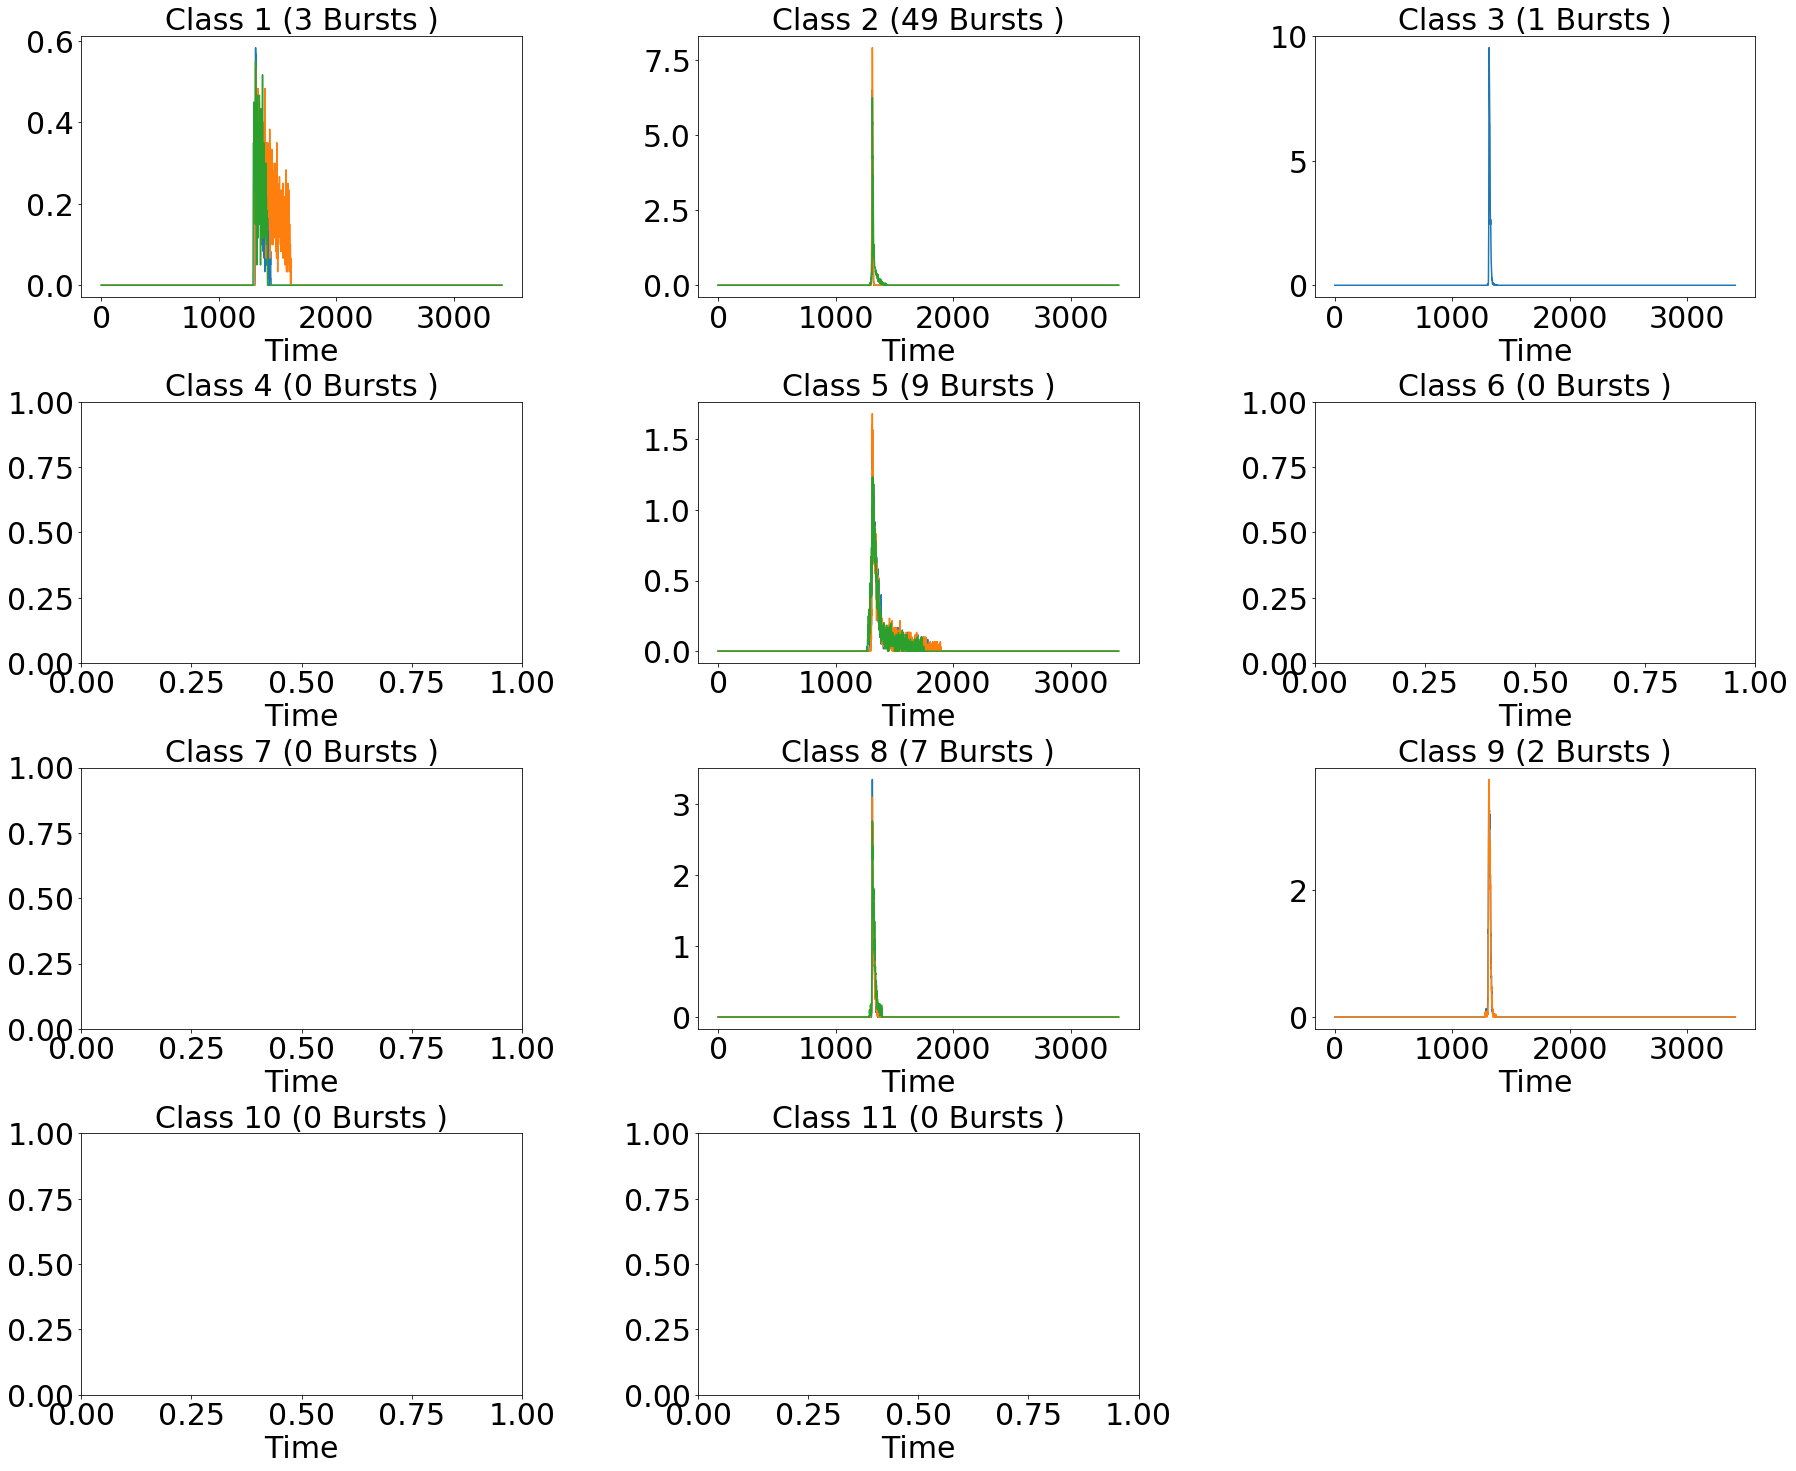

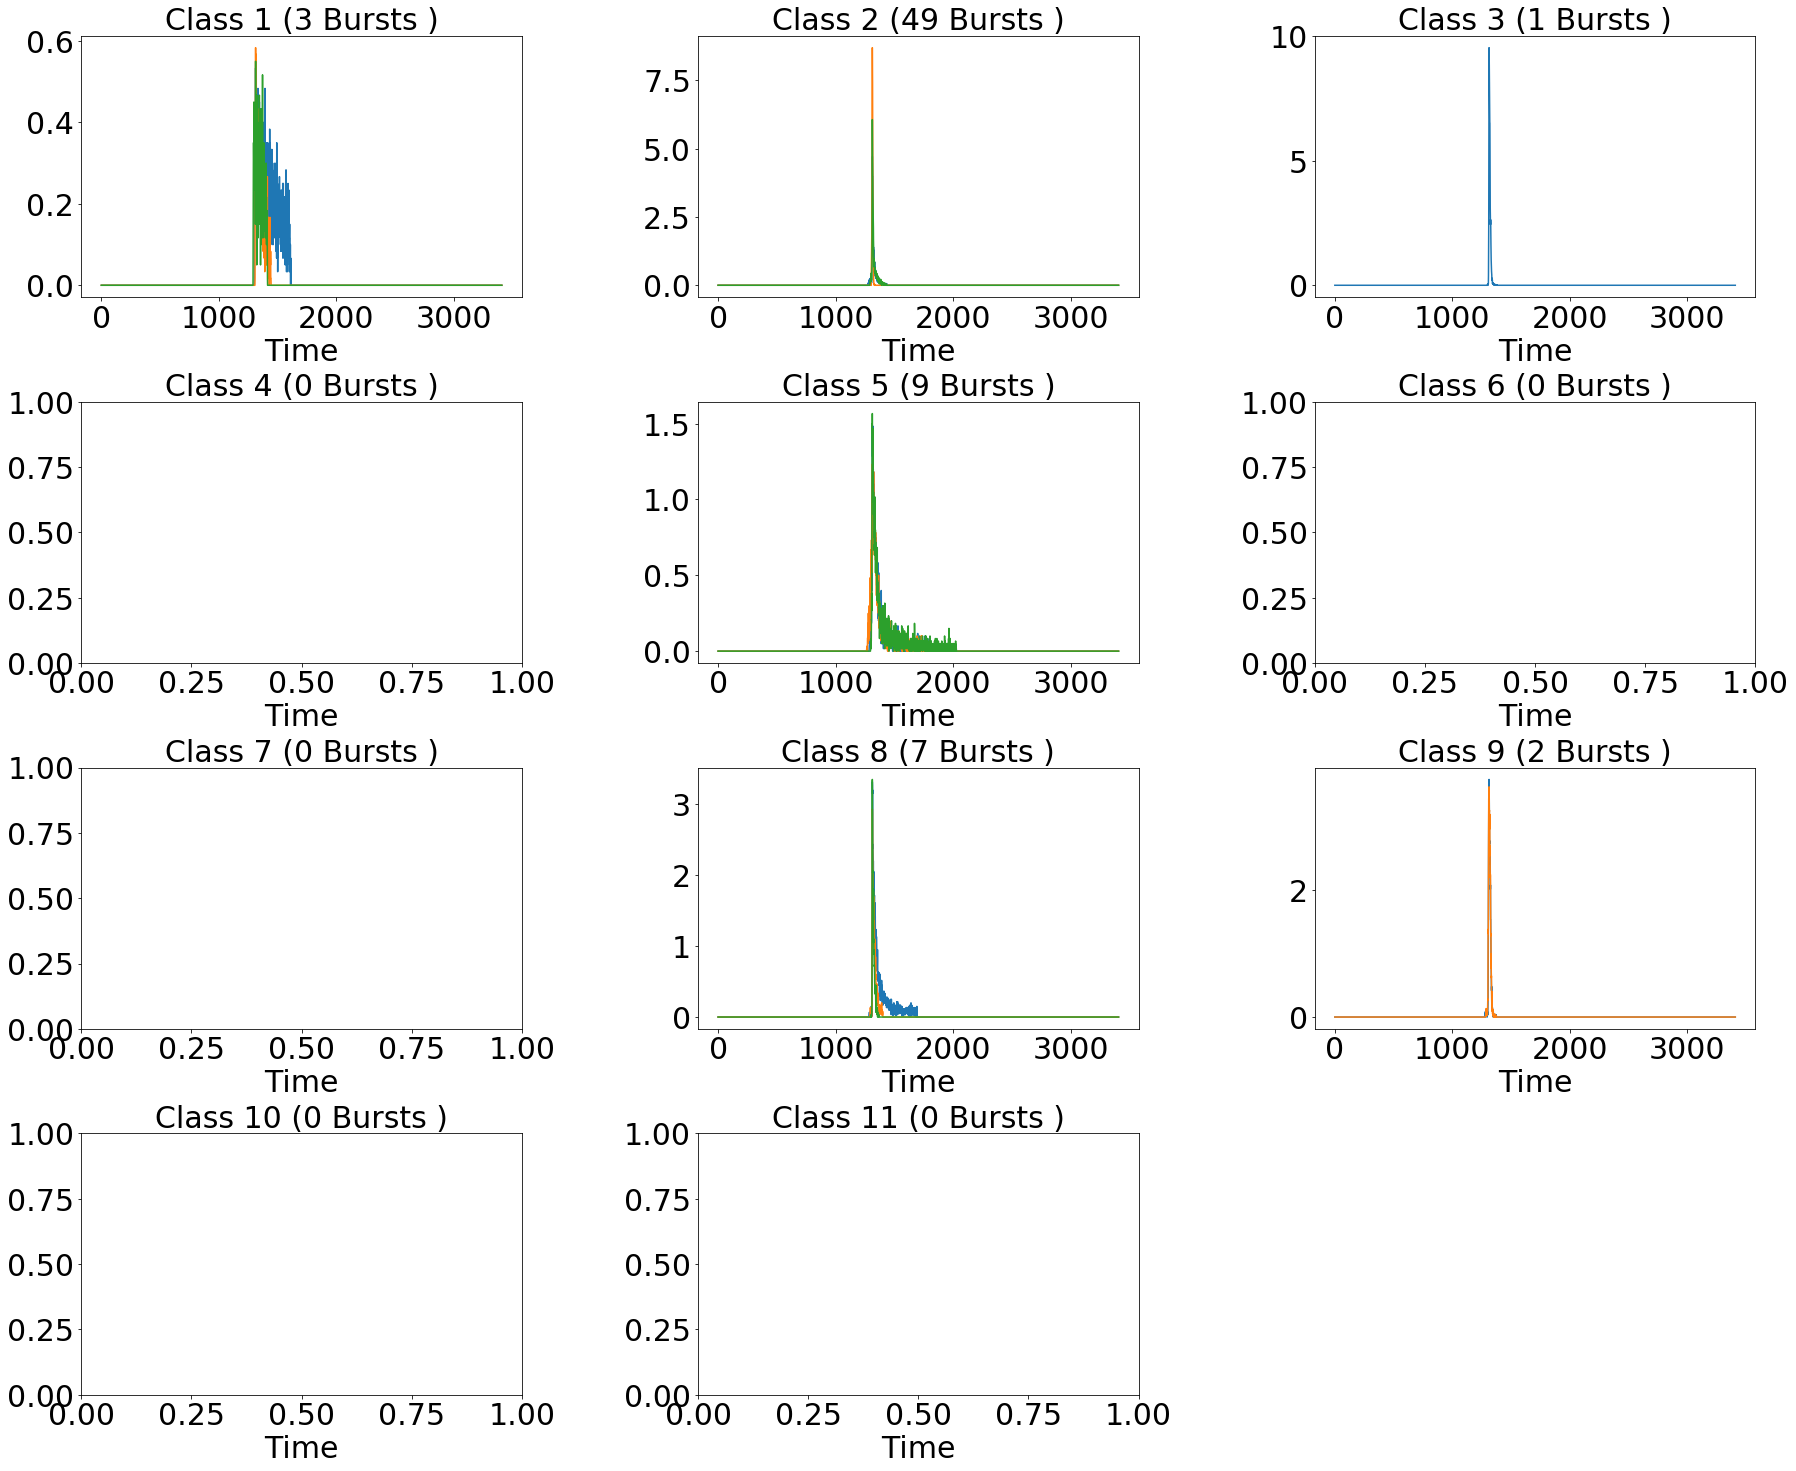

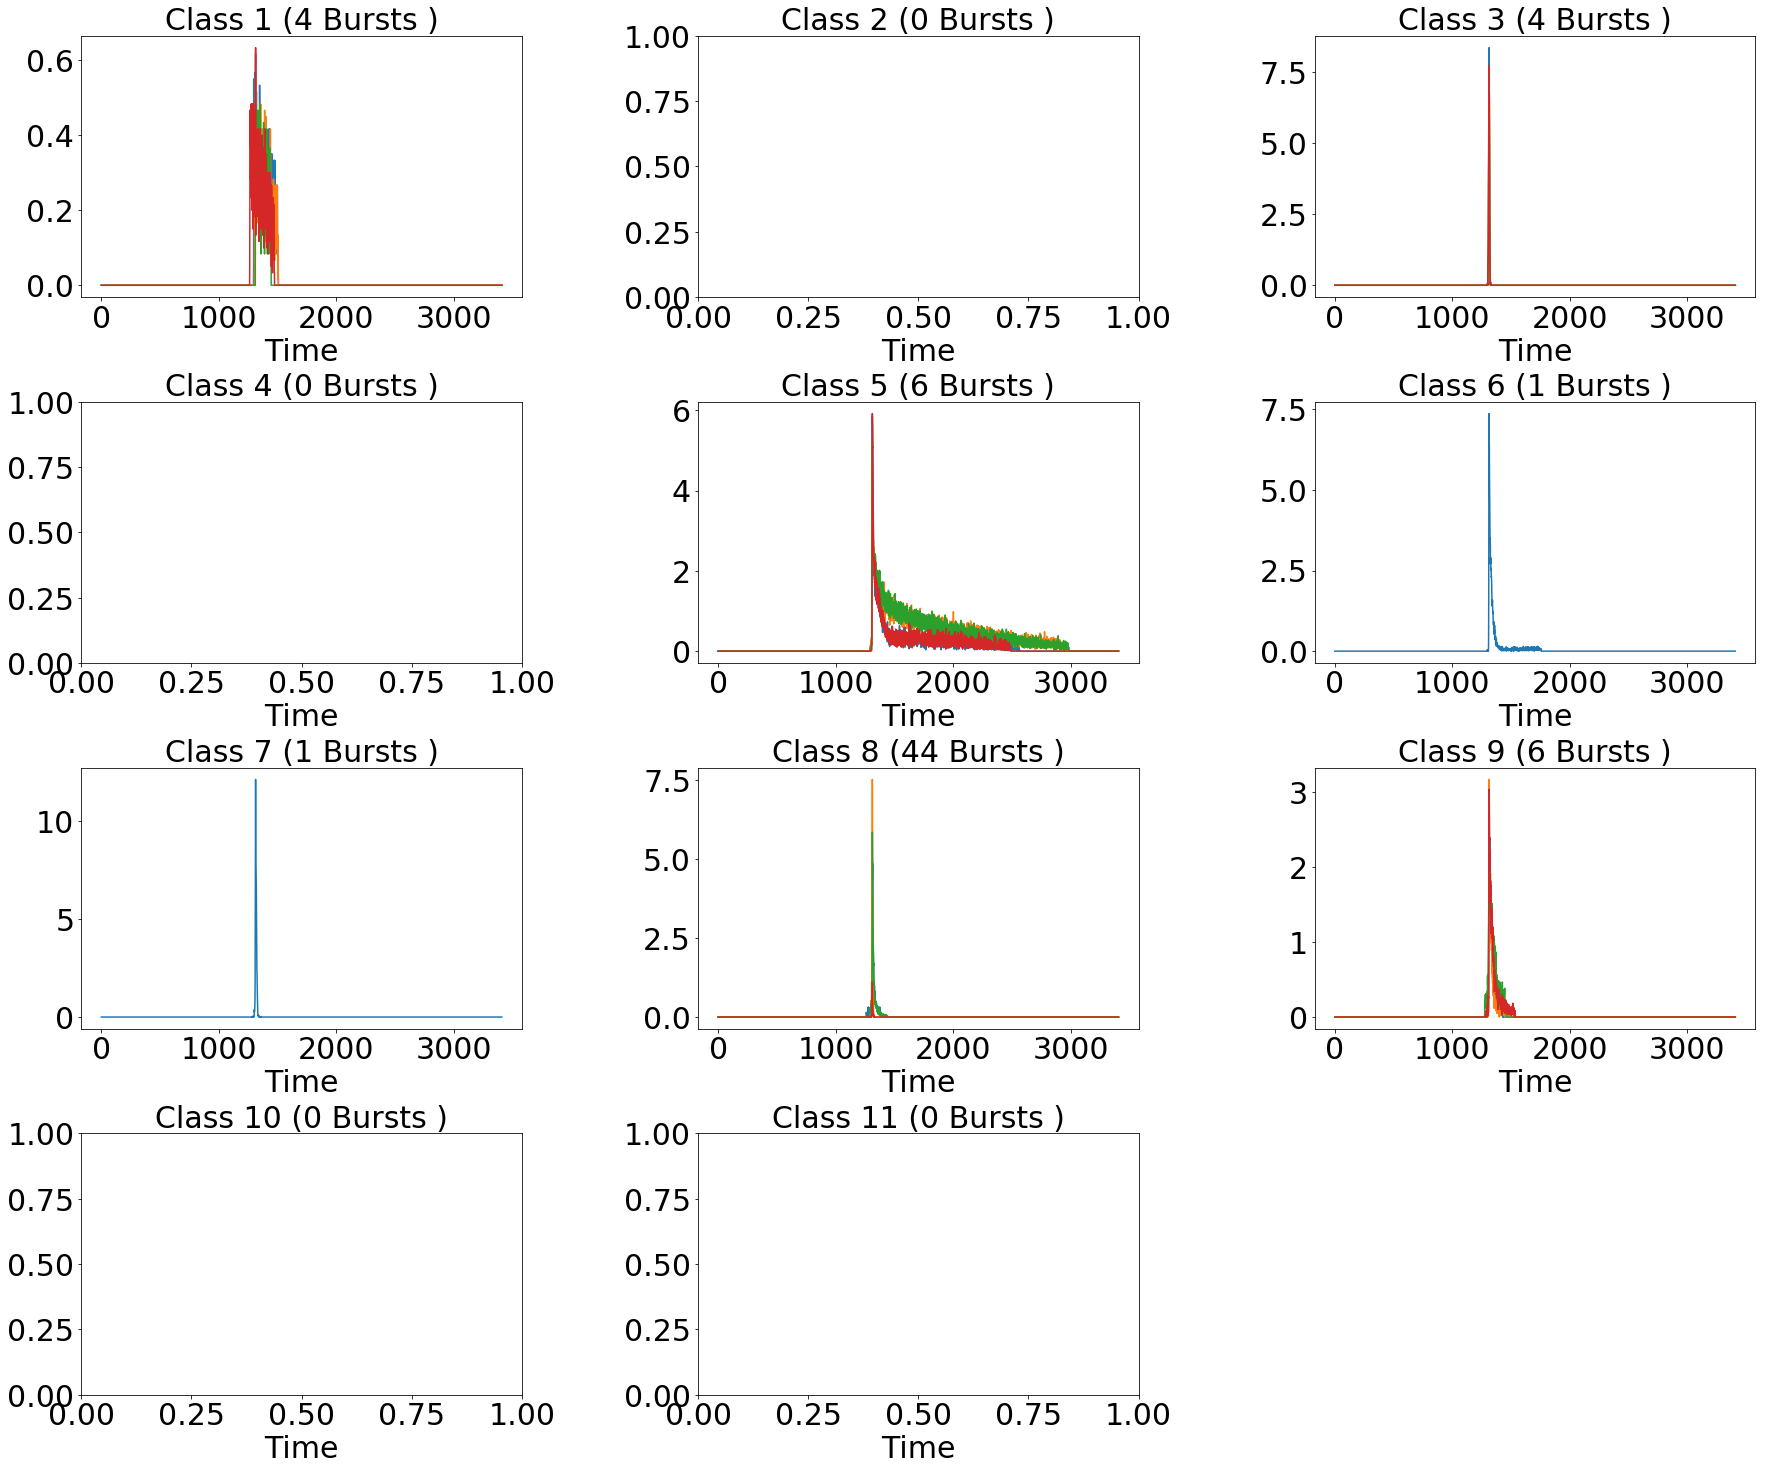

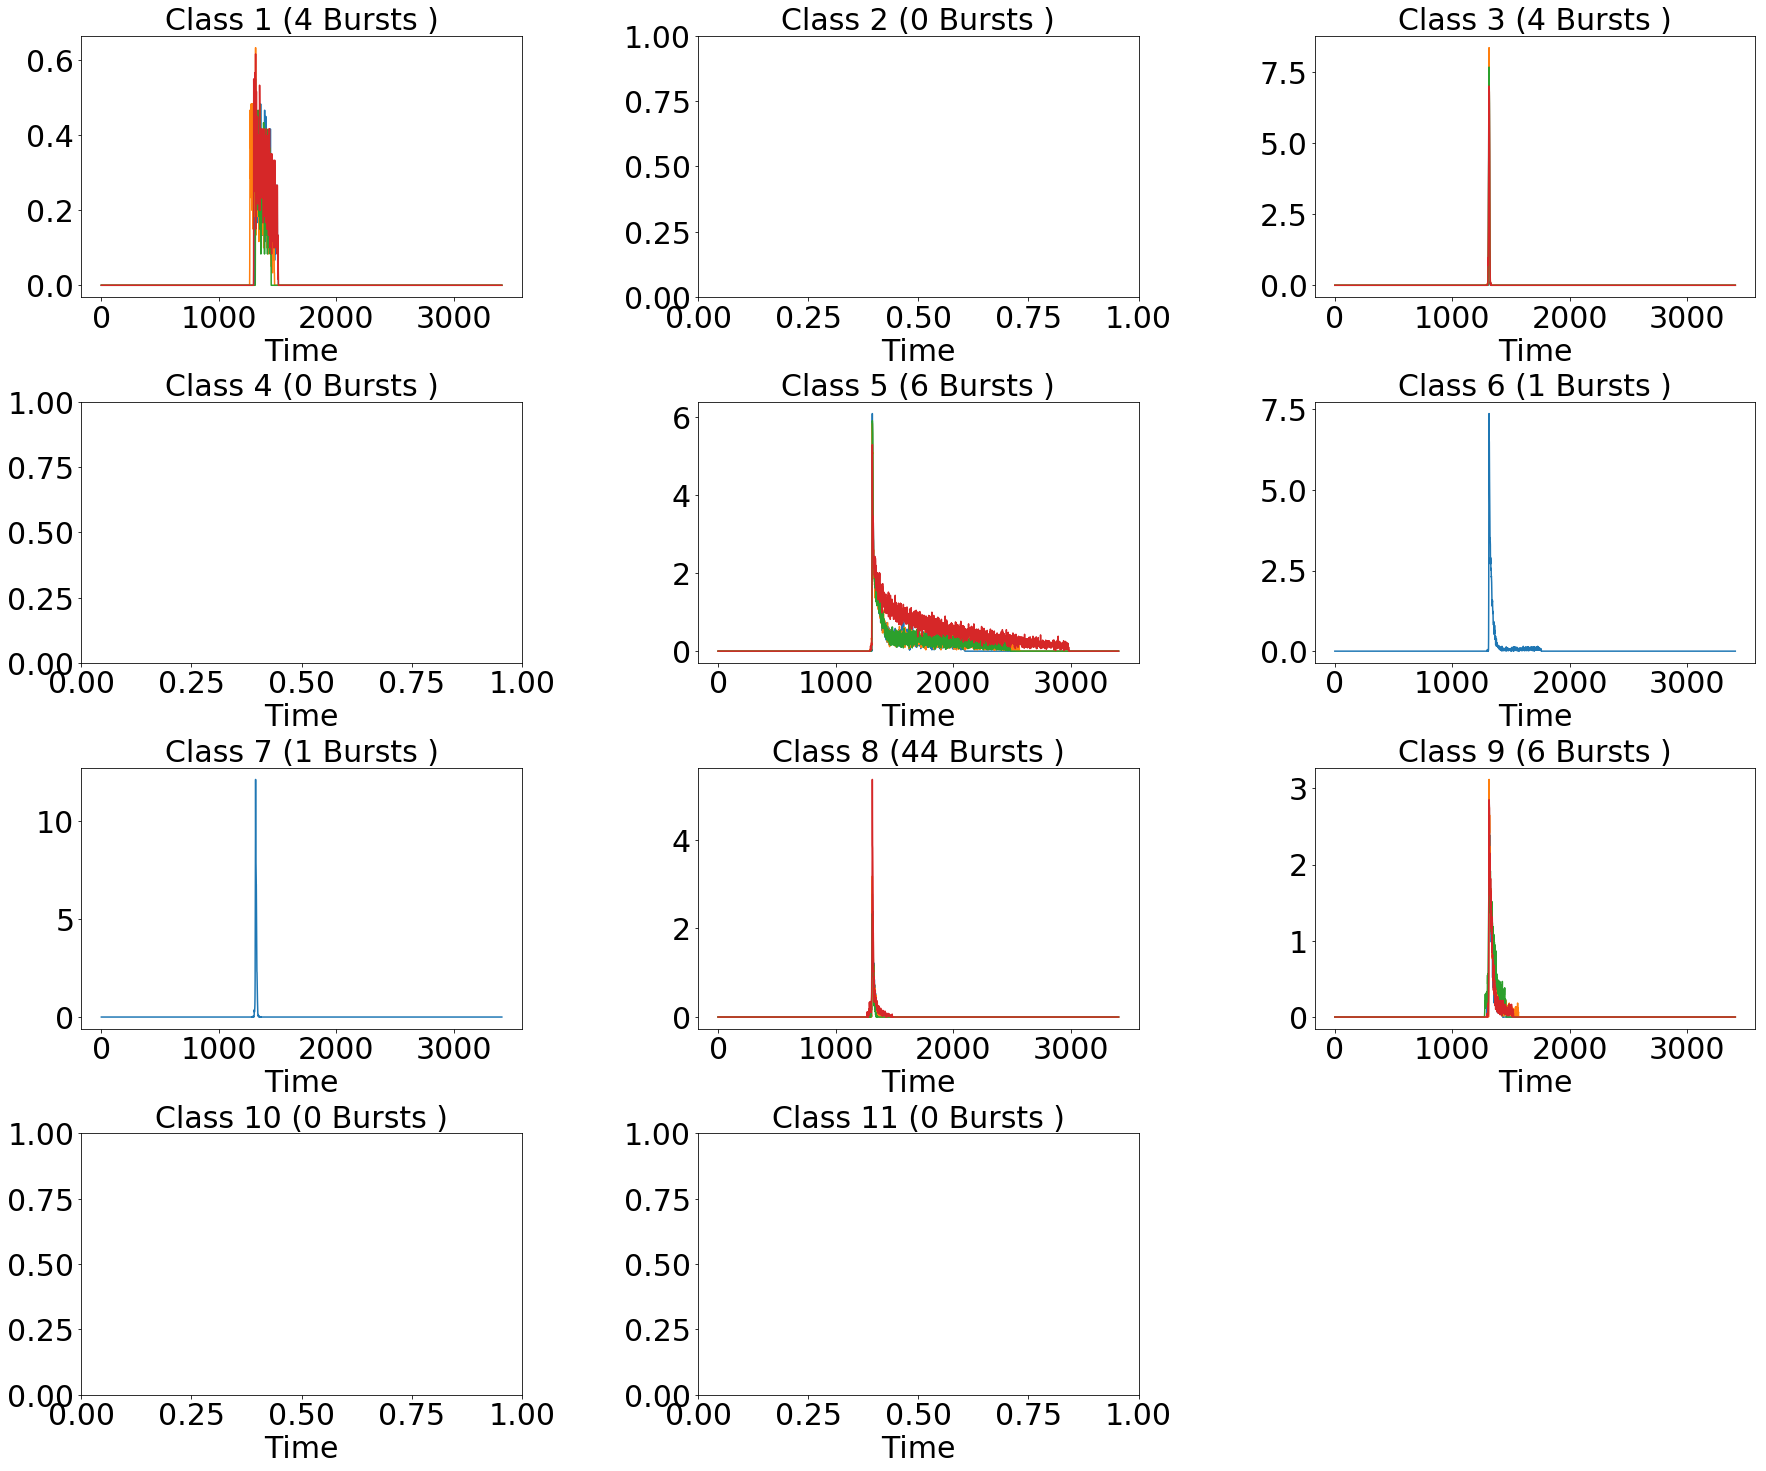

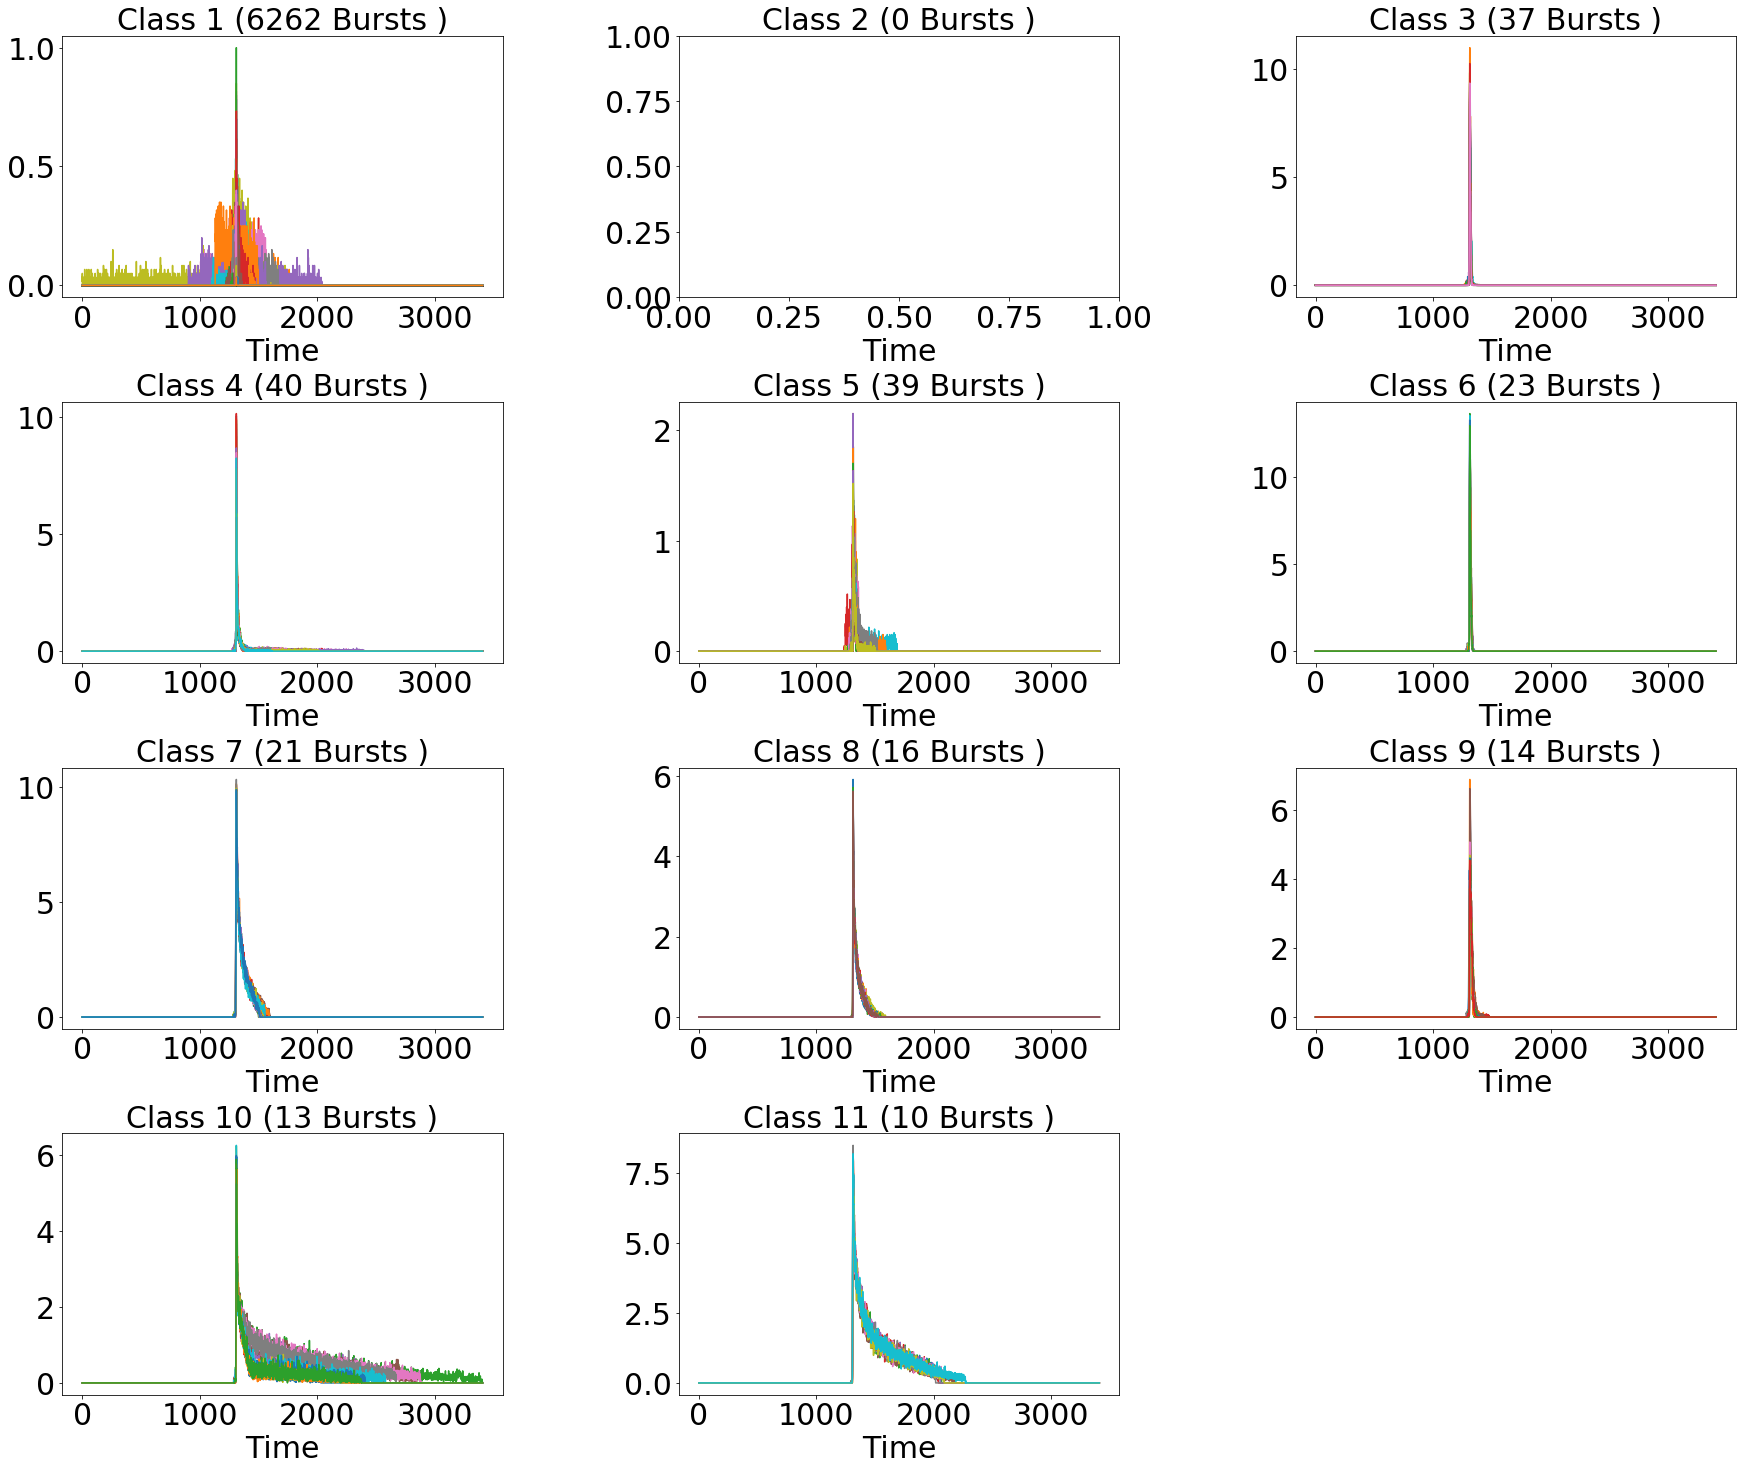

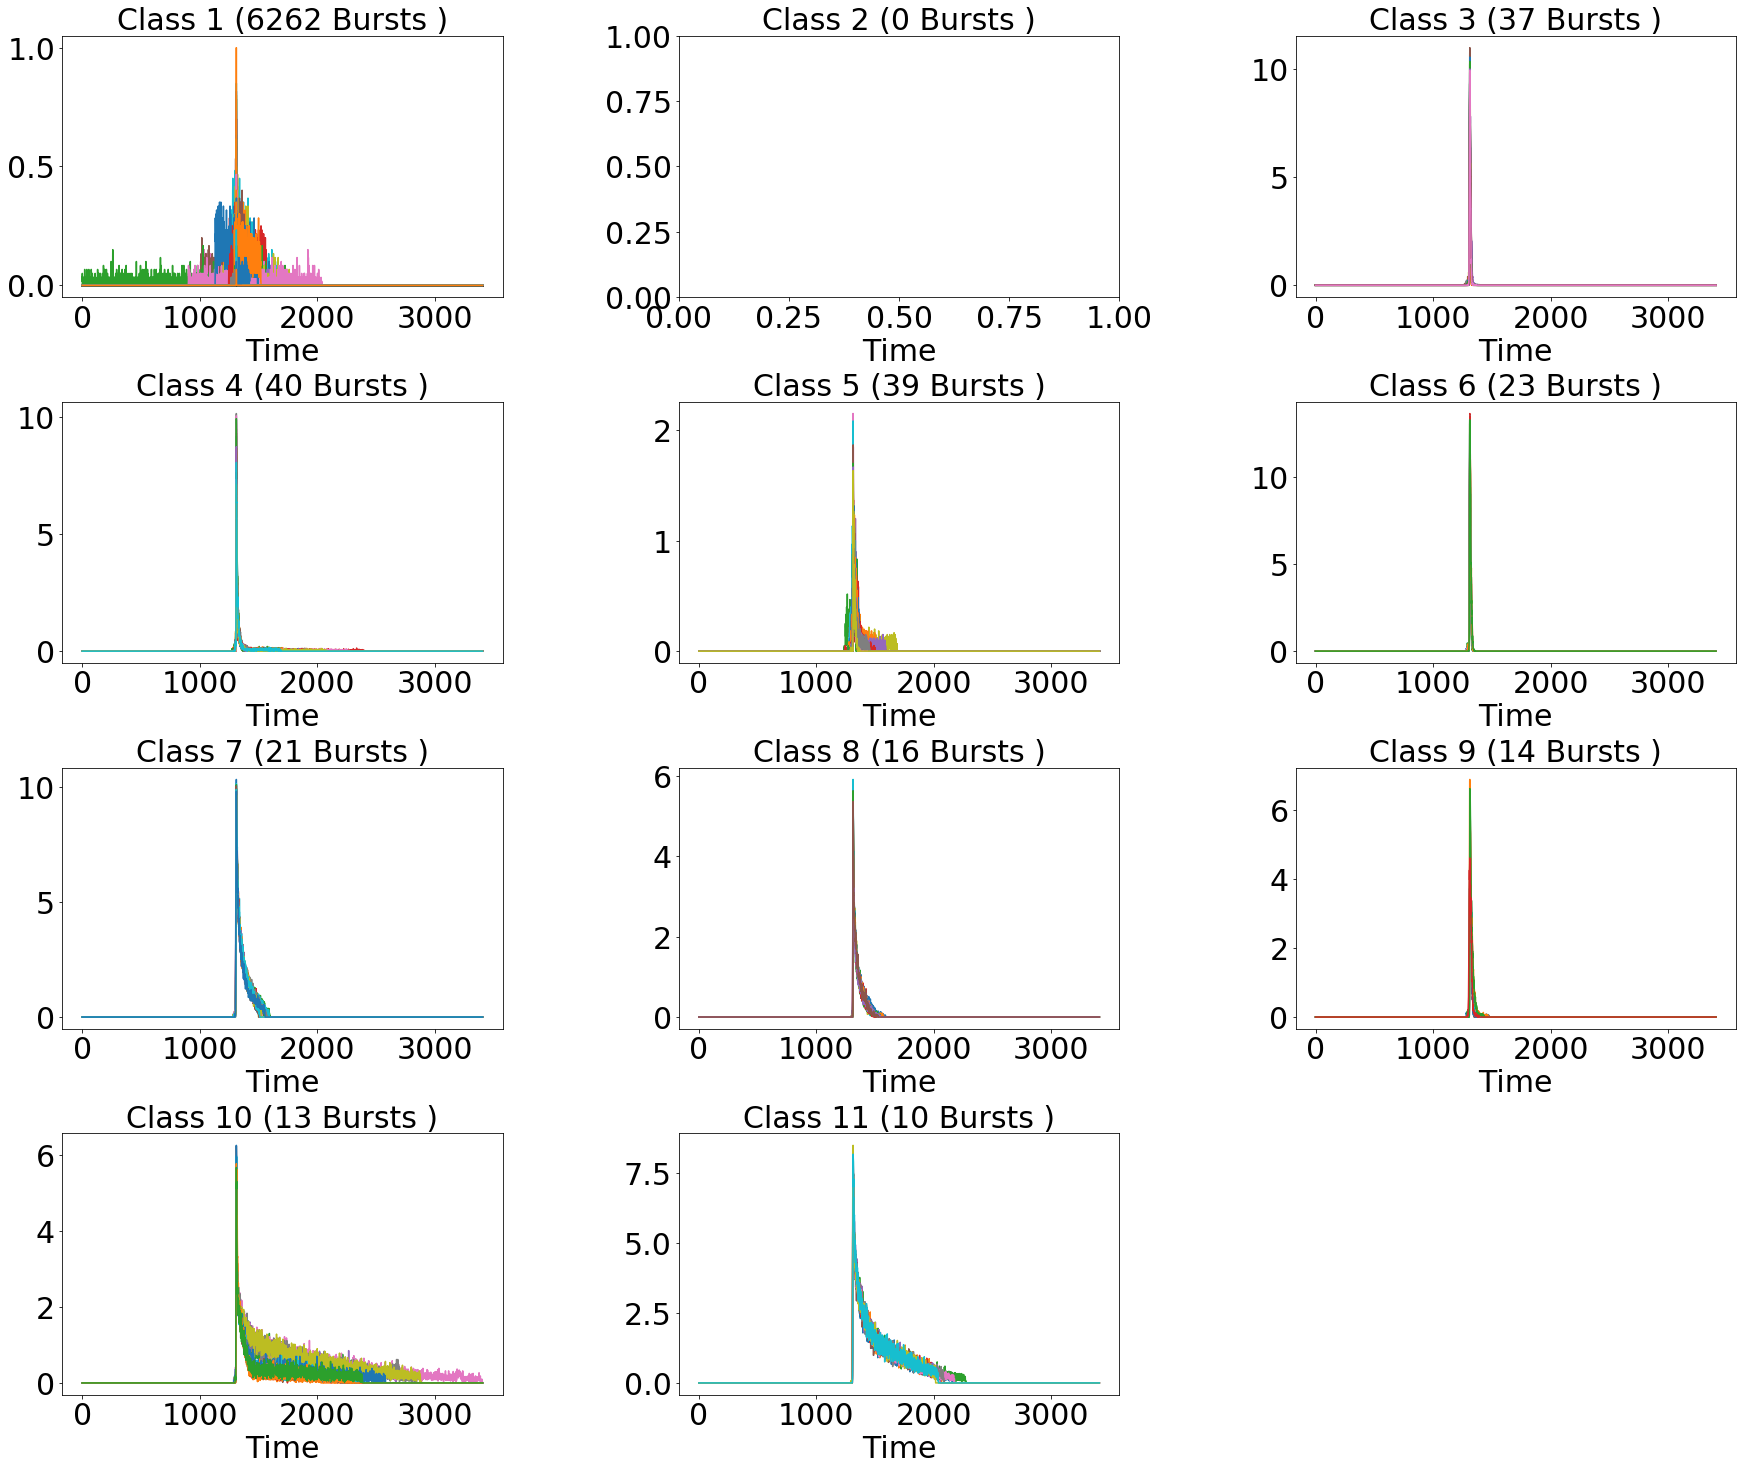

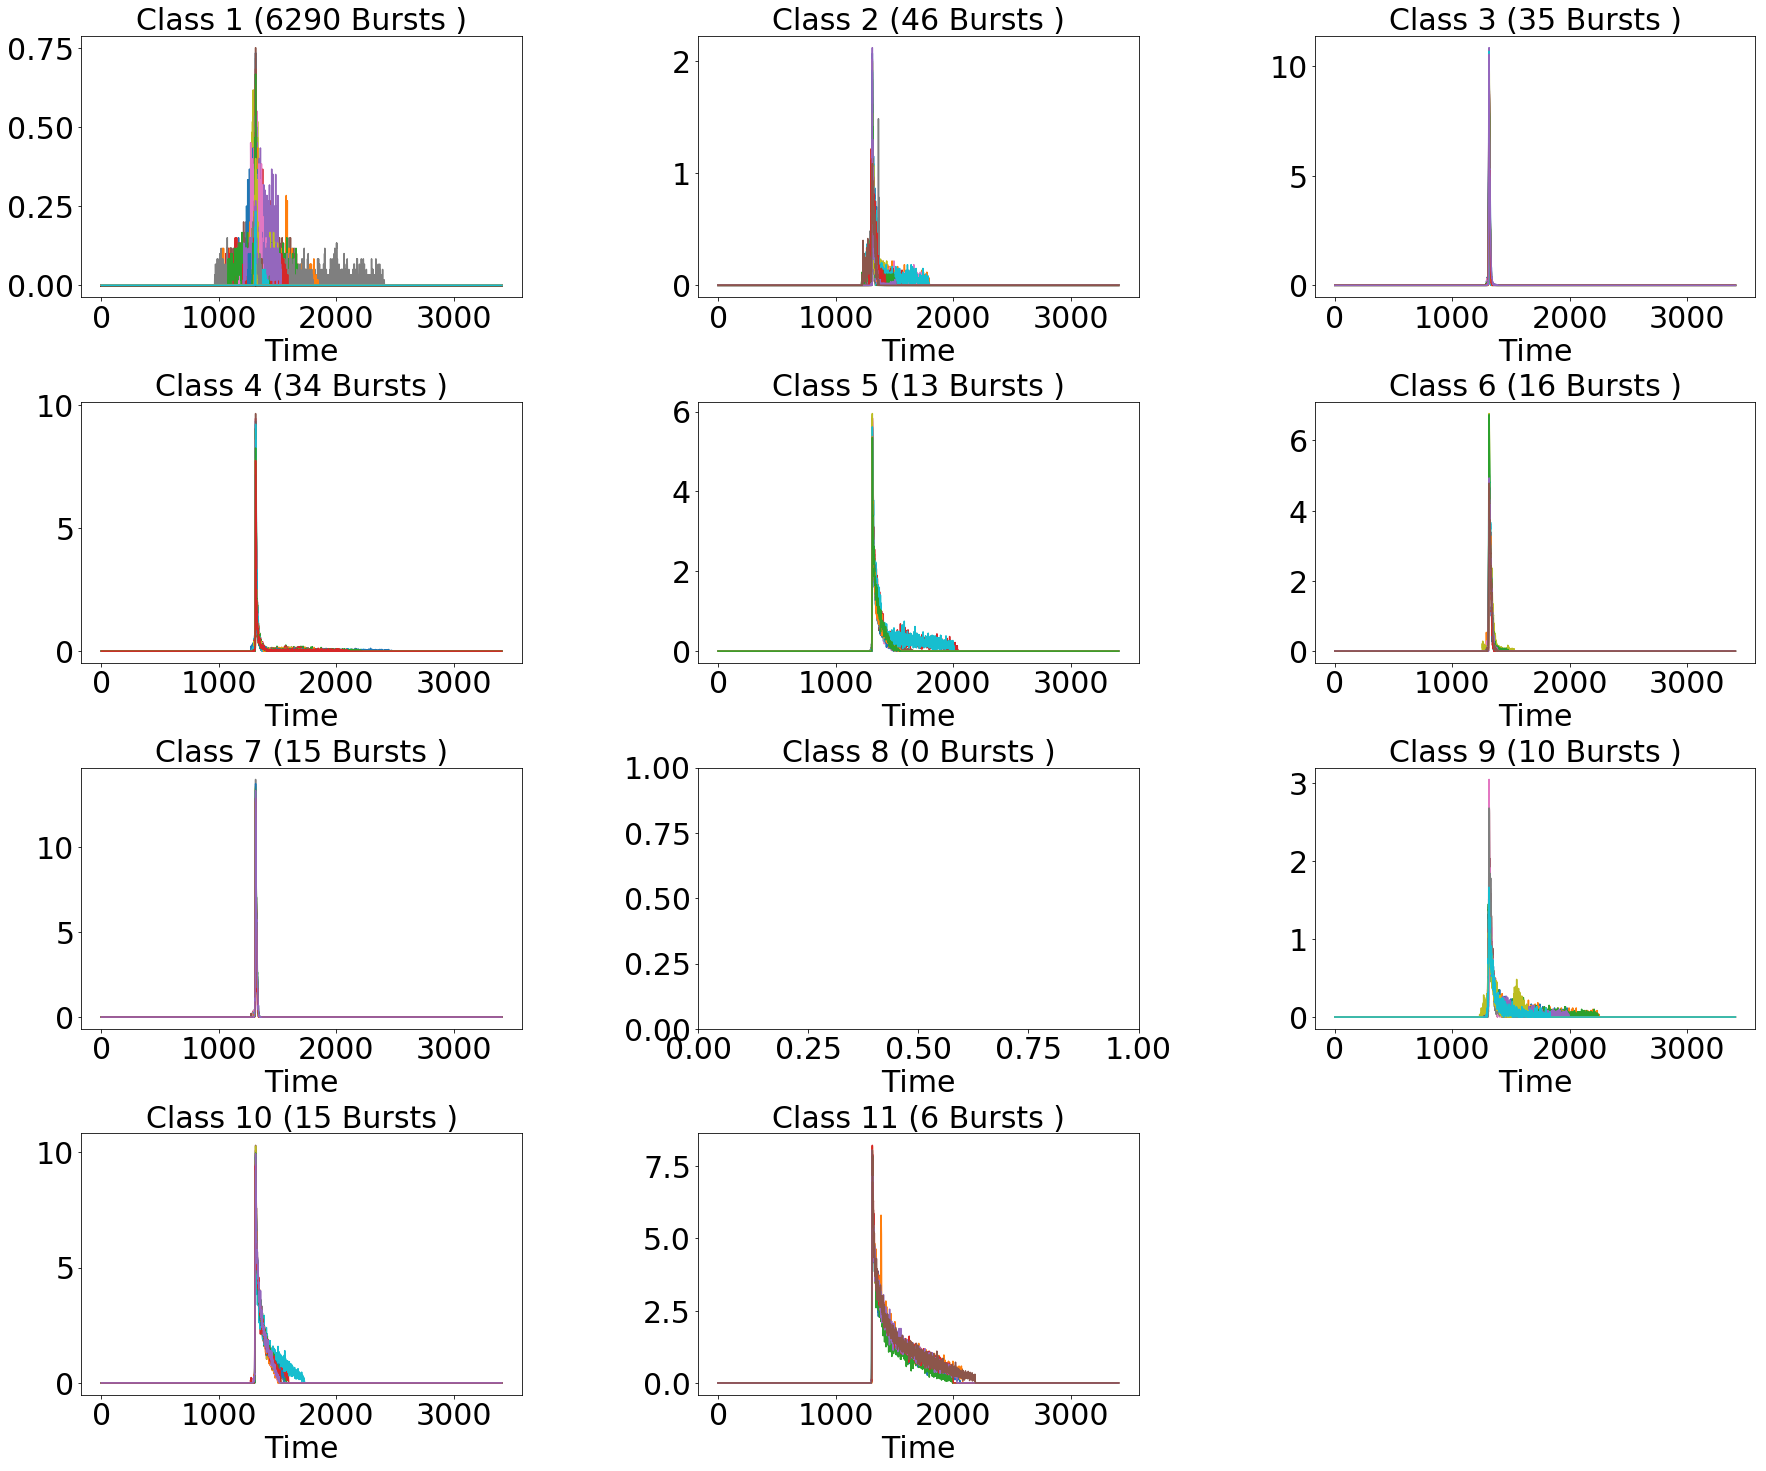

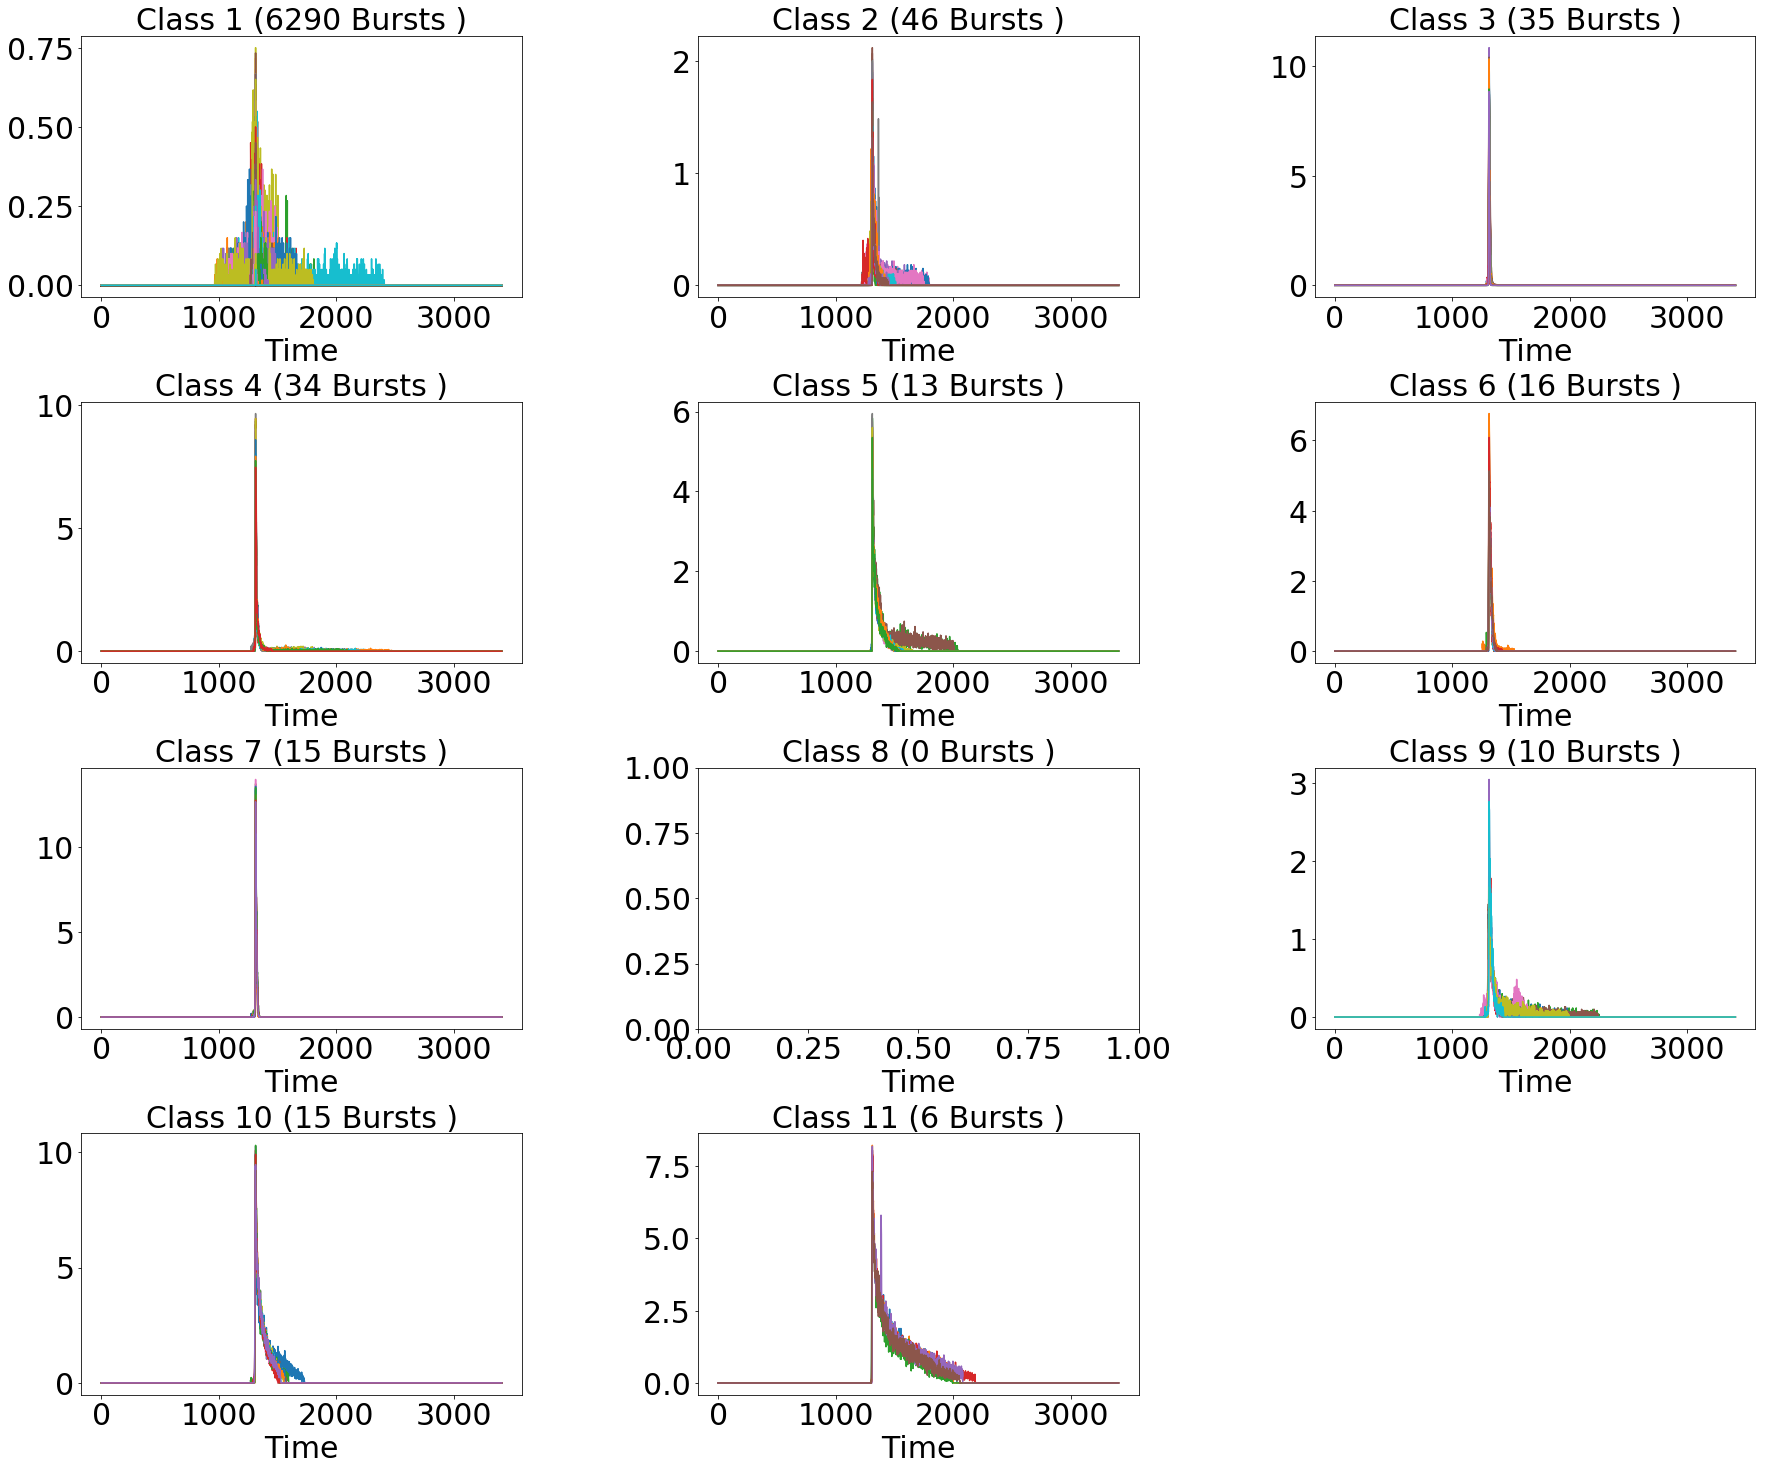

In [51]:
k_clusters=[11,11]
valid_folds_i = high_ps_valid_folds_after_denoising_per_iteration[0]
train_folds_i = []
train_fold_labels_i = train_fold_labels_per_iteration[0]
valid_fold_labels_i = valid_fold_labels_per_iteration[0]
predictions_strengths_cv_per_sample_i = predictions_strengths_cv_per_sample_and_iteration[0]

for f in range(n_folds):
    #print(valid_folds_i[:f].shape,valid_folds_i[(f+1):].shape)
    high_ps_bursts_train_i = np.concatenate((valid_folds_i[:f],valid_folds_i[(f+1):]), axis = 0)[0]
    train_folds_i.append(np.asarray(high_ps_bursts_train_i))

k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds_i, valid_folds_i, train_fold_labels_i, valid_fold_labels_i,predictions_strengths_cv_per_sample_i,threshold = threshold)
    
n_low_ps_bursts_per_fold = [np.sum(k_low_individual_ps_cv_sizes[k_clusters[i]][i]) for i in range(n_folds)] # get low burst examples for each fold after clustering with k_clusters   
        
k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds_i,valid_fold_labels_i,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
    
    
# print low and high individual bursts per fold 
for f in range(n_folds):
    for k_clusters_fold in k_clusters:
    #k_clusters_fold = k_clusters[f]
        plot_cluster_examples(data[k_low_ps_bursts_folds[k_clusters_fold][f]],low_ps_bursts_fold_labels[f][k_clusters_fold-1], k_clusters_fold) # print bursts with low individual prediction strength 
        
for f in range(n_folds):
    for k_clusters_fold in k_clusters:
    #k_clusters_fold = k_clusters[f]
        plot_cluster_examples(data[k_high_ps_bursts_folds[k_clusters_fold][f]],high_ps_bursts_fold_labels[f][k_clusters_fold-1], k_clusters_fold) # print bursts with high individual prediction strength 

In [ ]:
threshold = 0.5
n_folds = 2

for i, k_clusters in enumerate(k_clusters_per_fold_and_iteraton[1:]):
    #print(i, k_clusters)
    valid_folds_i = high_ps_valid_folds_after_denoising_per_iteration[i]
    #print(len(valid_folds_i))
    train_folds_i = []
    train_fold_labels_i = train_fold_labels_per_iteration[i]
    valid_fold_labels_i = valid_fold_labels_per_iteration[i]
    predictions_strengths_cv_per_sample_i = predictions_strengths_cv_per_sample_and_iteration[i]
         
    for f in range(n_folds):
        #print(valid_folds_i[:f].shape,valid_folds_i[(f+1):].shape)
        high_ps_bursts_train_i = np.concatenate((valid_folds_i[:f],valid_folds_i[(f+1):]), axis = 0)[0]
        train_folds_i.append(np.asarray(high_ps_bursts_train_i))
    
    
    k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds_i, valid_folds_i, train_fold_labels_i, valid_fold_labels_i,predictions_strengths_cv_per_sample_i,threshold = threshold)
    
    n_low_ps_bursts_per_fold = [np.sum(k_low_individual_ps_cv_sizes[k_clusters[i]][i]) for i in range(n_folds)] # get low burst examples for each fold after clustering with k_clusters   
        
    k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds_i,valid_fold_labels_i,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
    
    
    # print low and high individual bursts per fold 
    for f in range(n_folds):
        k_clusters_fold = k_clusters[f]
        plot_cluster_examples(data[k_low_ps_bursts_folds[k_clusters_fold][f]],low_ps_bursts_fold_labels[f][k_clusters_fold-1], k_clusters_fold) # print bursts with low individual prediction strength 
        
    for f in range(n_folds):
        k_clusters_fold = k_clusters[f]
        plot_cluster_examples(data[k_high_ps_bursts_folds[k_clusters_fold][f]],high_ps_bursts_fold_labels[f][k_clusters_fold-1], k_clusters_fold) # print bursts with high individual prediction strength 

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

In [58]:
len(predictions_strengths_cv_per_sample_and_iteration[1])
len(predictions_strengths_cv_per_sample_and_iteration[1][1])

9

# Prediction Strength Distribution

In [100]:
len(predictions_strengths_cv_per_sample[0][19])

20

In [102]:
ps_fold_1_11 = sum(predictions_strengths_cv_per_sample[0][10],[])
ps_fold_2_11 = sum(predictions_strengths_cv_per_sample[1][10],[])

In [122]:
test = list(ps_fold_1_11) + list(ps_fold_2_11)

In [154]:
print(len(np.where(np.asarray(test) < 0.9)[0]))

264


In [123]:
len(test)

13092

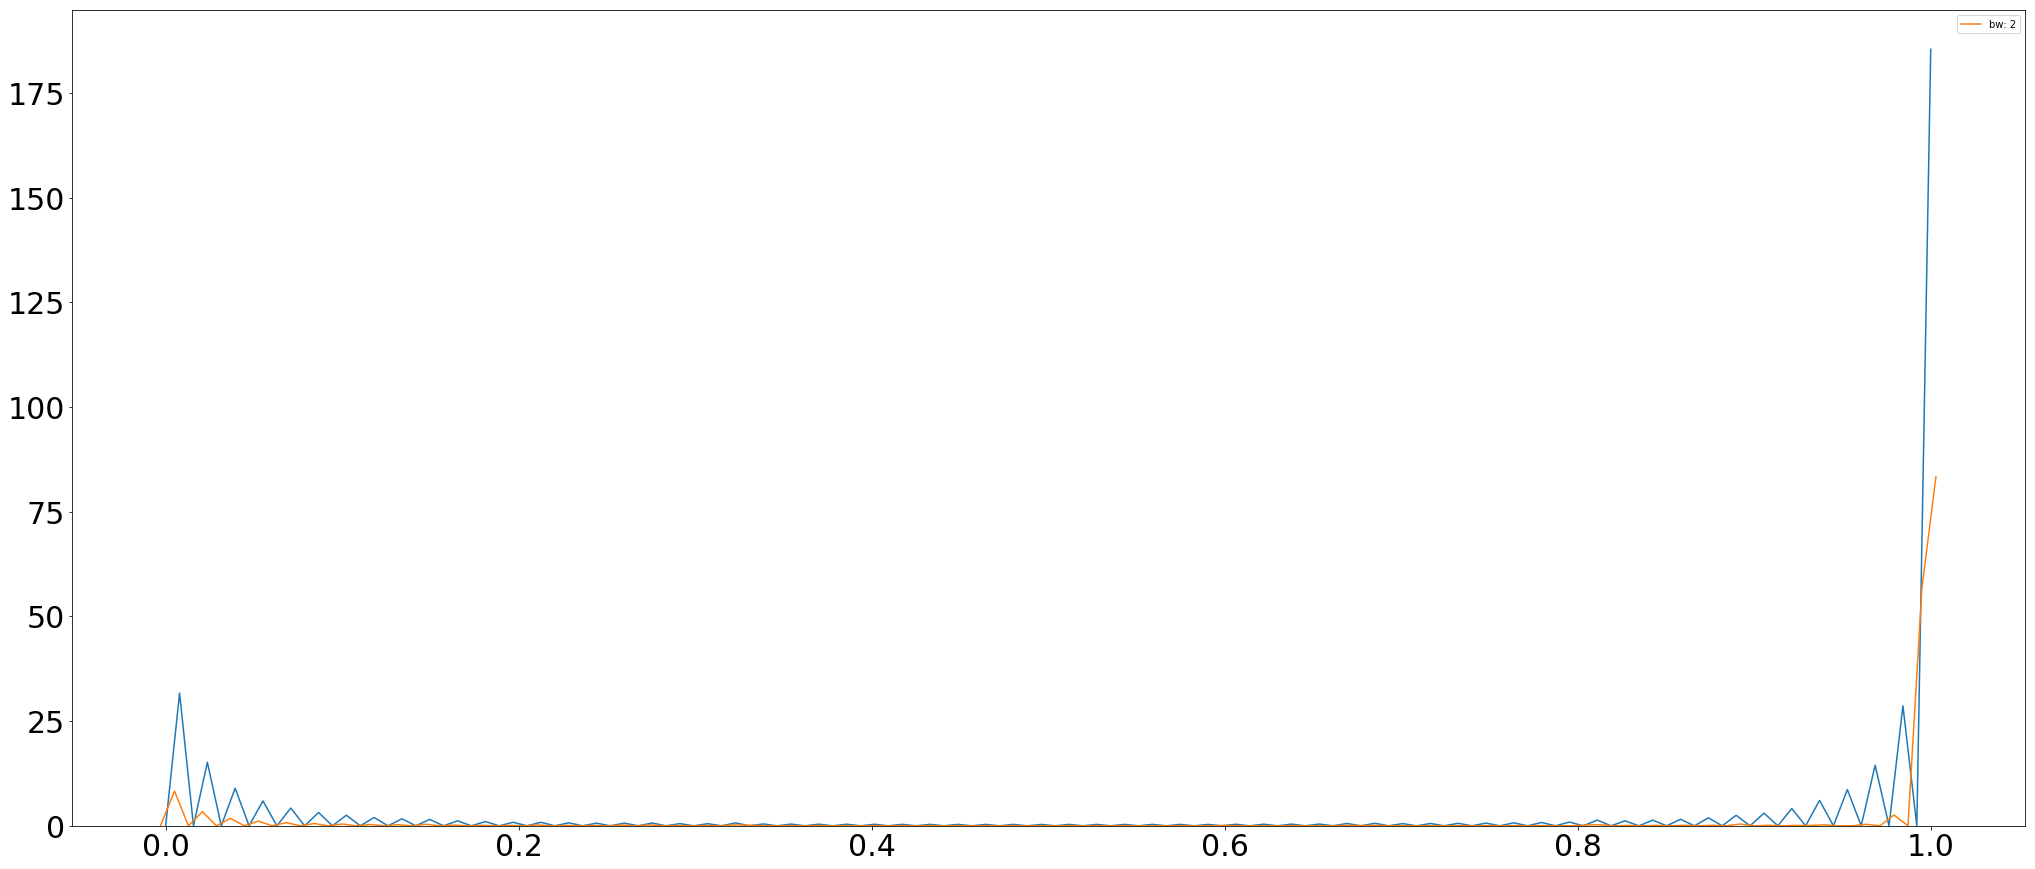

In [145]:
plt.figure(figsize= (35,15))
sns.kdeplot(test)
#sns.kdeplot(test, bw=.2, label="bw: 0.2")
sns.kdeplot(test, bw=0.001, label="bw: 2")
plt.legend()

## Gaussian Mixture Models (GMM)

In [87]:
bics = list(np.load(data_dir + 'culture_balanced/bics.npy',allow_pickle=True))
scores = list(np.load(data_dir + 'culture_balanced/scores.npy',allow_pickle=True))
predictions_valid = list(np.load(data_dir + 'culture_balanced/predictions_valid.npy',allow_pickle=True))
predictions_train = list(np.load(data_dir + 'culture_balanced/predictions_train.npy',allow_pickle=True))
predictions_valid_fitted = list(np.load(data_dir + 'culture_balanced/predictions_valid_fitted.npy',allow_pickle=True))        

In [88]:
n_clusters = 20
n_folds = 1
train_fold_labels_gmm = []
valid_fold_labels_gmm = []

for i in range(n_folds):
    train_fold_labels_gmm.append([])
    valid_fold_labels_gmm.append([])
  
  
for i in range(n_clusters):
    train_fold_labels_gmm[0].append(predictions_train[i])
    valid_fold_labels_gmm[0].append(predictions_valid_fitted[i])

## 50-50 Split data

In [191]:
bics = list(np.load(data_dir + '50_50_split/bics_1.npy',allow_pickle=True)) # contains bic score for training and validation set since 50/50 split one file contains full info about bic 
scores_1 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True)) # scores for training and validation set 
scores_2 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True))

predictions_valid_1 = list(np.load(data_dir + '50_50_split/predictions_valid_1.npy',allow_pickle=True)) # predictions of validation set 
predictions_valid_2 = list(np.load(data_dir + '50_50_split/predictions_valid_2.npy',allow_pickle=True))

predictions_train_1 = list(np.load(data_dir + '50_50_split/predictions_train_1.npy',allow_pickle=True)) # predictions of training set 
predictions_train_2 = list(np.load(data_dir + '50_50_split/predictions_train_2.npy',allow_pickle=True)) 

predictions_valid_fitted_1 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_1.npy',allow_pickle=True)) # predictions of validation set after fitting gmm on it
predictions_valid_fitted_2 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_2.npy',allow_pickle=True)) 

In [192]:
n_clusters = 20
n_folds = 2


train_fold_labels_gmm = np.stack((predictions_train_1,predictions_train_2),axis = 0)
valid_fold_labels_gmm = np.stack((predictions_valid_fitted_1,predictions_valid_fitted_2), axis = 0)

In [193]:
predictions_strengths_cv_gmm_per_sample = list(np.load(data_dir + '50_50_split/prediction_strength_gmm_per_sample.npy',allow_pickle=True))
predictions_strengths_cv_gmm = list(np.load(data_dir + '50_50_split/prediction_strength_gmm.npy',allow_pickle=True))
valid_fold_labels_predicted_gmm = list(np.load(data_dir + '50_50_split/valid_fold_labels_predicted_gmm.npy',allow_pickle=True))

In [194]:
from ipynb.fs.defs.prediction_strength import calculate_prediction_strength_per_k
k_predictions_strength_cv_gmm, k_valid_fold_labels_predicted_gmm, k_valid_fold_labels_gmm, valid_cluster_size_gmm, valid_cluster_size_predicted_gmm = calculate_prediction_strength_per_k(predictions_strengths_cv_gmm,valid_fold_labels_gmm,valid_fold_labels_predicted_gmm, strength_sorted = True)

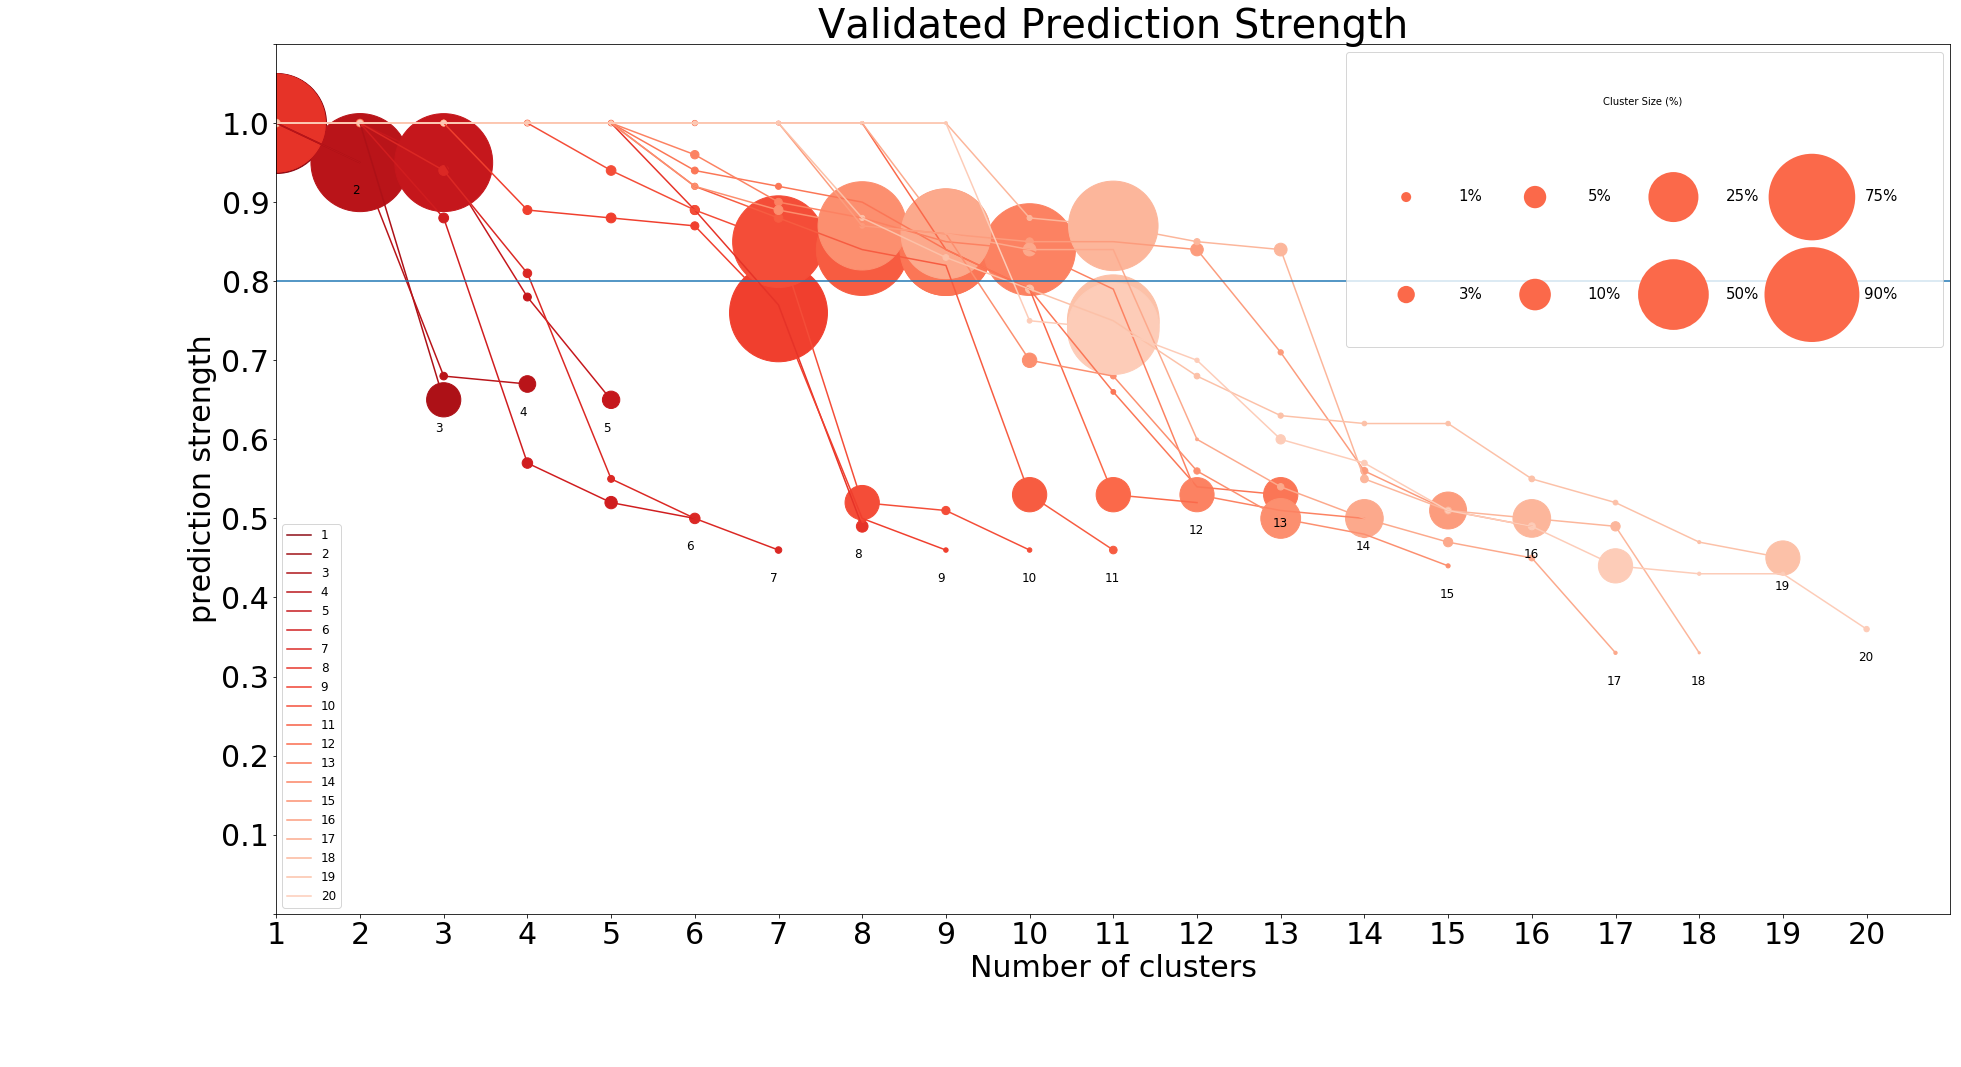

In [195]:
from ipynb.fs.defs.prediction_strength import plot_prediction_strength
plot_prediction_strength(k_predictions_strength_cv_gmm,valid_cluster_size_gmm,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 1)

In [80]:
from sklearn.mixture import GaussianMixture as GMM

In [90]:
init_k_clusters = 8
counter = 0
threshold = 0.8
n_bad_clusters_per_fold = [1]
n_folds = 1
n_init=100
max_iter=100
sub_dir = '/culture_balanced/denoising/gmm/k_init=8/'

In [91]:
k_clusters = np.repeat(init_k_clusters,n_folds)
while np.sum(n_bad_clusters_per_fold) > 0 or counter == 0:
    if counter == 0:
        valid_folds_without_bad_clusters, valid_fold_labels_without_bad_clusters, train_fold_labels_without_bad_clusters, n_bad_clusters_per_fold = discard_bad_cluster_bursts(k_predictions_strength_cv_gmm, valid_folds, valid_fold_labels_gmm, train_fold_labels_gmm, k_clusters, threshold = threshold)
        prev_k_clusters = k_clusters
        k_clusters = prev_k_clusters - n_bad_clusters_per_fold

    else:
        valid_folds_without_bad_clusters, valid_fold_labels_without_bad_clusters, train_fold_labels_without_bad_clusters, n_bad_clusters_per_fold = discard_bad_cluster_bursts(k_predictions_strength_cv_without_bad_clusters, valid_folds_without_bad_clusters, valid_fold_labels_without_bad_clusters, train_fold_labels_without_bad_clusters,k_clusters, threshold = threshold)
        prev_k_clusters = k_clusters
        k_clusters = prev_k_clusters - n_bad_clusters_per_fold

    print("[%d] Clusters found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_bad_clusters_per_fold) + [threshold])))
    print("Look at [%d] Clusters in each fold!" % tuple(list(k_clusters)))

    print("Save denoised validation folds!")
    np.save(data_dir + sub_dir + 'valid_folds_denoised_%d' % counter, valid_folds_without_bad_clusters)
    np.save(data_dir + sub_dir + 'n_bad_clusters_per_fold_%d' % counter ,n_bad_clusters_per_fold)

    clusters = list(range(1,np.amax(k_clusters) + 1))
    
    train_fold_labels_without_bad_clusters = []
    valid_fold_labels_without_bad_clusters = []
    
    for i in range(n_folds):
        predictions_valid = []
        
        for c in clusters:
            print("Fitting GMM with %d clusters:" % c)
            gmm_valid = GMM(c, n_init=n_init, max_iter=max_iter).fit(dataset_cutted2[valid_folds_without_bad_clusters[i]]) 
            
            print("Predict Validation Dataset!")
            predictions_valid.append(gmm_valid.predict(dataset_cutted2[valid_folds_without_bad_clusters[i]]))
            
        train_fold_labels_without_bad_clusters.append(train_fold_labels_gmm[i][:len(clusters)])
        valid_fold_labels_without_bad_clusters.append(predictions_valid)
    
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'train_fold_labels_denoised_%d' % counter,train_fold_labels_without_bad_clusters)
    np.save(data_dir + sub_dir + 'valid_fold_labels_denoised_%d' % counter ,valid_fold_labels_without_bad_clusters)

    print("Calculate Prediction Strength for each fold! ")
    predictions_strengths_without_bad_clusters, valid_fold_labels_without_bad_clusters_predicted = cross_valdation_prediction_strength(dataset_cutted2, train_folds, valid_folds_without_bad_clusters, train_fold_labels_without_bad_clusters, valid_fold_labels_without_bad_clusters)
    print("Done!")

    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_without_bad_clusters_%d' % counter , predictions_strengths_without_bad_clusters)
    np.save(data_dir + sub_dir + 'valid_fold_labels_without_bad_clusters_%d_predicted' % counter, valid_fold_labels_without_bad_clusters_predicted)

    k_predictions_strength_cv_without_bad_clusters, k_valid_fold_labels_predicted_without_bad_clusters, k_valid_fold_labels_without_bad_clusters, valid_cluster_size_without_bad_clusters, valid_cluster_size_predicted_without_bad_clusters = calculate_prediction_strength_per_k(predictions_strengths_without_bad_clusters,valid_fold_labels_without_bad_clusters,valid_fold_labels_without_bad_clusters_predicted, strength_sorted = True)
    
    np.save(data_dir + sub_dir + 'k_clusters_%d' % counter, k_clusters)
    
    counter += 1

[3] Clusters found in each fold with Prediction Strength below threshold = 0.80!
Look at [5] Clusters in each fold!
Save denoised validation folds!
Fitting GMM with 1 clusters:
Predict Validation Dataset!
Fitting GMM with 2 clusters:
Predict Validation Dataset!
Fitting GMM with 3 clusters:
Predict Validation Dataset!
Fitting GMM with 4 clusters:
Predict Validation Dataset!
Fitting GMM with 5 clusters:
Predict Validation Dataset!
Save labels!
Calculate Prediction Strength for each fold! 
Calculate Predictions Strength for 1. Fold
Done!
Save Prediction Strength!
[1] Clusters found in each fold with Prediction Strength below threshold = 0.80!
Look at [4] Clusters in each fold!
Save denoised validation folds!
Fitting GMM with 1 clusters:
Predict Validation Dataset!
Fitting GMM with 2 clusters:
Predict Validation Dataset!
Fitting GMM with 3 clusters:
Predict Validation Dataset!
Fitting GMM with 4 clusters:
Predict Validation Dataset!
Save labels!
Calculate Prediction Strength for each fold!

In [92]:
print(counter)

4


In [93]:
sub_dir = '/culture_balanced/denoising/gmm/k_init=8/'

In [94]:
counter = 4 #0
threshold = 0.8

valid_folds_without_bad_clusters = list(np.load(data_dir + sub_dir + 'valid_folds_denoised_%d.npy' % (counter - 1),allow_pickle=True))
n_bad_clusters_per_fold = list(np.load(data_dir + sub_dir +'n_bad_clusters_per_fold_%d.npy' % (counter - 1),allow_pickle=True))
train_fold_labels_without_bad_clusters = list(np.load(data_dir + sub_dir +'train_fold_labels_denoised_%d.npy' % (counter - 2),allow_pickle=True))
valid_fold_labels_without_bad_clusters = list(np.load(data_dir + sub_dir +'valid_fold_labels_denoised_%d.npy' % (counter - 2),allow_pickle=True))
predictions_strengths_without_bad_clusters = list(np.load(data_dir + sub_dir + 'predictions_strengths_without_bad_clusters_%d.npy' % (counter - 1),allow_pickle=True))
valid_fold_labels_without_bad_clusters_predicted = list(np.load(data_dir + sub_dir +'valid_fold_labels_without_bad_clusters_%d_predicted.npy' % (counter - 1),allow_pickle=True))

k_predictions_strength_cv_without_bad_clusters, k_valid_fold_labels_predicted_without_bad_clusters, k_valid_fold_labels_without_bad_clusters, valid_cluster_size_without_bad_clusters, valid_cluster_size_predicted_without_bad_clusters = calculate_prediction_strength_per_k(predictions_strengths_without_bad_clusters,valid_fold_labels_without_bad_clusters,valid_fold_labels_without_bad_clusters_predicted, strength_sorted = True)
k_clusters = np.asarray(list(np.load(data_dir + sub_dir +'k_clusters_%d.npy' % (counter - 2),allow_pickle=True)))#np.asarray([5,10,11,10,12]) #np.repeat(init_k_clusters,5)
prev_k_clusters = np.asarray(list(np.load(data_dir + sub_dir +'k_clusters_%d.npy' % (counter - 3),allow_pickle=True)))
print("[%d] Clusters found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_bad_clusters_per_fold) + [threshold])))
print("Look at [%d] Clusters in each fold!" % tuple(list(k_clusters)))

[0] Clusters found in each fold with Prediction Strength below threshold = 0.80!
Look at [3] Clusters in each fold!


In [95]:
for i, fold in  enumerate(valid_folds_without_bad_clusters):
    print("Validation fold %d size reduced from %d bursts to %d bursts. Reduction of %.2f %%!" % (i+1, len(valid_folds[i]), len(fold), np.round((len(valid_folds[i]) - len(fold))/len(valid_folds[i]) ,4) * 100))

Validation fold 1 size reduced from 3282 bursts to 521 bursts. Reduction of 84.13 %!


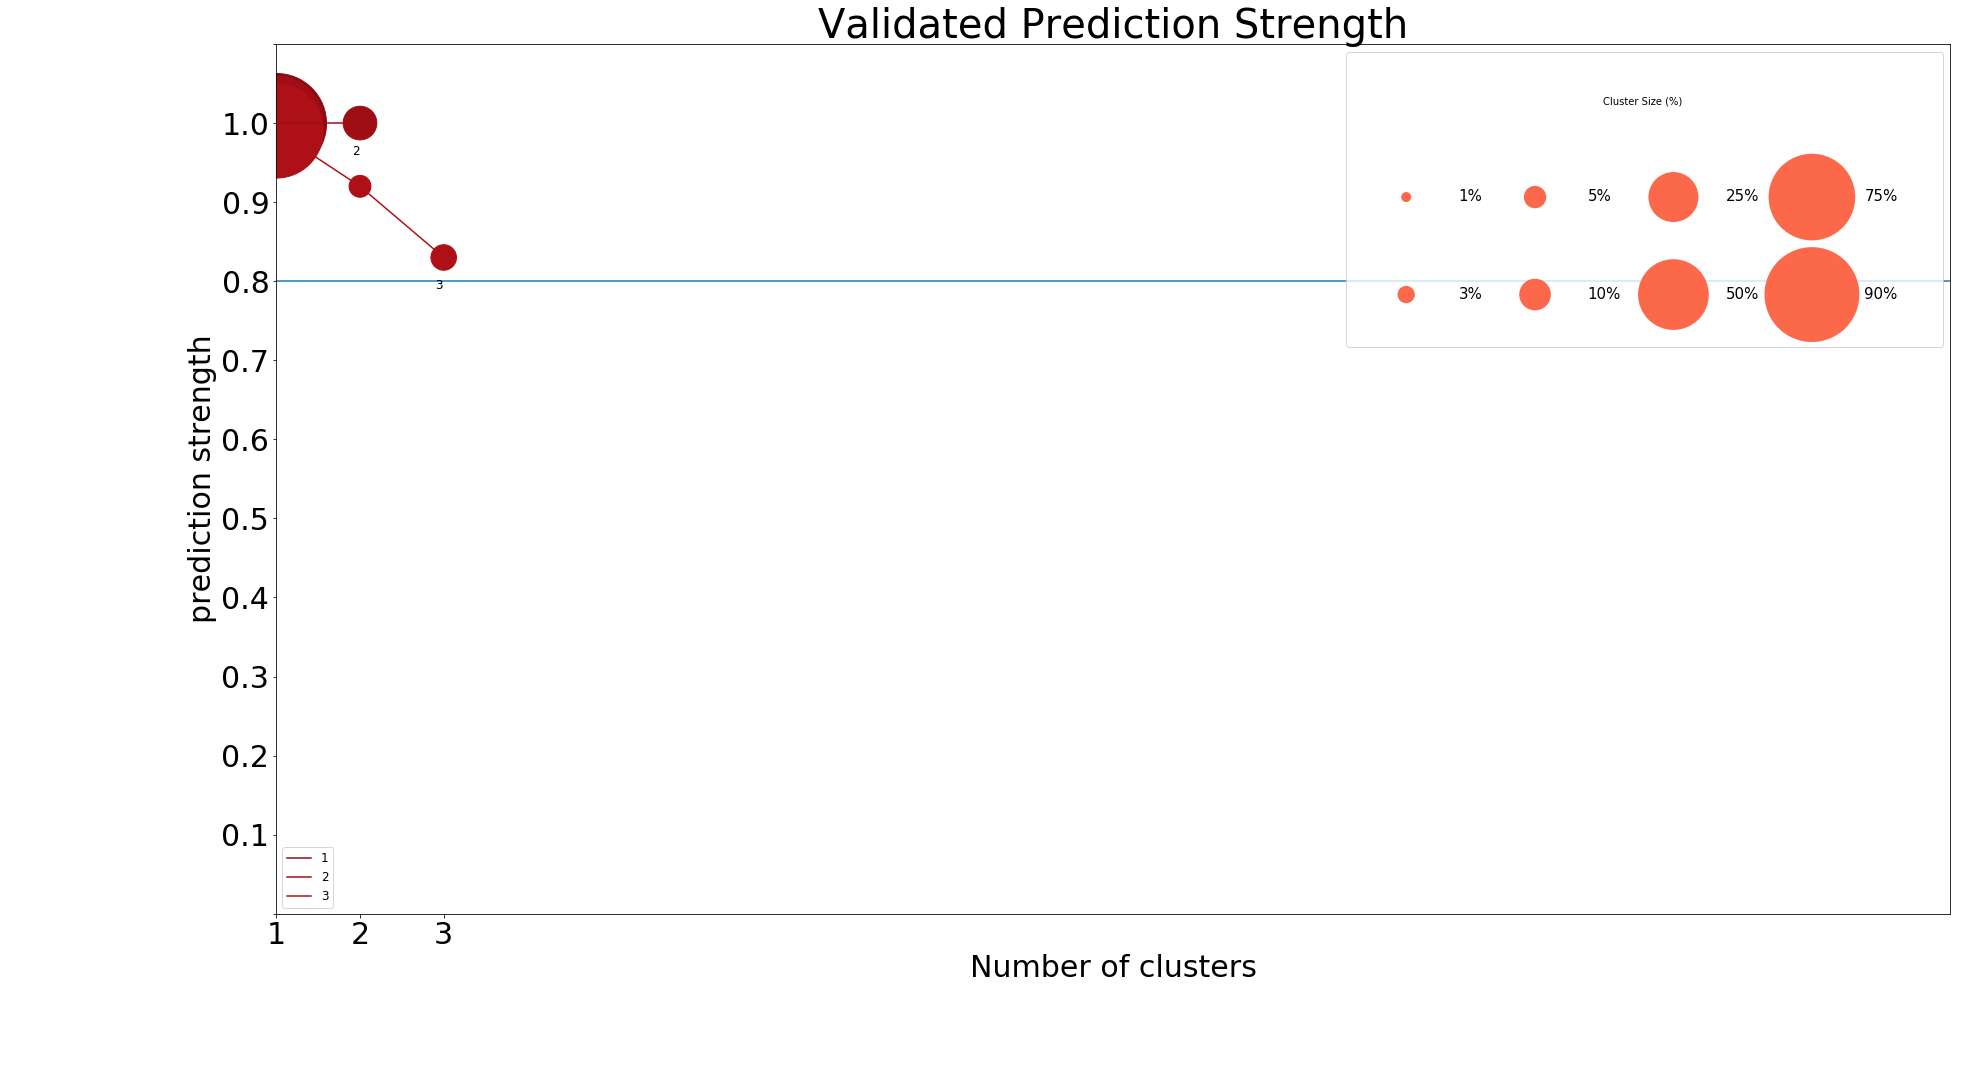

In [96]:
from ipynb.fs.defs.prediction_strength import plot_prediction_strength
plot_prediction_strength(k_predictions_strength_cv_without_bad_clusters,valid_cluster_size_without_bad_clusters,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 1)

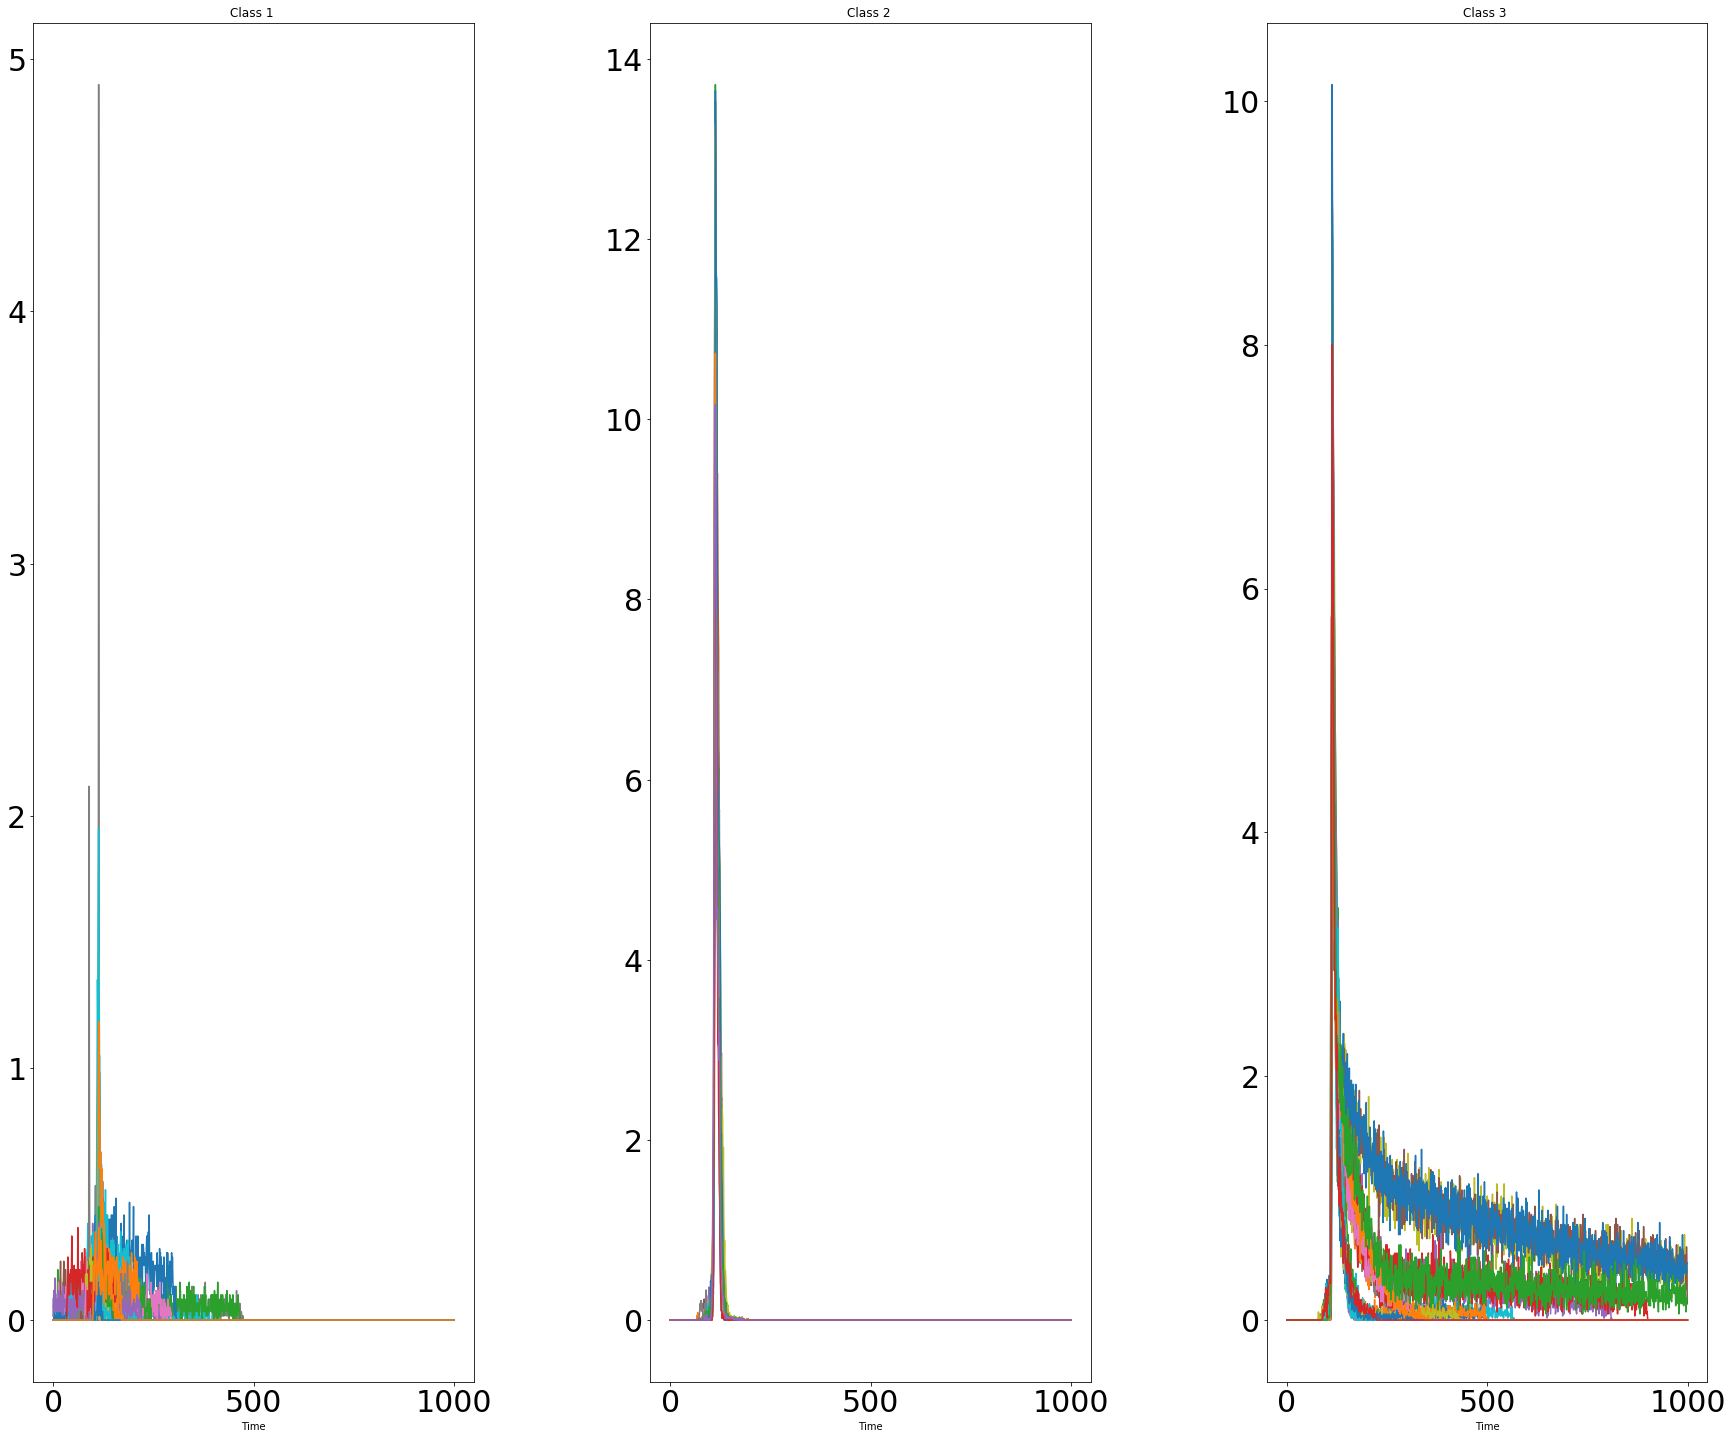

In [97]:
from ipynb.fs.defs.prediction_strength import plot_cluster_examples
k_clusters = 3
plot_cluster_examples(dataset_cutted2[valid_folds_without_bad_clusters[0]], valid_fold_labels_without_bad_clusters[0][k_clusters-1], k_clusters)

In [98]:
n_bad_clusters_per_fold_and_iteration = []
valid_folds_denoised_per_iteration = []

for file in np.sort(os.listdir(data_dir + sub_dir)):
    if file.startswith("n_bad_clusters_per_fold_"):
        print(file)
        n_bad_clusters_per_fold_and_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))
    if file.startswith("valid_folds_denoised_"):
        print(file)
        valid_folds_denoised_per_iteration.append(list(np.load(data_dir + sub_dir + file ,allow_pickle=True)))

n_bad_clusters_per_fold_and_iteration.append([0])

n_bad_clusters_per_fold_0.npy
n_bad_clusters_per_fold_1.npy
n_bad_clusters_per_fold_2.npy
n_bad_clusters_per_fold_3.npy
valid_folds_denoised_0.npy
valid_folds_denoised_1.npy
valid_folds_denoised_2.npy
valid_folds_denoised_3.npy


In [99]:
n_bad_clusters_per_fold_and_iteration

[[3], [1], [1], [0], [0]]

In [100]:
init_clusters = np.asarray([8])
k_clusters_per_iteration = [init_clusters]
reduction_in_percent_per_iteration = [[0]]

for i, n_bad_clusters in enumerate(n_bad_clusters_per_fold_and_iteration[:-1]):
    print("Iteration %d " % (i+1))
    print("Removed [%d] Clusters per fold " % tuple(list(n_bad_clusters)))
    init_clusters = init_clusters - n_bad_clusters
    k_clusters_per_iteration += [init_clusters]
    print("Recalculated Spectral clustering with [%d]"  % tuple(list(init_clusters)))
    reduction_in_percent_i = []

    for j, fold in  enumerate(valid_folds_denoised_per_iteration[i]):
        reduction_percent = np.round((len(valid_folds[j]) - len(fold))/len(valid_folds[j]) ,4) * 100
        reduction_in_percent_i.append(reduction_percent)
        print("Validation fold %d size reduced from %d bursts to %d bursts. Reduction of %.2f %%!" % (j+1, len(valid_folds[j]), len(fold), reduction_percent))

    print([len(fold) for fold in valid_folds_denoised_per_iteration[i]])    
    reduction_in_percent_per_iteration.append(reduction_in_percent_i)

Iteration 1 
Removed [3] Clusters per fold 
Recalculated Spectral clustering with [5]
Validation fold 1 size reduced from 3282 bursts to 3218 bursts. Reduction of 1.95 %!
[3218]
Iteration 2 
Removed [1] Clusters per fold 
Recalculated Spectral clustering with [4]
Validation fold 1 size reduced from 3282 bursts to 3208 bursts. Reduction of 2.25 %!
[3208]
Iteration 3 
Removed [1] Clusters per fold 
Recalculated Spectral clustering with [3]
Validation fold 1 size reduced from 3282 bursts to 521 bursts. Reduction of 84.13 %!
[521]
Iteration 4 
Removed [0] Clusters per fold 
Recalculated Spectral clustering with [3]
Validation fold 1 size reduced from 3282 bursts to 521 bursts. Reduction of 84.13 %!
[521]


Text(0.5,0,'Iteration')

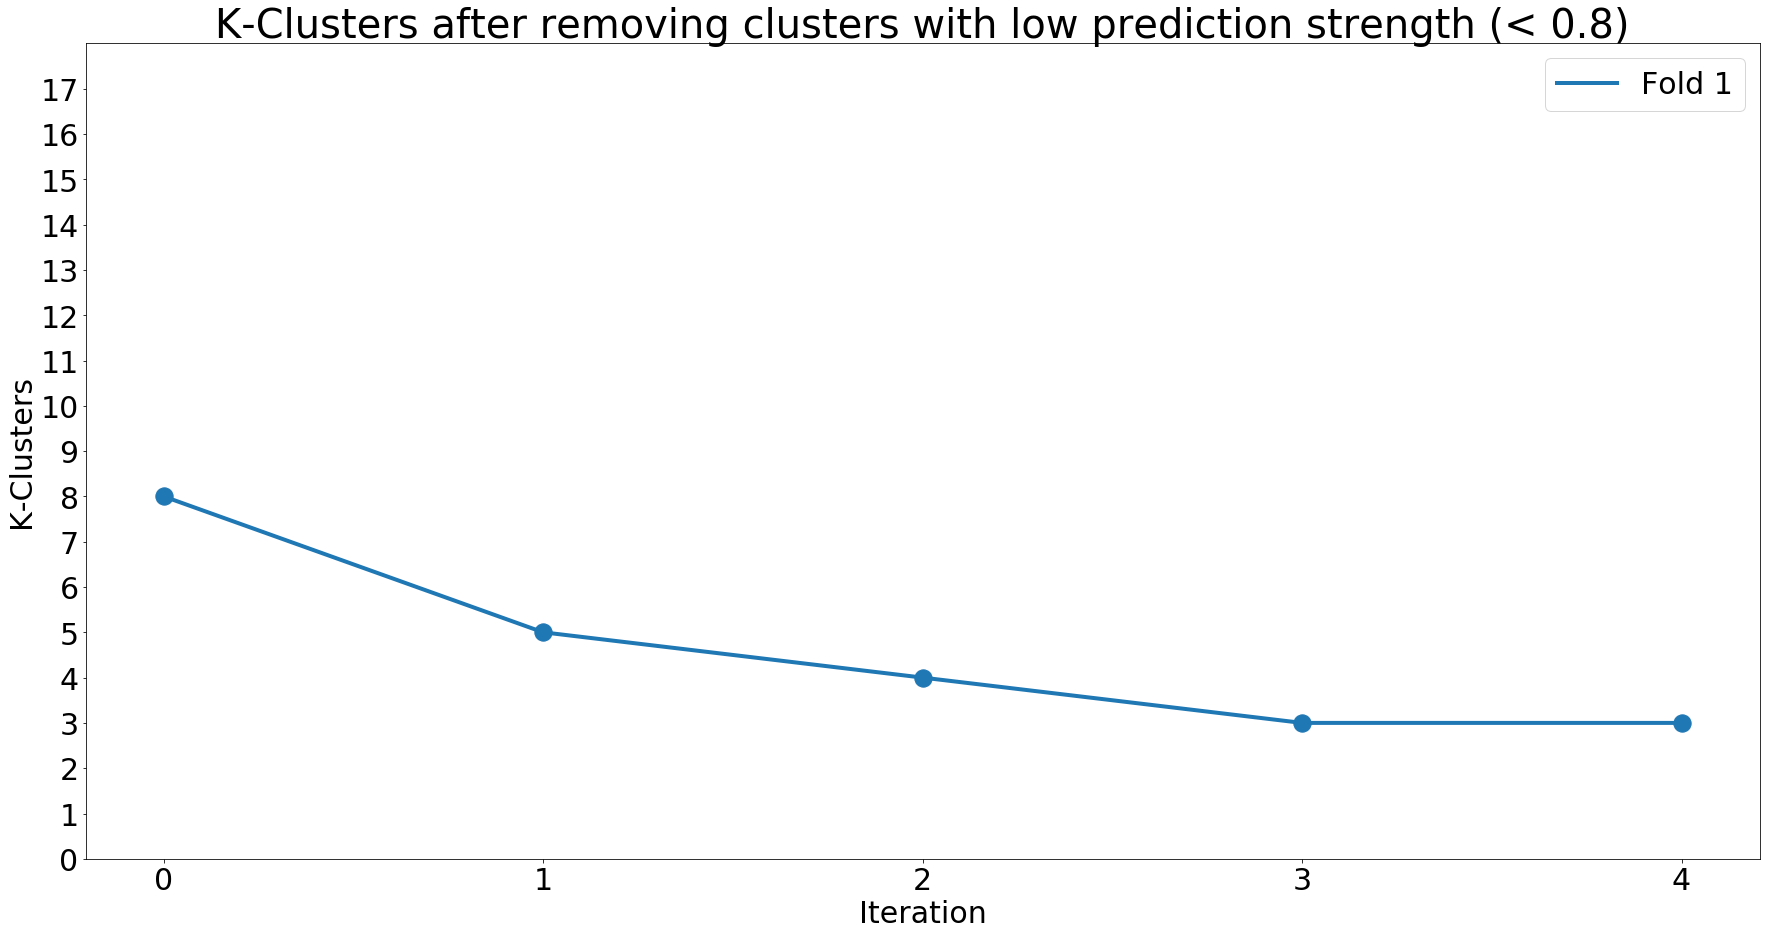

In [101]:
fig, ax = plt.subplots(figsize=(30,15))
color = ["C%d" %i for i in range(10)]
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(k_clusters_per_iteration))
for i in range(1): # per fold 
    ax.scatter(iterations, np.asarray(k_clusters_per_iteration)[:,i], s = 300, color = color[i])
    ax.plot(iterations, np.asarray(k_clusters_per_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4,color = color[i])
ax.legend(fontsize = 30)
ax.set_title("K-Clusters after removing clusters with low prediction strength (< 0.8)", fontsize = 40)
ax.set_ylim((0,18))
ax.set_yticks(range(0,18))
ax.set_xticks(range(len(n_bad_clusters_per_fold_and_iteration)))
ax.set_ylabel("K-Clusters", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)

In [102]:
iterations = range(len(n_bad_clusters_per_fold_and_iteration) + 1)
print(n_bad_clusters_per_fold_and_iteration)
print(iterations)

[[3], [1], [1], [0], [0]]
range(0, 6)


[[3], [1], [1], [0], [0]]


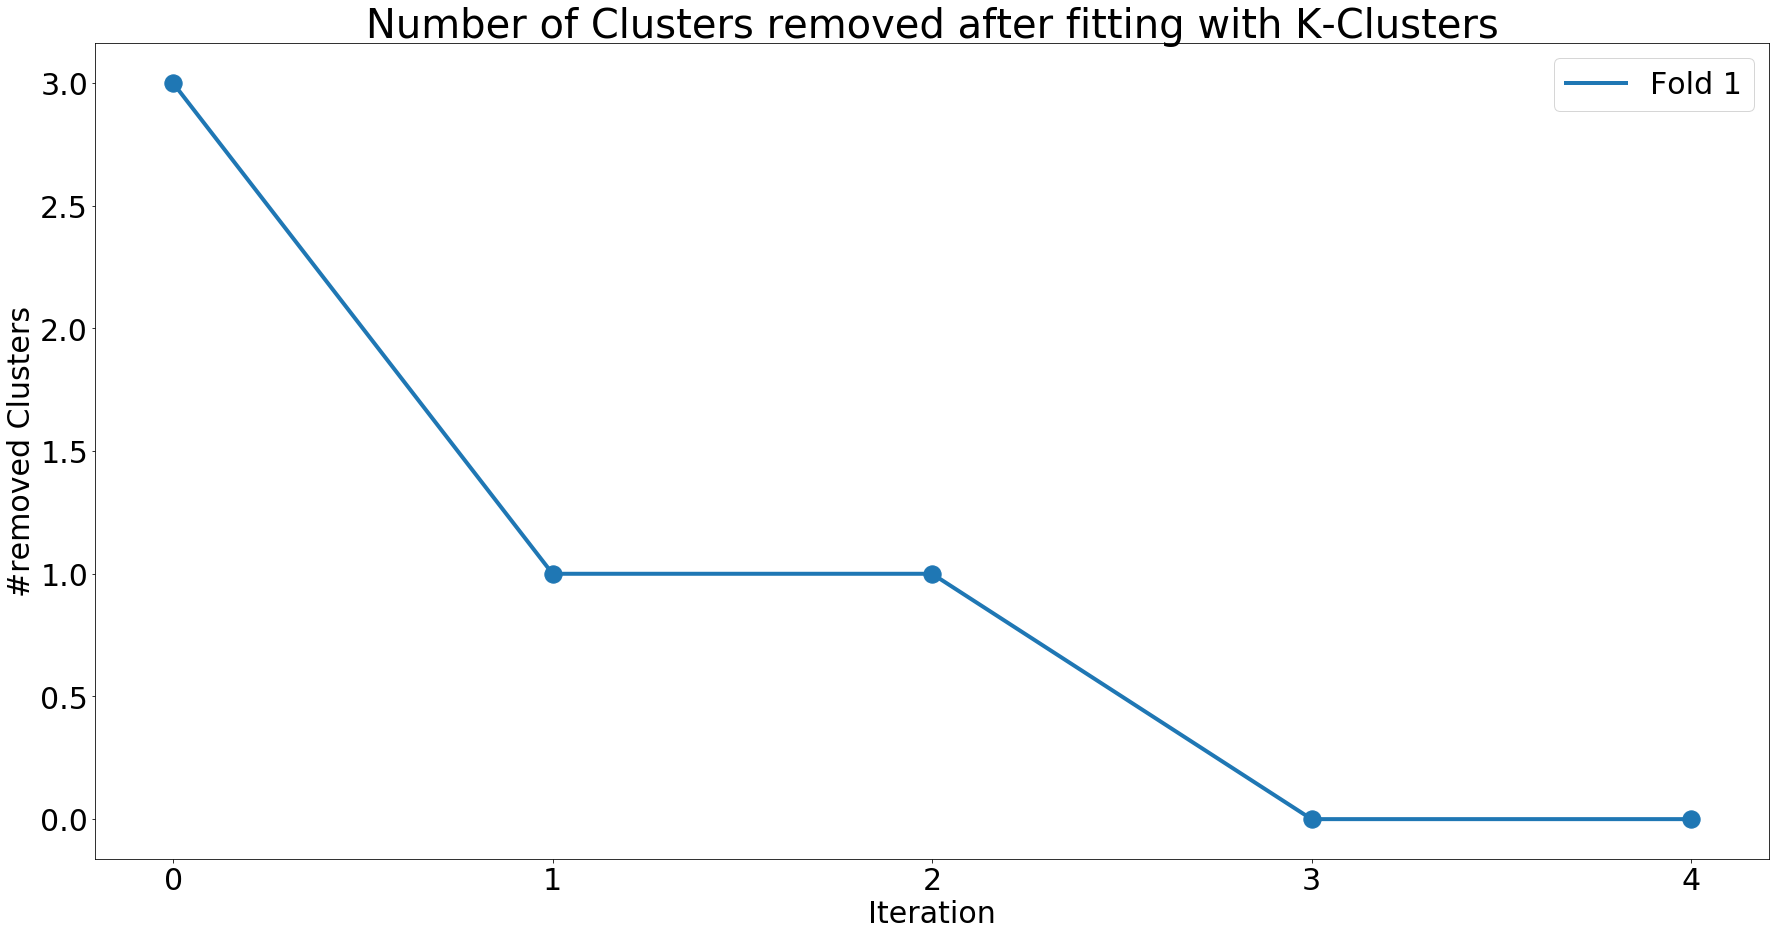

In [103]:
fig, ax = plt.subplots(figsize=(30,15))
color = ["C%d" %i for i in range(10)]
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 

iterations = range(len(n_bad_clusters_per_fold_and_iteration))
print(n_bad_clusters_per_fold_and_iteration)
for i in range(1): # per fold 
    ax.scatter(iterations, np.asarray(n_bad_clusters_per_fold_and_iteration)[:,i], s = 300, color = color[i])
    ax.plot(iterations, np.asarray(n_bad_clusters_per_fold_and_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4,color = color[i])
ax.legend(fontsize = 30)
ax.set_title("Number of Clusters removed after fitting with K-Clusters", fontsize = 40)
#ax.set_ylim((0,14))
#ax.set_yticks(range(0,14))
ax.set_ylabel("#removed Clusters", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)
ax.set_xticks(range(len(n_bad_clusters_per_fold_and_iteration)))

[[0], [1.95], [2.25], [84.13000000000001], [84.13000000000001]]


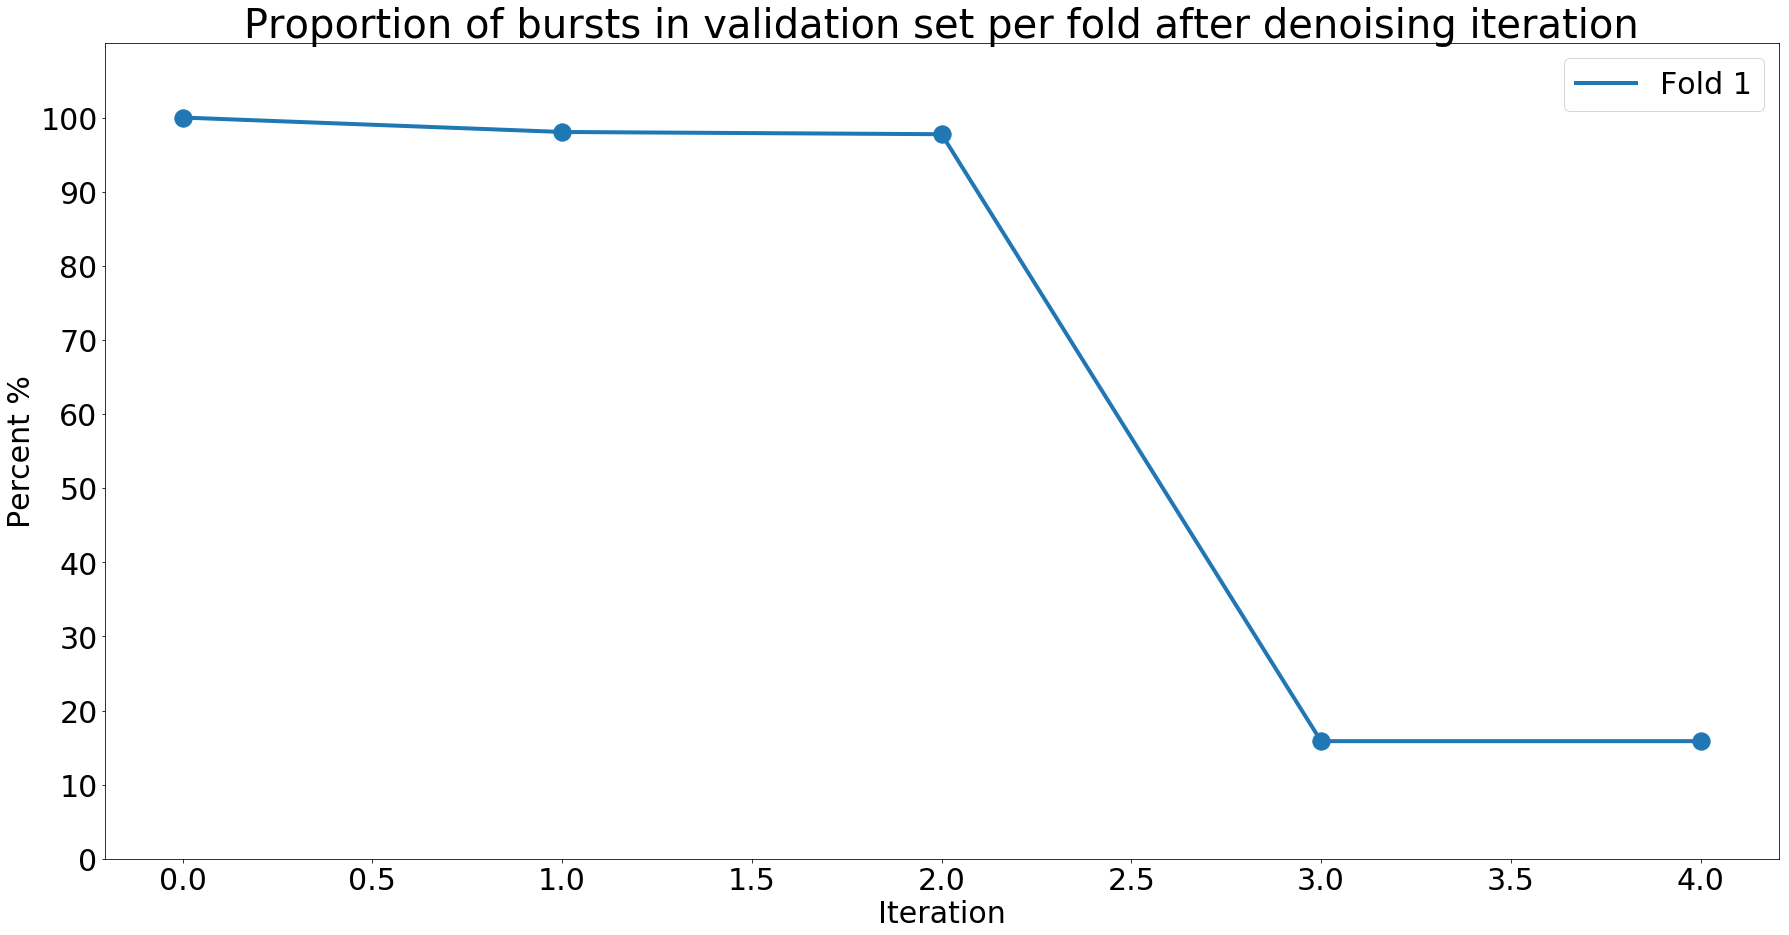

In [104]:
print(reduction_in_percent_per_iteration)
fig, ax = plt.subplots(figsize=(30,15))
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30) 
  
iterations = range(len(reduction_in_percent_per_iteration))
for i in range(1): # per fold 
    ax.scatter(iterations, 100 - np.asarray(reduction_in_percent_per_iteration)[:,i], s = 300,color = color[i])
    ax.plot(iterations, 100 - np.asarray(reduction_in_percent_per_iteration)[:,i],label = "Fold %d" % (i+1), linewidth = 4, color = color[i])
ax.legend(fontsize = 30)
ax.set_title("Proportion of bursts in validation set per fold after denoising iteration", fontsize = 40)
ax.set_ylabel("Percent %", fontsize = 30)
ax.set_xlabel("Iteration", fontsize = 30)
ax.set_ylim((0,110))
ax.set_yticks(range(0,110,10))

## Disacarded Bursts based on low prediction strength clusters

In [105]:
discarded_burst_indices = list(valid_folds[0])
for idx in valid_folds_without_bad_clusters[0]:
    discarded_burst_indices.remove(idx)

In [106]:
print(valid_folds[0][0:10])
print(valid_folds_without_bad_clusters[0][0:10])
print(discarded_burst_indices[0:10])

[ 1  2  4  5  8 15 25 26 31 33]
[ 4  5  8 15 25 43 49 66 68 77]
[1, 2, 26, 31, 33, 62, 69, 75, 76, 79]


2761


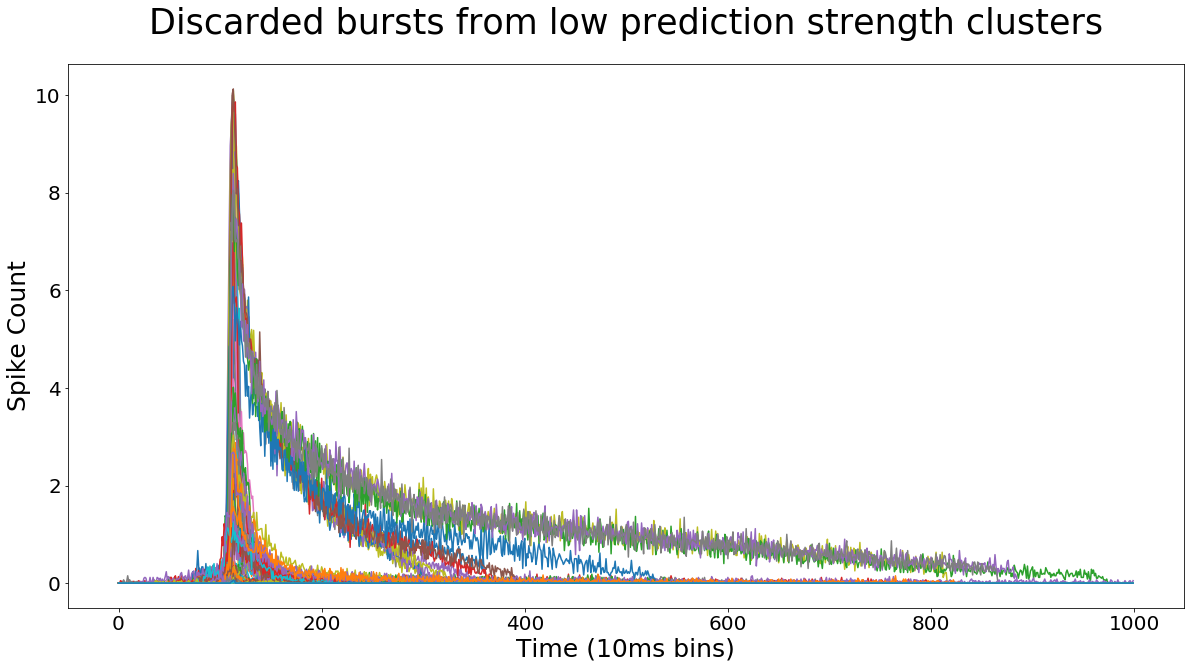

In [107]:
plt.figure(figsize=(20,10))
print(len(dataset_cutted2[discarded_burst_indices]))
for burst in dataset_cutted2[discarded_burst_indices]:
    plt.plot(burst)
    
plt.xlabel("Time (10ms bins)",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Spike Count",fontsize = 25)
plt.title("Discarded bursts from low prediction strength clusters",fontsize = 35,pad = 30)    
plt.show()

# Denoise Data based on prediction Strength per sample 
Calculate prediction strength per sample and throw out samples with low prediction strength.
Reduce the number of clusters if all samples of one cluster are thrown out. 

In [220]:
bics = list(np.load(data_dir + '50_50_split/bics_1.npy',allow_pickle=True)) # contains bic score for training and validation set since 50/50 split one file contains full info about bic 
scores_1 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True)) # scores for training and validation set 
scores_2 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True))

predictions_valid_1 = list(np.load(data_dir + '50_50_split/predictions_valid_1.npy',allow_pickle=True)) # predictions of validation set 
predictions_valid_2 = list(np.load(data_dir + '50_50_split/predictions_valid_2.npy',allow_pickle=True))

predictions_train_1 = list(np.load(data_dir + '50_50_split/predictions_train_1.npy',allow_pickle=True)) # predictions of training set 
predictions_train_2 = list(np.load(data_dir + '50_50_split/predictions_train_2.npy',allow_pickle=True)) 

predictions_valid_fitted_1 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_1.npy',allow_pickle=True)) # predictions of validation set after fitting gmm on it
predictions_valid_fitted_2 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_2.npy',allow_pickle=True)) 

In [221]:
n_clusters = 20
n_folds = 2


train_fold_labels_gmm = np.stack((predictions_train_1,predictions_train_2),axis = 0)
valid_fold_labels_gmm = np.stack((predictions_valid_fitted_1,predictions_valid_fitted_2), axis = 0)

In [222]:
predictions_strengths_cv_gmm_per_sample = list(np.load(data_dir + '50_50_split/prediction_strength_gmm_per_sample.npy',allow_pickle=True))
predictions_strengths_cv_gmm = list(np.load(data_dir + '50_50_split/prediction_strength_gmm.npy',allow_pickle=True))
valid_fold_labels_predicted_gmm = list(np.load(data_dir + '50_50_split/valid_fold_labels_predicted_gmm.npy',allow_pickle=True))

In [223]:
init_k_clusters = [8,9]
counter = 0
threshold = 0.8
n_low_ps_bursts_per_fold = [100,100]
n_folds = 2

n_init=100
max_iter=100


sub_dir = '50_50_split/denoising/GMM/k_init=[8,9]_denoising_per_sample/threshold=0.8/'

In [224]:
from ipynb.fs.defs.Spectral_clustering_pipeline import spectral_clustering
from ipynb.fs.defs.prediction_strength import cross_valdation_prediction_strength
from ipynb.fs.defs.prediction_strength import get_low_individual_ps_bursts
from ipynb.fs.defs.prediction_strength import get_low_and_high_ps_bursts_fold_with_labels

- k_high_ps_bursts_folds for validation set
- unite all other validation folds for training set
- keep denoised validation set and cluster both 



In [55]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [225]:
def get_low_individual_ps_bursts(data, train_folds, valid_folds, train_fold_labels, valid_fold_labels ,predictions_strengths_cv_per_samples, n_clusters = range(1,21), threshold = 0.8):
    """ extract burst indices for burst with low individual prediction strength for clustering with k clusters per cluster
    Args:
        data (nd.array): Array containing data (n x m)
        train_folds (list of nd.arrays): list of k training set indices each with dimension n-(n/k) x m
        valid_folds (list of nd.arrays): list of k validation set indices each with dimension n/k x m
        train_fold_labels (list of lists): list of lists containing the cluster labels for each point in training set
        valid_fold_labels (list of lists): list of lists containing the cluster labels for each point in validation set
        predictions_strengths_cv_per_samples(list of lists): list of lists containin the prediction strength for individual bursts in each cluster by clustering with k clusters for each folds 
                                                             1. dim n-folds 2.dim n-clusters 3.dim prediction strength for each cluster i in clustering with k clusters 
        n_clusters (nd.array): range of clusters to use for clustering
        n_folds (int): number of folds the data is splitted 
        threshold (float): cutoff for defining low individual prediction strength                                                    
    
    Returns:
        k_low_individual_ps_cv (list of lists): list of lists containin the burst indices for bursts with individual ps below threshold  strength for individual bursts in each cluster by clustering with k clusters for each folds 
                                                keys = n_clusters  values = k_folds x n_clusters (burst indices of bursts from validation set with individual ps below threshold for each cluster) 
    
    """     
    
    
    k_low_individual_ps_cv = {}
    k_low_individual_ps_cv_sizes = {}
    k_low_individual_ps_cv_sizes_prop = {}
    
    for i in n_clusters: # for each clustering ranging from 1 to max n_clusters 
        k_low_individual_ps_cv[i] = []
        k_low_individual_ps_cv_sizes[i] = []
        k_low_individual_ps_cv_sizes_prop[i] = []
    
    for f, fold in enumerate(predictions_strengths_cv_per_samples): # for each fold
        #print(f,len(train_fold_labels))
        train_fold = train_folds[f] # training set for fold k splitting
        valid_fold = valid_folds[f] # validation set for fold k splitting
        
        train_labels = train_fold_labels[f] # labels for training set  
        valid_labels = valid_fold_labels[f] # labels for validation set 
        
        for j,k in enumerate(fold): # for each clustering j with k clusters prediction strenght of fold 
            train_labels_k = train_labels[j] 
            valid_labels_k = valid_labels[j]
            
            k_low_individual_ps_cv_k = []
            k_low_individual_ps_cv_sizes_k = []
            k_low_individual_ps_cv_sizes_prop_k = []
            
            for i in range(j+1):
                index_in_class = np.where(np.asarray(predictions_strengths_cv_per_samples[f][j][i]) < threshold) #get position relative to class 
                low_predictive_bursts = valid_fold[np.where(valid_labels_k == i)[0][index_in_class]]
                
                k_low_individual_ps_cv_k.append(low_predictive_bursts) #get burst indices relative to overall data
                k_low_individual_ps_cv_sizes_k.append(len(low_predictive_bursts))
                k_low_individual_ps_cv_sizes_prop_k.append(len(low_predictive_bursts)/len(valid_fold[np.where(valid_labels_k == i)[0]]))
            
            k_low_individual_ps_cv[j+1].append(k_low_individual_ps_cv_k)
            k_low_individual_ps_cv_sizes[j+1].append(k_low_individual_ps_cv_sizes_k)
            k_low_individual_ps_cv_sizes_prop[j+1].append(k_low_individual_ps_cv_sizes_prop_k)
            
            
            
    return  k_low_individual_ps_cv,k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop        

In [226]:
k_clusters = np.asarray(init_k_clusters)
threshold = 0.8
while True:
    print("Look [%d %d] Clusters in each fold!" % tuple(list(k_clusters)))
    np.save(data_dir + sub_dir + 'k_clusters_per_fold_%d' % counter , k_clusters)
    
    if counter == 0:
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels_gmm, valid_fold_labels_gmm,predictions_strengths_cv_gmm_per_sample,threshold = threshold)
        n_low_ps_bursts_per_fold = [np.sum(k_low_individual_ps_cv_sizes[k_clusters[i]][i]) for i in range(n_folds)] # get low burst examples for each fold after clustering with k_clusters   
        
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels_gmm,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
        
    else: 
        k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels,predictions_strengths_cv_per_sample_without_low_samples,threshold = threshold)
        n_low_ps_bursts_per_fold = [np.sum(k_low_individual_ps_cv_sizes[k_clusters[i]][i]) for i in range(n_folds)] # get low burst examples for each fold after clustering with k_clusters   
        
        k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(high_ps_valid_folds,high_ps_valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = n_folds,n_clusters = range(1,max(k_clusters)+1))
    
    
    print("[%d %d] Bursts found in each fold with Prediction Strength below threshold = %.2f!" % (tuple(list(n_low_ps_bursts_per_fold) + [threshold])))
    
    if np.sum(n_low_ps_bursts_per_fold) == 0:
        print("Converged!")
        break
        
    print("Save Number of Bursts with low Prediction Strength for each fold!")
    np.save(data_dir + sub_dir + 'n_low_ps_bursts_per_fold_%d' % counter , n_low_ps_bursts_per_fold)
    
     
    high_ps_valid_folds= [] #indices of bursts in validation set with high prediction strenght per fold
    new_k_clusters = []
    
    for i in range(n_folds):  
        high_ps_valid_folds.append(np.asarray(k_high_ps_bursts_folds[k_clusters[i]][i])) # get bursts indices with high ps for clustering with k_clusters 
        new_k_clusters.append(len(np.unique(high_ps_bursts_fold_labels[i][k_clusters[i]-1]))) #get classes with at least one burst 
    
    high_ps_valid_folds = np.asarray(high_ps_valid_folds)
    
    
    clusters = list(range(1,np.amax(new_k_clusters) + 1))
        
    high_ps_train_folds=[]
    high_ps_train_fold_labels=[]
    high_ps_valid_fold_labels=[]
        
    for i in range(n_folds):
        high_ps_bursts_train_i = np.concatenate((high_ps_valid_folds[:i],high_ps_valid_folds[(i+1):]), axis = 0)[0]
        high_ps_train_folds.append(np.asarray(high_ps_bursts_train_i))
            
        high_ps_bursts_valid_i = high_ps_valid_folds[i]
        high_ps_train_labels_i = []
        high_ps_valid_labels_i = []
        for c in clusters: 
            print("Fitting GMM with %d clusters:" % c)
            
            gmm= GMM(c, n_init=n_init, max_iter=max_iter).fit(data[high_ps_bursts_train_i]) 
            gmm_valid = GMM(c, n_init=n_init, max_iter=max_iter).fit(data[high_ps_bursts_valid_i]) 
            
            
            high_ps_train_labels_i.append(np.asarray(gmm.predict(data[high_ps_bursts_train_i])))
            high_ps_valid_labels_i.append(np.asarray(gmm_valid.predict(data[high_ps_bursts_valid_i])))
        
        high_ps_train_fold_labels.append(np.asarray(high_ps_train_labels_i))    
        high_ps_valid_fold_labels.append(np.asarray(high_ps_valid_labels_i))
        
   
    high_ps_train_folds = np.asarray(high_ps_train_folds)
        
    
    print("Save denoised folds!")
    np.save(data_dir + sub_dir + 'high_ps_valid_folds_%d' % (counter + 1), high_ps_valid_folds)
    #np.save(data_dir + sub_dir + 'high_ps_train_folds_%d' % counter, high_ps_train_folds) #not necessary can be derived from validation folds 
    
    print("Save labels!")
    np.save(data_dir + sub_dir + 'high_ps_train_fold_labels_%d' % (counter + 1), high_ps_train_fold_labels)
    np.save(data_dir + sub_dir + 'high_ps_valid_fold_labels_%d' % (counter + 1), high_ps_valid_fold_labels)
    
    
    
    print("Calculate Prediction Strength per sample for each fold! ")  
    predictions_strengths_cv_per_sample_without_low_samples, _ = cross_valdation_prediction_strength(data, high_ps_train_folds, high_ps_valid_folds, high_ps_train_fold_labels, high_ps_valid_fold_labels, per_sample = True)
    print("Done!")   
    
    print("Save Prediction Strength!")
    np.save(data_dir + sub_dir + 'predictions_strengths_cv_per_sample_without_low_samples_%d' % (counter + 1), predictions_strengths_cv_per_sample_without_low_samples)
 
    
    k_clusters = new_k_clusters
    counter += 1

Look [8 9] Clusters in each fold!
[105 96] Bursts found in each fold with Prediction Strength below threshold = 0.80!
Save Number of Bursts with low Prediction Strength for each fold!
Fitting GMM with 1 clusters:
Fitting GMM with 2 clusters:


KeyboardInterrupt: 